# Проект предсказания рисков для здоровья при беременности

## Вступление

### Описание проекта:

Беременность - критический период в жизни женщины, и мониторинг здоровья матери является важным для обеспечения благополучия как матери, так и нерожденного ребенка. Этот проект сосредоточен на использовании методов машинного обучения для прогнозирования уровня риска для беременных женщин на основе ключевых атрибутов здоровья.

### Описание данных:

* Age: Возраст в годах, когда женщина беременна
* BodyTemp: Температура тела, измеряемая в фаренгейтах
* SystolicBP: Верхнее значение артериального давления в мм рт. ст., другой значимый атрибут во время беременности
* DiastolicBP: Нижнее значение артериального давления в мм рт. ст., другой значимый атрибут во время беременности
* BS: Уровень глюкозы в крови, измеряемый молярной концентрацией, ммоль/л
* HeartRate: Нормальная частота сердечных сокращений в минуту
* Risk Level: Предсказанный уровень риска во время беременности, учитывая предыдущие атрибуты

### В чем состоит задача?

Создать прогностическую модель рисков беременных

## Предобработка и анализ данных

### Загрузка библиотек и данных

Подгружаем нужные нам библиотеки и задаем глобальные переменные

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score 
import shap

import os
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
RND_ST = 12345

Расширяем рабочее пространство экрана и выравниваем его по краям

In [4]:
from IPython.core.display import display, HTML
display(HTML("""
<style>
.container { 
   width:90% !important; 
   position: relative; 
   right: 25px; 
}
</style>
"""))

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


Загружаем данные нам датасеты, проверяя что путь верный

In [5]:
def pth_exist(pth):
    if os.path.exists(pth):
        try:
            df = pd.read_csv(pth)
            return df
        except Exception as e:
            print(f'Ошибка при чтении файла: {e}')
            return None
    else:
        print('Путь не таков')
        return None

In [6]:
df = pth_exist(r'C:\Users\Joktun\Desktop\kaggle\pregnant\data\health.csv')

### Анализ и обработка сырых данных

Делаем функцию для выдачи общей информации по датасету

In [7]:
def info_func(df):
    print('Общая информация')
    print('')
    df.info()
    print('')
    print(df.describe())
    print('')
    print('Кол-во пропущенных значений')
    print('')
    print(df.isna().sum().sort_values(ascending=False))
    print('')
    print('Процент пропущенных значений')
    print('')
    print((df.isna().sum()/len(df)*100).sort_values(ascending=False))
    print('')
    print('Как выглядит датасет')
    print('')
    print(df.head(10))

Выведем общую информацию

In [8]:
info_func(df)

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB

               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.

* Как мы можем заметить данные не содержат пропусков. 
* В столбце HeartRate есть аномальное минимальное значение 7. Немного изучив вопрос, я уберу все значения пульса ниже 35. 
* В столбце Age есть аномальное минимальное значение 10. Немного изучив вопрос, я уберу все значения возраста ниже 14. 
* С остальными столбцами вероятно все в порядке.

In [9]:
df = df[~(df['HeartRate'] < 35)]

In [10]:
df = df[~(df['Age'] < 14)]

Делим данные на признаки и целевое значение

In [11]:
features=df.drop(['RiskLevel'],axis=1)
target=df['RiskLevel']

Посмотрим на распределение признаков

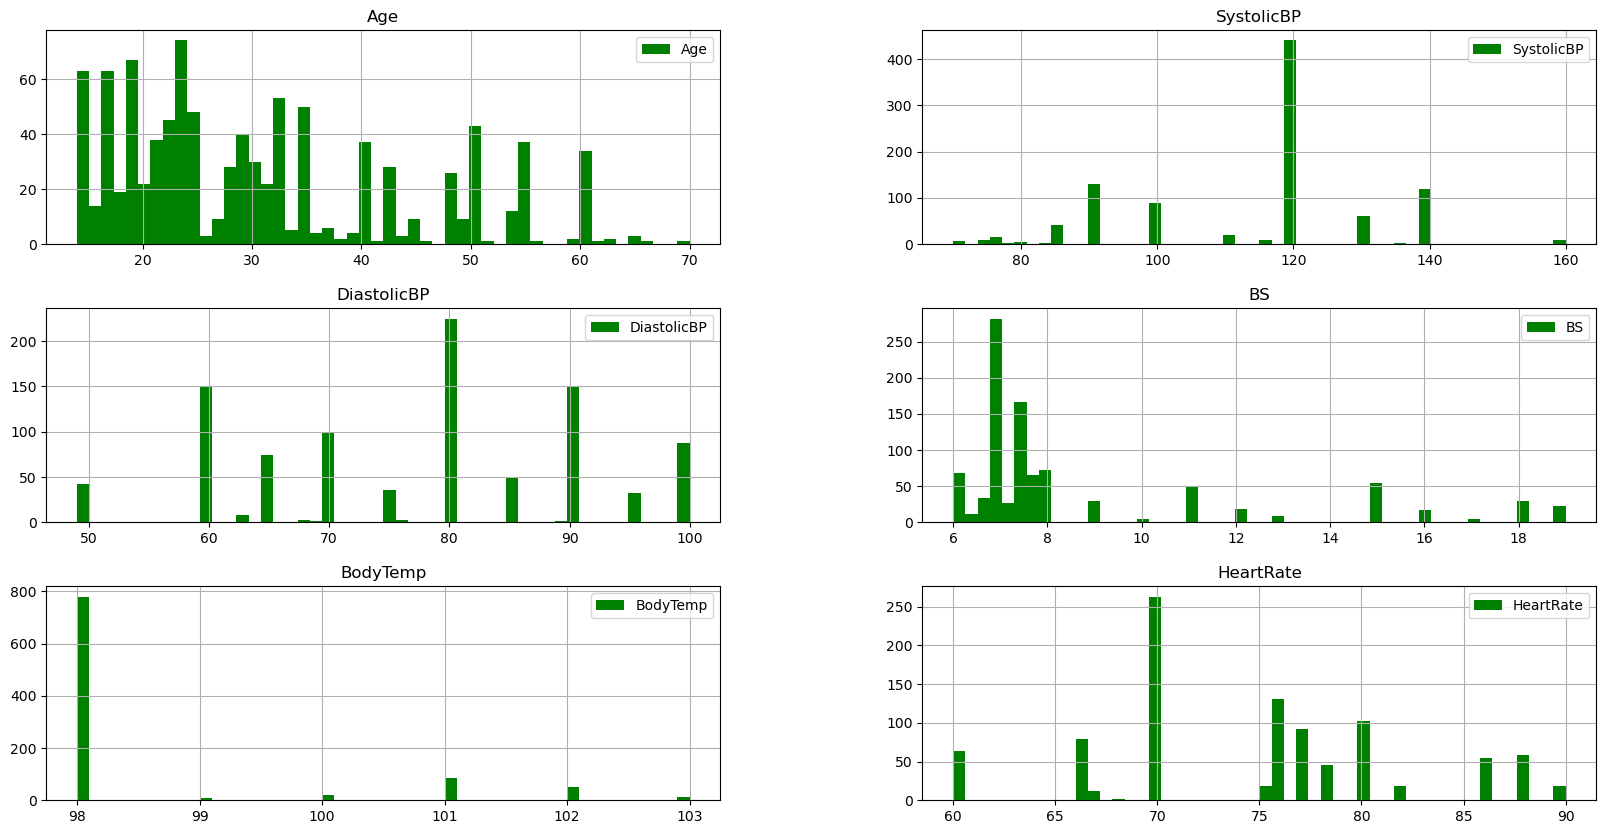

In [12]:
features.hist(bins=50, figsize=(20,10), legend = True, color='green')
plt.show()

Посмотрим на распределение целевого признака

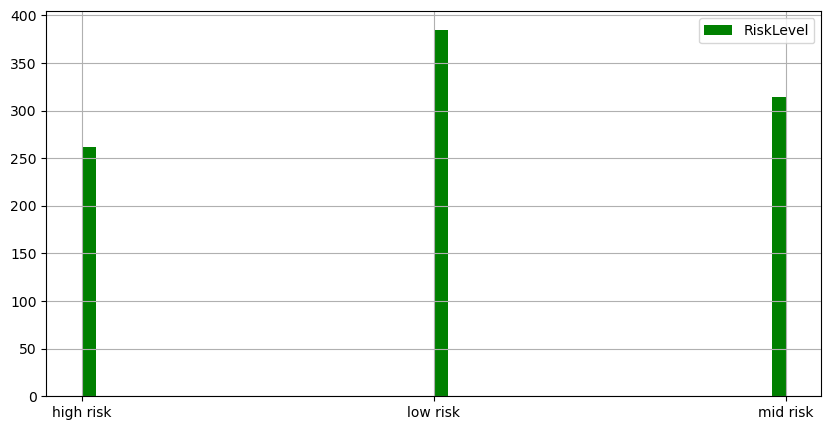

In [13]:
target.hist(bins=50, figsize=(10,5), legend = True, color='green')
plt.show()

Меньше всего людей с высоким риском для здоровья при беременности

### Корреляция

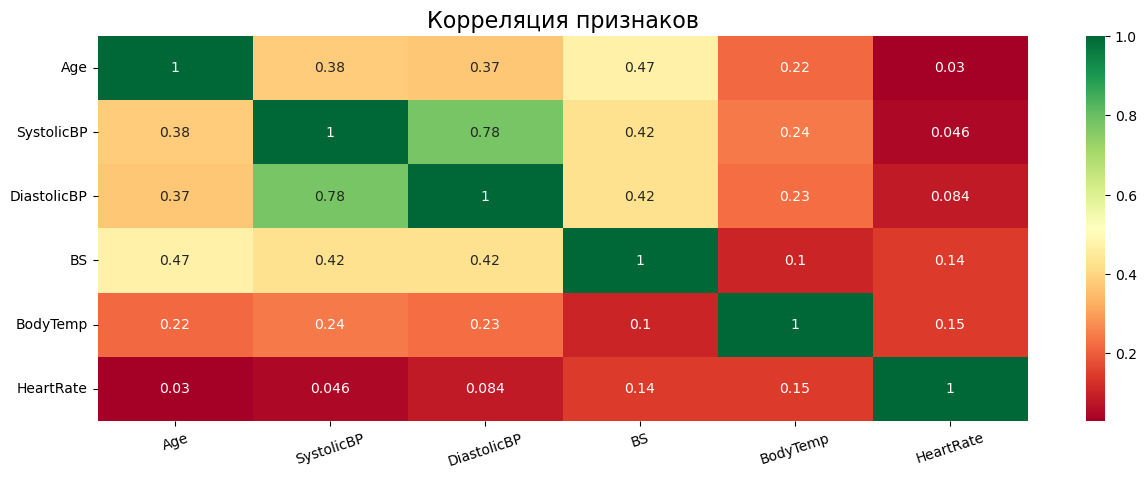

In [14]:
plt.figure(figsize=(15,5))
fig = sns.heatmap(features.corr().abs(), cmap='RdYlGn', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=18)
plt.show()

Позднее, я заметил, что возникла мультиколлинеарность между SystolicBP и DiastolicBP, и, исходя из результатов важности следующей главы, я решил удалить DiastolicBP, т.к. это менее важный признак, чем SystolicBP

In [15]:
features = features.drop(["DiastolicBP"], axis=1)

### Вывод по предобработке и анализу данных

* Удалены аномальные значения
* Исправлена мультиколлинеарность

## Обучение модели

### Разделение на тренировочную и тестовую выборки

Делим на тренировочную и тестовую выборки

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RND_ST, shuffle=True
)

display(features_train.shape)
display(features_test.shape)

(720, 5)

(241, 5)

### Выбор лучшей модели

Подберем лучшие гиперпараметры для CatBoostClassifier

In [17]:
param_grid = {
    'learning_rate': [0.1],
   'depth': [6,8,10],
    'l2_leaf_reg': [1, 3, 5],
   'iterations': [1000]
}
model = CatBoostClassifier(random_state=RND_ST)
cat_grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=10)
cat_grid.fit(features_train, target_train)
train_predictions = cat_grid.predict(features_train)
f_train = f1_score(target_train, train_predictions, average='micro')
print(f'f1_score (train): {f_train:.2f}')
print("Лучшие параметры: ",cat_grid.best_params_)
print("Score: ", cat_grid.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1..
0:	learn: 1.0317211	total: 145ms	remaining: 2m 24s
1:	learn: 0.9777264	total: 149ms	remaining: 1m 14s
2:	learn: 0.9282087	total: 152ms	remaining: 50.4s
3:	learn: 0.8890924	total: 154ms	remaining: 38.3s
4:	learn: 0.8573496	total: 156ms	remaining: 31s
5:	learn: 0.8271286	total: 158ms	remaining: 26.1s
6:	learn: 0.7984310	total: 159ms	remaining: 22.6s
7:	learn: 0.7747926	total: 161ms	remaining: 20s
8:	learn: 0.7527344	total: 162ms	remaining: 17.9s
9:	learn: 0.7334754	total: 164ms	remaining: 16.2s
10:	learn: 0.7146898	total: 165ms	remaining: 14.8s
11:	learn: 0.6976891	total: 166ms	remaining: 13.7s
12:	learn: 0.6827671	total: 167ms	remaining: 12.7s
13:	learn: 0.6697052	total: 168ms	remaining: 11.8s
14:	learn: 0.6599335	total: 169ms	remaining: 11.1s
15:	learn: 0.6469373	total: 170ms	remaining: 10.4s
16:	learn: 0.6359531	total: 171ms	remaining: 9.86s
17:	

257:	learn: 0.2410717	total: 326ms	remaining: 937ms
258:	learn: 0.2405893	total: 327ms	remaining: 935ms
259:	learn: 0.2400900	total: 328ms	remaining: 932ms
260:	learn: 0.2396073	total: 329ms	remaining: 931ms
261:	learn: 0.2392937	total: 329ms	remaining: 928ms
262:	learn: 0.2389587	total: 330ms	remaining: 925ms
263:	learn: 0.2386560	total: 331ms	remaining: 922ms
264:	learn: 0.2381422	total: 332ms	remaining: 919ms
265:	learn: 0.2376611	total: 332ms	remaining: 917ms
266:	learn: 0.2369634	total: 333ms	remaining: 914ms
267:	learn: 0.2367269	total: 333ms	remaining: 911ms
268:	learn: 0.2361846	total: 334ms	remaining: 908ms
269:	learn: 0.2358437	total: 335ms	remaining: 905ms
270:	learn: 0.2356723	total: 335ms	remaining: 902ms
271:	learn: 0.2352773	total: 336ms	remaining: 899ms
272:	learn: 0.2348830	total: 337ms	remaining: 896ms
273:	learn: 0.2346303	total: 337ms	remaining: 894ms
274:	learn: 0.2342290	total: 338ms	remaining: 891ms
275:	learn: 0.2339948	total: 339ms	remaining: 888ms
276:	learn: 

507:	learn: 0.1906521	total: 486ms	remaining: 471ms
508:	learn: 0.1905783	total: 490ms	remaining: 473ms
509:	learn: 0.1905017	total: 494ms	remaining: 475ms
510:	learn: 0.1904442	total: 497ms	remaining: 476ms
511:	learn: 0.1903005	total: 501ms	remaining: 478ms
512:	learn: 0.1902553	total: 505ms	remaining: 479ms
513:	learn: 0.1900541	total: 508ms	remaining: 480ms
514:	learn: 0.1900031	total: 510ms	remaining: 480ms
515:	learn: 0.1897637	total: 512ms	remaining: 480ms
516:	learn: 0.1896244	total: 514ms	remaining: 480ms
517:	learn: 0.1895675	total: 516ms	remaining: 480ms
518:	learn: 0.1893886	total: 518ms	remaining: 480ms
519:	learn: 0.1892952	total: 519ms	remaining: 479ms
520:	learn: 0.1892504	total: 521ms	remaining: 479ms
521:	learn: 0.1891844	total: 522ms	remaining: 478ms
522:	learn: 0.1890357	total: 524ms	remaining: 478ms
523:	learn: 0.1889403	total: 526ms	remaining: 477ms
524:	learn: 0.1888147	total: 527ms	remaining: 477ms
525:	learn: 0.1887261	total: 528ms	remaining: 476ms
526:	learn: 

746:	learn: 0.1739755	total: 668ms	remaining: 226ms
747:	learn: 0.1739282	total: 669ms	remaining: 225ms
748:	learn: 0.1738648	total: 670ms	remaining: 225ms
749:	learn: 0.1738341	total: 671ms	remaining: 224ms
750:	learn: 0.1738082	total: 671ms	remaining: 223ms
751:	learn: 0.1737465	total: 672ms	remaining: 222ms
752:	learn: 0.1737246	total: 672ms	remaining: 221ms
753:	learn: 0.1736290	total: 673ms	remaining: 220ms
754:	learn: 0.1735914	total: 673ms	remaining: 219ms
755:	learn: 0.1735644	total: 674ms	remaining: 218ms
756:	learn: 0.1735100	total: 674ms	remaining: 217ms
757:	learn: 0.1734442	total: 675ms	remaining: 216ms
758:	learn: 0.1733813	total: 676ms	remaining: 215ms
759:	learn: 0.1733271	total: 676ms	remaining: 214ms
760:	learn: 0.1733054	total: 677ms	remaining: 213ms
761:	learn: 0.1732222	total: 677ms	remaining: 212ms
762:	learn: 0.1731998	total: 678ms	remaining: 211ms
763:	learn: 0.1731911	total: 679ms	remaining: 210ms
764:	learn: 0.1731383	total: 679ms	remaining: 209ms
765:	learn: 

[CV 1/5; 1/9] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.875 total time=   1.1s
[CV 2/5; 1/9] START depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1..
0:	learn: 1.0372625	total: 3.54ms	remaining: 3.54s
1:	learn: 0.9774270	total: 6.39ms	remaining: 3.19s
2:	learn: 0.9265701	total: 12.4ms	remaining: 4.11s
3:	learn: 0.8829578	total: 16.2ms	remaining: 4.04s
4:	learn: 0.8486825	total: 19.1ms	remaining: 3.8s
5:	learn: 0.8254448	total: 22.1ms	remaining: 3.66s
6:	learn: 0.7988882	total: 26.7ms	remaining: 3.79s
7:	learn: 0.7771365	total: 29.8ms	remaining: 3.7s
8:	learn: 0.7558374	total: 32.6ms	remaining: 3.59s
9:	learn: 0.7396617	total: 35.2ms	remaining: 3.48s
10:	learn: 0.7218636	total: 37ms	remaining: 3.32s
11:	learn: 0.7021147	total: 39.8ms	remaining: 3.27s
12:	learn: 0.6890676	total: 42ms	remaining: 3.19s
13:	learn: 0.6773169	total: 43.5ms	remaining: 3.07s
14:	learn: 0.6638203	total: 44.9ms	remaining: 2.95s
15:	learn: 0.6509548	total: 46.3ms	remaining:

404:	learn: 0.2001206	total: 306ms	remaining: 450ms
405:	learn: 0.1999262	total: 307ms	remaining: 449ms
406:	learn: 0.1998003	total: 308ms	remaining: 449ms
407:	learn: 0.1997310	total: 309ms	remaining: 448ms
408:	learn: 0.1996473	total: 309ms	remaining: 447ms
409:	learn: 0.1994461	total: 310ms	remaining: 446ms
410:	learn: 0.1992457	total: 311ms	remaining: 445ms
411:	learn: 0.1990396	total: 311ms	remaining: 444ms
412:	learn: 0.1988496	total: 312ms	remaining: 444ms
413:	learn: 0.1987765	total: 313ms	remaining: 443ms
414:	learn: 0.1986232	total: 313ms	remaining: 442ms
415:	learn: 0.1984829	total: 314ms	remaining: 441ms
416:	learn: 0.1983604	total: 315ms	remaining: 440ms
417:	learn: 0.1982284	total: 315ms	remaining: 439ms
418:	learn: 0.1981138	total: 316ms	remaining: 438ms
419:	learn: 0.1980065	total: 316ms	remaining: 437ms
420:	learn: 0.1977449	total: 317ms	remaining: 436ms
421:	learn: 0.1974698	total: 318ms	remaining: 435ms
422:	learn: 0.1972467	total: 319ms	remaining: 434ms
423:	learn: 

695:	learn: 0.1721556	total: 490ms	remaining: 214ms
696:	learn: 0.1721302	total: 491ms	remaining: 213ms
697:	learn: 0.1720783	total: 492ms	remaining: 213ms
698:	learn: 0.1719794	total: 492ms	remaining: 212ms
699:	learn: 0.1719343	total: 493ms	remaining: 211ms
700:	learn: 0.1718822	total: 494ms	remaining: 211ms
701:	learn: 0.1718525	total: 494ms	remaining: 210ms
702:	learn: 0.1718168	total: 495ms	remaining: 209ms
703:	learn: 0.1717574	total: 495ms	remaining: 208ms
704:	learn: 0.1717177	total: 496ms	remaining: 207ms
705:	learn: 0.1716663	total: 496ms	remaining: 207ms
706:	learn: 0.1716151	total: 497ms	remaining: 206ms
707:	learn: 0.1715860	total: 497ms	remaining: 205ms
708:	learn: 0.1715577	total: 498ms	remaining: 204ms
709:	learn: 0.1714741	total: 499ms	remaining: 204ms
710:	learn: 0.1714332	total: 499ms	remaining: 203ms
711:	learn: 0.1713876	total: 500ms	remaining: 202ms
712:	learn: 0.1713626	total: 501ms	remaining: 201ms
713:	learn: 0.1712797	total: 502ms	remaining: 201ms
714:	learn: 

923:	learn: 0.1624256	total: 657ms	remaining: 54ms
924:	learn: 0.1623989	total: 659ms	remaining: 53.4ms
925:	learn: 0.1623694	total: 661ms	remaining: 52.8ms
926:	learn: 0.1623246	total: 662ms	remaining: 52.1ms
927:	learn: 0.1622991	total: 663ms	remaining: 51.5ms
928:	learn: 0.1622526	total: 664ms	remaining: 50.8ms
929:	learn: 0.1622425	total: 666ms	remaining: 50.1ms
930:	learn: 0.1622148	total: 667ms	remaining: 49.4ms
931:	learn: 0.1621927	total: 668ms	remaining: 48.7ms
932:	learn: 0.1621274	total: 669ms	remaining: 48ms
933:	learn: 0.1620694	total: 670ms	remaining: 47.3ms
934:	learn: 0.1619525	total: 671ms	remaining: 46.6ms
935:	learn: 0.1619249	total: 672ms	remaining: 45.9ms
936:	learn: 0.1618815	total: 673ms	remaining: 45.2ms
937:	learn: 0.1618442	total: 674ms	remaining: 44.5ms
938:	learn: 0.1618187	total: 675ms	remaining: 43.8ms
939:	learn: 0.1617590	total: 675ms	remaining: 43.1ms
940:	learn: 0.1617425	total: 676ms	remaining: 42.4ms
941:	learn: 0.1617003	total: 677ms	remaining: 41.7

135:	learn: 0.3173278	total: 137ms	remaining: 868ms
136:	learn: 0.3165187	total: 137ms	remaining: 865ms
137:	learn: 0.3152674	total: 139ms	remaining: 865ms
138:	learn: 0.3143789	total: 139ms	remaining: 863ms
139:	learn: 0.3138161	total: 140ms	remaining: 860ms
140:	learn: 0.3127975	total: 141ms	remaining: 858ms
141:	learn: 0.3120799	total: 141ms	remaining: 855ms
142:	learn: 0.3112059	total: 142ms	remaining: 852ms
143:	learn: 0.3099081	total: 143ms	remaining: 849ms
144:	learn: 0.3089879	total: 143ms	remaining: 846ms
145:	learn: 0.3074635	total: 144ms	remaining: 845ms
146:	learn: 0.3063139	total: 145ms	remaining: 842ms
147:	learn: 0.3054114	total: 146ms	remaining: 838ms
148:	learn: 0.3047594	total: 146ms	remaining: 836ms
149:	learn: 0.3035727	total: 147ms	remaining: 834ms
150:	learn: 0.3024929	total: 148ms	remaining: 831ms
151:	learn: 0.3015999	total: 148ms	remaining: 828ms
152:	learn: 0.3009897	total: 149ms	remaining: 825ms
153:	learn: 0.3003542	total: 150ms	remaining: 821ms
154:	learn: 

440:	learn: 0.1914136	total: 322ms	remaining: 409ms
441:	learn: 0.1912081	total: 323ms	remaining: 408ms
442:	learn: 0.1910234	total: 325ms	remaining: 408ms
443:	learn: 0.1908608	total: 326ms	remaining: 408ms
444:	learn: 0.1906918	total: 327ms	remaining: 407ms
445:	learn: 0.1905084	total: 328ms	remaining: 407ms
446:	learn: 0.1903904	total: 328ms	remaining: 406ms
447:	learn: 0.1903051	total: 329ms	remaining: 405ms
448:	learn: 0.1902371	total: 330ms	remaining: 405ms
449:	learn: 0.1900666	total: 330ms	remaining: 404ms
450:	learn: 0.1900336	total: 331ms	remaining: 403ms
451:	learn: 0.1898165	total: 332ms	remaining: 402ms
452:	learn: 0.1896463	total: 333ms	remaining: 402ms
453:	learn: 0.1895516	total: 333ms	remaining: 401ms
454:	learn: 0.1894179	total: 334ms	remaining: 400ms
455:	learn: 0.1892199	total: 335ms	remaining: 400ms
456:	learn: 0.1891298	total: 336ms	remaining: 399ms
457:	learn: 0.1889496	total: 337ms	remaining: 399ms
458:	learn: 0.1889108	total: 338ms	remaining: 398ms
459:	learn: 

747:	learn: 0.1661886	total: 508ms	remaining: 171ms
748:	learn: 0.1661508	total: 510ms	remaining: 171ms
749:	learn: 0.1660798	total: 510ms	remaining: 170ms
750:	learn: 0.1660443	total: 511ms	remaining: 169ms
751:	learn: 0.1659486	total: 512ms	remaining: 169ms
752:	learn: 0.1658722	total: 512ms	remaining: 168ms
753:	learn: 0.1657666	total: 513ms	remaining: 167ms
754:	learn: 0.1657350	total: 513ms	remaining: 167ms
755:	learn: 0.1656959	total: 514ms	remaining: 166ms
756:	learn: 0.1656692	total: 514ms	remaining: 165ms
757:	learn: 0.1656430	total: 515ms	remaining: 164ms
758:	learn: 0.1655750	total: 516ms	remaining: 164ms
759:	learn: 0.1655127	total: 516ms	remaining: 163ms
760:	learn: 0.1653790	total: 517ms	remaining: 162ms
761:	learn: 0.1653650	total: 517ms	remaining: 162ms
762:	learn: 0.1653153	total: 518ms	remaining: 161ms
763:	learn: 0.1652811	total: 519ms	remaining: 160ms
764:	learn: 0.1652591	total: 519ms	remaining: 159ms
765:	learn: 0.1652293	total: 520ms	remaining: 159ms
766:	learn: 

[CV 3/5; 1/9] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.833 total time=   0.9s
[CV 4/5; 1/9] START depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1..
0:	learn: 1.0315749	total: 4.48ms	remaining: 4.48s
1:	learn: 0.9714325	total: 9.03ms	remaining: 4.51s
2:	learn: 0.9226425	total: 11.9ms	remaining: 3.94s
3:	learn: 0.8817086	total: 15.5ms	remaining: 3.87s
4:	learn: 0.8462677	total: 19.6ms	remaining: 3.9s
5:	learn: 0.8166334	total: 22.3ms	remaining: 3.7s
6:	learn: 0.7887514	total: 24.3ms	remaining: 3.45s
7:	learn: 0.7639955	total: 26.3ms	remaining: 3.26s
8:	learn: 0.7381032	total: 29ms	remaining: 3.19s
9:	learn: 0.7208370	total: 31.7ms	remaining: 3.13s
10:	learn: 0.7053676	total: 33.8ms	remaining: 3.04s
11:	learn: 0.6888001	total: 35.3ms	remaining: 2.9s
12:	learn: 0.6751435	total: 36.8ms	remaining: 2.79s
13:	learn: 0.6621100	total: 38.1ms	remaining: 2.69s
14:	learn: 0.6466468	total: 39.5ms	remaining: 2.59s
15:	learn: 0.6362438	total: 40.6ms	remaining

166:	learn: 0.2625356	total: 136ms	remaining: 676ms
167:	learn: 0.2617231	total: 136ms	remaining: 675ms
168:	learn: 0.2606688	total: 137ms	remaining: 674ms
169:	learn: 0.2593959	total: 138ms	remaining: 673ms
170:	learn: 0.2584952	total: 138ms	remaining: 671ms
171:	learn: 0.2578151	total: 139ms	remaining: 669ms
172:	learn: 0.2573906	total: 140ms	remaining: 667ms
173:	learn: 0.2565142	total: 140ms	remaining: 666ms
174:	learn: 0.2554041	total: 141ms	remaining: 664ms
175:	learn: 0.2546120	total: 142ms	remaining: 663ms
176:	learn: 0.2539742	total: 143ms	remaining: 663ms
177:	learn: 0.2530937	total: 143ms	remaining: 661ms
178:	learn: 0.2524816	total: 144ms	remaining: 659ms
179:	learn: 0.2515323	total: 145ms	remaining: 658ms
180:	learn: 0.2509641	total: 145ms	remaining: 658ms
181:	learn: 0.2503039	total: 146ms	remaining: 656ms
182:	learn: 0.2495368	total: 147ms	remaining: 655ms
183:	learn: 0.2487903	total: 148ms	remaining: 654ms
184:	learn: 0.2480012	total: 148ms	remaining: 654ms
185:	learn: 

466:	learn: 0.1668788	total: 319ms	remaining: 364ms
467:	learn: 0.1668335	total: 320ms	remaining: 364ms
468:	learn: 0.1667817	total: 321ms	remaining: 363ms
469:	learn: 0.1667013	total: 321ms	remaining: 362ms
470:	learn: 0.1665958	total: 322ms	remaining: 362ms
471:	learn: 0.1664463	total: 322ms	remaining: 361ms
472:	learn: 0.1663026	total: 323ms	remaining: 360ms
473:	learn: 0.1662690	total: 324ms	remaining: 359ms
474:	learn: 0.1661149	total: 324ms	remaining: 359ms
475:	learn: 0.1659899	total: 325ms	remaining: 358ms
476:	learn: 0.1658918	total: 326ms	remaining: 357ms
477:	learn: 0.1658198	total: 326ms	remaining: 357ms
478:	learn: 0.1657014	total: 327ms	remaining: 356ms
479:	learn: 0.1656158	total: 328ms	remaining: 355ms
480:	learn: 0.1655400	total: 328ms	remaining: 354ms
481:	learn: 0.1654686	total: 329ms	remaining: 354ms
482:	learn: 0.1653936	total: 330ms	remaining: 353ms
483:	learn: 0.1652140	total: 330ms	remaining: 352ms
484:	learn: 0.1650343	total: 331ms	remaining: 351ms
485:	learn: 

730:	learn: 0.1478428	total: 504ms	remaining: 186ms
731:	learn: 0.1477911	total: 505ms	remaining: 185ms
732:	learn: 0.1477543	total: 506ms	remaining: 184ms
733:	learn: 0.1477205	total: 507ms	remaining: 184ms
734:	learn: 0.1476714	total: 507ms	remaining: 183ms
735:	learn: 0.1476344	total: 508ms	remaining: 182ms
736:	learn: 0.1476003	total: 509ms	remaining: 182ms
737:	learn: 0.1475725	total: 510ms	remaining: 181ms
738:	learn: 0.1475409	total: 511ms	remaining: 180ms
739:	learn: 0.1475199	total: 511ms	remaining: 180ms
740:	learn: 0.1475056	total: 512ms	remaining: 179ms
741:	learn: 0.1473904	total: 512ms	remaining: 178ms
742:	learn: 0.1473628	total: 513ms	remaining: 177ms
743:	learn: 0.1473131	total: 514ms	remaining: 177ms
744:	learn: 0.1472792	total: 514ms	remaining: 176ms
745:	learn: 0.1472417	total: 515ms	remaining: 175ms
746:	learn: 0.1472092	total: 515ms	remaining: 175ms
747:	learn: 0.1471928	total: 516ms	remaining: 174ms
748:	learn: 0.1471365	total: 516ms	remaining: 173ms
749:	learn: 

[CV 4/5; 1/9] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.750 total time=   0.9s
[CV 5/5; 1/9] START depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1..
0:	learn: 1.0299393	total: 1.16ms	remaining: 1.16s
1:	learn: 0.9708861	total: 2.1ms	remaining: 1.05s
2:	learn: 0.9271700	total: 3.07ms	remaining: 1.02s
3:	learn: 0.8871669	total: 4.01ms	remaining: 998ms
4:	learn: 0.8527414	total: 4.82ms	remaining: 959ms
5:	learn: 0.8316451	total: 5.89ms	remaining: 976ms
6:	learn: 0.8010873	total: 6.91ms	remaining: 981ms
7:	learn: 0.7756720	total: 7.65ms	remaining: 949ms
8:	learn: 0.7539084	total: 8.37ms	remaining: 922ms
9:	learn: 0.7402130	total: 9.07ms	remaining: 898ms
10:	learn: 0.7210536	total: 9.71ms	remaining: 873ms
11:	learn: 0.7028260	total: 10.4ms	remaining: 852ms
12:	learn: 0.6863539	total: 11ms	remaining: 834ms
13:	learn: 0.6722942	total: 11.6ms	remaining: 818ms
14:	learn: 0.6606920	total: 12.2ms	remaining: 804ms
15:	learn: 0.6486536	total: 12.9ms	remaini

219:	learn: 0.2687231	total: 139ms	remaining: 491ms
220:	learn: 0.2682837	total: 139ms	remaining: 491ms
221:	learn: 0.2673773	total: 140ms	remaining: 491ms
222:	learn: 0.2667917	total: 141ms	remaining: 490ms
223:	learn: 0.2664235	total: 142ms	remaining: 491ms
224:	learn: 0.2658738	total: 142ms	remaining: 490ms
225:	learn: 0.2656066	total: 143ms	remaining: 489ms
226:	learn: 0.2648360	total: 143ms	remaining: 489ms
227:	learn: 0.2640613	total: 144ms	remaining: 488ms
228:	learn: 0.2635634	total: 145ms	remaining: 487ms
229:	learn: 0.2630644	total: 145ms	remaining: 487ms
230:	learn: 0.2628336	total: 146ms	remaining: 486ms
231:	learn: 0.2624089	total: 147ms	remaining: 485ms
232:	learn: 0.2619530	total: 147ms	remaining: 485ms
233:	learn: 0.2615499	total: 148ms	remaining: 485ms
234:	learn: 0.2609926	total: 149ms	remaining: 485ms
235:	learn: 0.2605353	total: 150ms	remaining: 484ms
236:	learn: 0.2600377	total: 150ms	remaining: 483ms
237:	learn: 0.2593137	total: 151ms	remaining: 483ms
238:	learn: 

538:	learn: 0.1915947	total: 323ms	remaining: 276ms
539:	learn: 0.1914808	total: 324ms	remaining: 276ms
540:	learn: 0.1913583	total: 325ms	remaining: 276ms
541:	learn: 0.1913109	total: 326ms	remaining: 275ms
542:	learn: 0.1912357	total: 326ms	remaining: 275ms
543:	learn: 0.1910741	total: 327ms	remaining: 274ms
544:	learn: 0.1909697	total: 327ms	remaining: 273ms
545:	learn: 0.1908595	total: 328ms	remaining: 273ms
546:	learn: 0.1907118	total: 329ms	remaining: 272ms
547:	learn: 0.1906916	total: 329ms	remaining: 272ms
548:	learn: 0.1905253	total: 330ms	remaining: 271ms
549:	learn: 0.1904752	total: 330ms	remaining: 270ms
550:	learn: 0.1902843	total: 331ms	remaining: 270ms
551:	learn: 0.1901656	total: 332ms	remaining: 269ms
552:	learn: 0.1900971	total: 332ms	remaining: 269ms
553:	learn: 0.1899974	total: 333ms	remaining: 268ms
554:	learn: 0.1899034	total: 334ms	remaining: 268ms
555:	learn: 0.1898229	total: 334ms	remaining: 267ms
556:	learn: 0.1897655	total: 335ms	remaining: 267ms
557:	learn: 

731:	learn: 0.1778659	total: 489ms	remaining: 179ms
732:	learn: 0.1778418	total: 490ms	remaining: 178ms
733:	learn: 0.1777639	total: 491ms	remaining: 178ms
734:	learn: 0.1777443	total: 491ms	remaining: 177ms
735:	learn: 0.1776869	total: 492ms	remaining: 177ms
736:	learn: 0.1776485	total: 493ms	remaining: 176ms
737:	learn: 0.1775886	total: 493ms	remaining: 175ms
738:	learn: 0.1775453	total: 494ms	remaining: 174ms
739:	learn: 0.1775047	total: 495ms	remaining: 174ms
740:	learn: 0.1774967	total: 495ms	remaining: 173ms
741:	learn: 0.1774247	total: 496ms	remaining: 172ms
742:	learn: 0.1773990	total: 497ms	remaining: 172ms
743:	learn: 0.1773728	total: 497ms	remaining: 171ms
744:	learn: 0.1773489	total: 498ms	remaining: 170ms
745:	learn: 0.1772414	total: 499ms	remaining: 170ms
746:	learn: 0.1771854	total: 499ms	remaining: 169ms
747:	learn: 0.1771169	total: 500ms	remaining: 168ms
748:	learn: 0.1770644	total: 501ms	remaining: 168ms
749:	learn: 0.1770006	total: 501ms	remaining: 167ms
750:	learn: 

[CV 5/5; 1/9] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.868 total time=   0.9s
[CV 1/5; 2/9] START depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0395757	total: 3.29ms	remaining: 3.29s
1:	learn: 0.9991815	total: 6.14ms	remaining: 3.06s
2:	learn: 0.9542624	total: 9.06ms	remaining: 3.01s
3:	learn: 0.9179297	total: 11.9ms	remaining: 2.97s
4:	learn: 0.8884778	total: 15.2ms	remaining: 3.02s
5:	learn: 0.8655941	total: 18.4ms	remaining: 3.05s
6:	learn: 0.8368943	total: 21.2ms	remaining: 3.01s
7:	learn: 0.8142988	total: 24ms	remaining: 2.98s
8:	learn: 0.7940214	total: 26.9ms	remaining: 2.96s
9:	learn: 0.7762006	total: 30.7ms	remaining: 3.04s
10:	learn: 0.7570073	total: 33.8ms	remaining: 3.04s
11:	learn: 0.7396571	total: 37.1ms	remaining: 3.05s
12:	learn: 0.7266653	total: 40.5ms	remaining: 3.07s
13:	learn: 0.7139003	total: 44ms	remaining: 3.1s
14:	learn: 0.6998150	total: 47.4ms	remaining: 3.11s
15:	learn: 0.6878230	total: 49.7ms	remaining

438:	learn: 0.2365303	total: 316ms	remaining: 404ms
439:	learn: 0.2363669	total: 317ms	remaining: 403ms
440:	learn: 0.2361608	total: 317ms	remaining: 402ms
441:	learn: 0.2358924	total: 318ms	remaining: 401ms
442:	learn: 0.2357123	total: 319ms	remaining: 401ms
443:	learn: 0.2355621	total: 319ms	remaining: 400ms
444:	learn: 0.2353600	total: 320ms	remaining: 399ms
445:	learn: 0.2351821	total: 320ms	remaining: 398ms
446:	learn: 0.2348459	total: 321ms	remaining: 397ms
447:	learn: 0.2347130	total: 322ms	remaining: 396ms
448:	learn: 0.2344491	total: 322ms	remaining: 396ms
449:	learn: 0.2341902	total: 323ms	remaining: 395ms
450:	learn: 0.2340835	total: 324ms	remaining: 394ms
451:	learn: 0.2338840	total: 324ms	remaining: 393ms
452:	learn: 0.2337673	total: 325ms	remaining: 392ms
453:	learn: 0.2335680	total: 325ms	remaining: 391ms
454:	learn: 0.2334040	total: 326ms	remaining: 390ms
455:	learn: 0.2332267	total: 327ms	remaining: 390ms
456:	learn: 0.2330530	total: 327ms	remaining: 389ms
457:	learn: 

763:	learn: 0.1977909	total: 502ms	remaining: 155ms
764:	learn: 0.1976791	total: 503ms	remaining: 155ms
765:	learn: 0.1975828	total: 504ms	remaining: 154ms
766:	learn: 0.1975053	total: 505ms	remaining: 153ms
767:	learn: 0.1973861	total: 505ms	remaining: 153ms
768:	learn: 0.1973036	total: 506ms	remaining: 152ms
769:	learn: 0.1972815	total: 507ms	remaining: 151ms
770:	learn: 0.1972060	total: 507ms	remaining: 151ms
771:	learn: 0.1971379	total: 508ms	remaining: 150ms
772:	learn: 0.1970099	total: 508ms	remaining: 149ms
773:	learn: 0.1969346	total: 509ms	remaining: 149ms
774:	learn: 0.1968207	total: 510ms	remaining: 148ms
775:	learn: 0.1967798	total: 510ms	remaining: 147ms
776:	learn: 0.1967299	total: 511ms	remaining: 147ms
777:	learn: 0.1966868	total: 512ms	remaining: 146ms
778:	learn: 0.1966147	total: 512ms	remaining: 145ms
779:	learn: 0.1965420	total: 513ms	remaining: 145ms
780:	learn: 0.1964358	total: 514ms	remaining: 144ms
781:	learn: 0.1963732	total: 514ms	remaining: 143ms
782:	learn: 

[CV 1/5; 2/9] END depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.875 total time=   0.9s
[CV 2/5; 2/9] START depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0442726	total: 1.83ms	remaining: 1.83s
1:	learn: 0.9902456	total: 3.56ms	remaining: 1.77s
2:	learn: 0.9445960	total: 5.2ms	remaining: 1.73s
3:	learn: 0.9078050	total: 6.96ms	remaining: 1.73s
4:	learn: 0.8777436	total: 8.62ms	remaining: 1.72s
5:	learn: 0.8563021	total: 10.5ms	remaining: 1.74s
6:	learn: 0.8312900	total: 12.2ms	remaining: 1.74s
7:	learn: 0.8104070	total: 14ms	remaining: 1.74s
8:	learn: 0.7912862	total: 15.7ms	remaining: 1.73s
9:	learn: 0.7748320	total: 17.3ms	remaining: 1.71s
10:	learn: 0.7548885	total: 18.8ms	remaining: 1.69s
11:	learn: 0.7368427	total: 20.4ms	remaining: 1.68s
12:	learn: 0.7229755	total: 21.9ms	remaining: 1.67s
13:	learn: 0.7117165	total: 23.6ms	remaining: 1.66s
14:	learn: 0.6983442	total: 25.1ms	remaining: 1.65s
15:	learn: 0.6869568	total: 26.7ms	remaini

182:	learn: 0.3261459	total: 136ms	remaining: 608ms
183:	learn: 0.3255645	total: 137ms	remaining: 608ms
184:	learn: 0.3249822	total: 138ms	remaining: 608ms
185:	learn: 0.3243813	total: 139ms	remaining: 607ms
186:	learn: 0.3233940	total: 139ms	remaining: 606ms
187:	learn: 0.3224389	total: 140ms	remaining: 605ms
188:	learn: 0.3218399	total: 141ms	remaining: 604ms
189:	learn: 0.3210570	total: 142ms	remaining: 603ms
190:	learn: 0.3205608	total: 142ms	remaining: 602ms
191:	learn: 0.3200910	total: 143ms	remaining: 601ms
192:	learn: 0.3190813	total: 144ms	remaining: 600ms
193:	learn: 0.3186058	total: 145ms	remaining: 601ms
194:	learn: 0.3178639	total: 146ms	remaining: 603ms
195:	learn: 0.3172675	total: 147ms	remaining: 602ms
196:	learn: 0.3168825	total: 147ms	remaining: 601ms
197:	learn: 0.3163261	total: 148ms	remaining: 599ms
198:	learn: 0.3157499	total: 149ms	remaining: 598ms
199:	learn: 0.3153225	total: 149ms	remaining: 597ms
200:	learn: 0.3145651	total: 150ms	remaining: 596ms
201:	learn: 

499:	learn: 0.2216256	total: 323ms	remaining: 323ms
500:	learn: 0.2214950	total: 323ms	remaining: 322ms
501:	learn: 0.2212699	total: 324ms	remaining: 322ms
502:	learn: 0.2210962	total: 325ms	remaining: 321ms
503:	learn: 0.2209358	total: 326ms	remaining: 321ms
504:	learn: 0.2207128	total: 327ms	remaining: 320ms
505:	learn: 0.2205342	total: 327ms	remaining: 319ms
506:	learn: 0.2203912	total: 328ms	remaining: 319ms
507:	learn: 0.2202263	total: 328ms	remaining: 318ms
508:	learn: 0.2199906	total: 329ms	remaining: 317ms
509:	learn: 0.2199022	total: 330ms	remaining: 317ms
510:	learn: 0.2197595	total: 330ms	remaining: 316ms
511:	learn: 0.2196231	total: 331ms	remaining: 315ms
512:	learn: 0.2194720	total: 331ms	remaining: 315ms
513:	learn: 0.2193699	total: 332ms	remaining: 314ms
514:	learn: 0.2192958	total: 333ms	remaining: 313ms
515:	learn: 0.2190932	total: 333ms	remaining: 313ms
516:	learn: 0.2189483	total: 334ms	remaining: 312ms
517:	learn: 0.2187871	total: 335ms	remaining: 311ms
518:	learn: 

751:	learn: 0.1948300	total: 510ms	remaining: 168ms
752:	learn: 0.1947795	total: 511ms	remaining: 168ms
753:	learn: 0.1946838	total: 512ms	remaining: 167ms
754:	learn: 0.1946251	total: 512ms	remaining: 166ms
755:	learn: 0.1945122	total: 513ms	remaining: 166ms
756:	learn: 0.1944274	total: 513ms	remaining: 165ms
757:	learn: 0.1943702	total: 514ms	remaining: 164ms
758:	learn: 0.1942651	total: 515ms	remaining: 163ms
759:	learn: 0.1941904	total: 515ms	remaining: 163ms
760:	learn: 0.1941545	total: 516ms	remaining: 162ms
761:	learn: 0.1940736	total: 516ms	remaining: 161ms
762:	learn: 0.1940329	total: 517ms	remaining: 161ms
763:	learn: 0.1939898	total: 517ms	remaining: 160ms
764:	learn: 0.1938988	total: 518ms	remaining: 159ms
765:	learn: 0.1938501	total: 519ms	remaining: 158ms
766:	learn: 0.1937876	total: 519ms	remaining: 158ms
767:	learn: 0.1936666	total: 520ms	remaining: 157ms
768:	learn: 0.1935718	total: 520ms	remaining: 156ms
769:	learn: 0.1934620	total: 521ms	remaining: 156ms
770:	learn: 

[CV 2/5; 2/9] END depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.875 total time=   0.9s
[CV 3/5; 2/9] START depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0309514	total: 3.7ms	remaining: 3.7s
1:	learn: 0.9891872	total: 6.49ms	remaining: 3.24s
2:	learn: 0.9469157	total: 9.24ms	remaining: 3.07s
3:	learn: 0.9116891	total: 12.3ms	remaining: 3.06s
4:	learn: 0.8872368	total: 16.1ms	remaining: 3.19s
5:	learn: 0.8609706	total: 19.1ms	remaining: 3.16s
6:	learn: 0.8363936	total: 22.2ms	remaining: 3.15s
7:	learn: 0.8113330	total: 25.2ms	remaining: 3.12s
8:	learn: 0.7973736	total: 27.2ms	remaining: 2.99s
9:	learn: 0.7827046	total: 31.9ms	remaining: 3.15s
10:	learn: 0.7611823	total: 34.6ms	remaining: 3.11s
11:	learn: 0.7432258	total: 36.6ms	remaining: 3.02s
12:	learn: 0.7285630	total: 39.4ms	remaining: 2.99s
13:	learn: 0.7149382	total: 41.9ms	remaining: 2.95s
14:	learn: 0.6983766	total: 45.5ms	remaining: 2.99s
15:	learn: 0.6865484	total: 47.4ms	remain

426:	learn: 0.2338833	total: 310ms	remaining: 415ms
427:	learn: 0.2335720	total: 310ms	remaining: 415ms
428:	learn: 0.2334641	total: 312ms	remaining: 415ms
429:	learn: 0.2332663	total: 312ms	remaining: 414ms
430:	learn: 0.2329134	total: 313ms	remaining: 413ms
431:	learn: 0.2327922	total: 314ms	remaining: 413ms
432:	learn: 0.2326519	total: 314ms	remaining: 412ms
433:	learn: 0.2324189	total: 315ms	remaining: 411ms
434:	learn: 0.2321697	total: 316ms	remaining: 410ms
435:	learn: 0.2318616	total: 316ms	remaining: 409ms
436:	learn: 0.2316734	total: 317ms	remaining: 409ms
437:	learn: 0.2313912	total: 318ms	remaining: 408ms
438:	learn: 0.2311218	total: 319ms	remaining: 407ms
439:	learn: 0.2310441	total: 319ms	remaining: 406ms
440:	learn: 0.2308760	total: 320ms	remaining: 405ms
441:	learn: 0.2306474	total: 320ms	remaining: 404ms
442:	learn: 0.2304124	total: 321ms	remaining: 403ms
443:	learn: 0.2302090	total: 321ms	remaining: 402ms
444:	learn: 0.2300037	total: 322ms	remaining: 401ms
445:	learn: 

737:	learn: 0.1946872	total: 495ms	remaining: 176ms
738:	learn: 0.1946009	total: 495ms	remaining: 175ms
739:	learn: 0.1945208	total: 496ms	remaining: 174ms
740:	learn: 0.1944515	total: 497ms	remaining: 174ms
741:	learn: 0.1943778	total: 498ms	remaining: 173ms
742:	learn: 0.1942884	total: 498ms	remaining: 172ms
743:	learn: 0.1942492	total: 499ms	remaining: 172ms
744:	learn: 0.1941651	total: 499ms	remaining: 171ms
745:	learn: 0.1940226	total: 500ms	remaining: 170ms
746:	learn: 0.1939059	total: 501ms	remaining: 170ms
747:	learn: 0.1937742	total: 501ms	remaining: 169ms
748:	learn: 0.1937339	total: 502ms	remaining: 168ms
749:	learn: 0.1936432	total: 503ms	remaining: 168ms
750:	learn: 0.1935965	total: 503ms	remaining: 167ms
751:	learn: 0.1934425	total: 504ms	remaining: 166ms
752:	learn: 0.1933844	total: 504ms	remaining: 165ms
753:	learn: 0.1933304	total: 505ms	remaining: 165ms
754:	learn: 0.1932808	total: 506ms	remaining: 164ms
755:	learn: 0.1931931	total: 507ms	remaining: 163ms
756:	learn: 

[CV 3/5; 2/9] END depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.833 total time=   0.9s
[CV 4/5; 2/9] START depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0409990	total: 3.65ms	remaining: 3.65s
1:	learn: 0.9891731	total: 7.15ms	remaining: 3.57s
2:	learn: 0.9440956	total: 10ms	remaining: 3.33s
3:	learn: 0.9082435	total: 12.8ms	remaining: 3.2s
4:	learn: 0.8752700	total: 15.8ms	remaining: 3.14s
5:	learn: 0.8489800	total: 18.7ms	remaining: 3.1s
6:	learn: 0.8227682	total: 21.8ms	remaining: 3.1s
7:	learn: 0.8010480	total: 24.8ms	remaining: 3.08s
8:	learn: 0.7773044	total: 27.7ms	remaining: 3.05s
9:	learn: 0.7610956	total: 30.6ms	remaining: 3.03s
10:	learn: 0.7455679	total: 33.6ms	remaining: 3.02s
11:	learn: 0.7298737	total: 36.3ms	remaining: 2.99s
12:	learn: 0.7165339	total: 39.1ms	remaining: 2.97s
13:	learn: 0.7034123	total: 41.9ms	remaining: 2.95s
14:	learn: 0.6888841	total: 45ms	remaining: 2.96s
15:	learn: 0.6795912	total: 48ms	remaining: 2.

393:	learn: 0.2181094	total: 289ms	remaining: 444ms
394:	learn: 0.2178488	total: 290ms	remaining: 444ms
395:	learn: 0.2176322	total: 290ms	remaining: 443ms
396:	learn: 0.2174785	total: 291ms	remaining: 442ms
397:	learn: 0.2173160	total: 292ms	remaining: 441ms
398:	learn: 0.2171316	total: 292ms	remaining: 440ms
399:	learn: 0.2167516	total: 293ms	remaining: 440ms
400:	learn: 0.2165004	total: 294ms	remaining: 439ms
401:	learn: 0.2162559	total: 294ms	remaining: 438ms
402:	learn: 0.2158824	total: 295ms	remaining: 437ms
403:	learn: 0.2157126	total: 295ms	remaining: 436ms
404:	learn: 0.2153363	total: 296ms	remaining: 435ms
405:	learn: 0.2151206	total: 297ms	remaining: 434ms
406:	learn: 0.2148417	total: 297ms	remaining: 433ms
407:	learn: 0.2145953	total: 298ms	remaining: 432ms
408:	learn: 0.2144630	total: 299ms	remaining: 431ms
409:	learn: 0.2142503	total: 299ms	remaining: 430ms
410:	learn: 0.2140699	total: 300ms	remaining: 430ms
411:	learn: 0.2138302	total: 300ms	remaining: 429ms
412:	learn: 

706:	learn: 0.1751493	total: 473ms	remaining: 196ms
707:	learn: 0.1750676	total: 474ms	remaining: 195ms
708:	learn: 0.1749828	total: 475ms	remaining: 195ms
709:	learn: 0.1749216	total: 476ms	remaining: 194ms
710:	learn: 0.1748501	total: 476ms	remaining: 194ms
711:	learn: 0.1747472	total: 477ms	remaining: 193ms
712:	learn: 0.1746495	total: 478ms	remaining: 192ms
713:	learn: 0.1746054	total: 478ms	remaining: 192ms
714:	learn: 0.1745486	total: 479ms	remaining: 191ms
715:	learn: 0.1744552	total: 479ms	remaining: 190ms
716:	learn: 0.1744074	total: 480ms	remaining: 189ms
717:	learn: 0.1743152	total: 481ms	remaining: 189ms
718:	learn: 0.1742208	total: 481ms	remaining: 188ms
719:	learn: 0.1741382	total: 482ms	remaining: 187ms
720:	learn: 0.1740306	total: 482ms	remaining: 187ms
721:	learn: 0.1739691	total: 483ms	remaining: 186ms
722:	learn: 0.1738776	total: 484ms	remaining: 185ms
723:	learn: 0.1738000	total: 484ms	remaining: 185ms
724:	learn: 0.1737848	total: 485ms	remaining: 184ms
725:	learn: 

921:	learn: 0.1619048	total: 643ms	remaining: 54.4ms
922:	learn: 0.1618611	total: 644ms	remaining: 53.7ms
923:	learn: 0.1618050	total: 645ms	remaining: 53ms
924:	learn: 0.1617643	total: 645ms	remaining: 52.3ms
925:	learn: 0.1617339	total: 646ms	remaining: 51.6ms
926:	learn: 0.1616936	total: 647ms	remaining: 50.9ms
927:	learn: 0.1616173	total: 647ms	remaining: 50.2ms
928:	learn: 0.1615860	total: 648ms	remaining: 49.5ms
929:	learn: 0.1615396	total: 648ms	remaining: 48.8ms
930:	learn: 0.1614699	total: 649ms	remaining: 48.1ms
931:	learn: 0.1614221	total: 650ms	remaining: 47.4ms
932:	learn: 0.1613542	total: 650ms	remaining: 46.7ms
933:	learn: 0.1612300	total: 651ms	remaining: 46ms
934:	learn: 0.1611608	total: 651ms	remaining: 45.3ms
935:	learn: 0.1611204	total: 652ms	remaining: 44.6ms
936:	learn: 0.1610383	total: 653ms	remaining: 43.9ms
937:	learn: 0.1609752	total: 654ms	remaining: 43.2ms
938:	learn: 0.1609501	total: 654ms	remaining: 42.5ms
939:	learn: 0.1608955	total: 655ms	remaining: 41.8

120:	learn: 0.3977813	total: 126ms	remaining: 916ms
121:	learn: 0.3970450	total: 127ms	remaining: 915ms
122:	learn: 0.3962743	total: 128ms	remaining: 911ms
123:	learn: 0.3950988	total: 128ms	remaining: 907ms
124:	learn: 0.3942229	total: 129ms	remaining: 903ms
125:	learn: 0.3933271	total: 130ms	remaining: 899ms
126:	learn: 0.3917639	total: 130ms	remaining: 895ms
127:	learn: 0.3901884	total: 131ms	remaining: 892ms
128:	learn: 0.3890301	total: 132ms	remaining: 888ms
129:	learn: 0.3879322	total: 132ms	remaining: 885ms
130:	learn: 0.3868558	total: 133ms	remaining: 881ms
131:	learn: 0.3859380	total: 134ms	remaining: 878ms
132:	learn: 0.3847129	total: 134ms	remaining: 874ms
133:	learn: 0.3837144	total: 135ms	remaining: 871ms
134:	learn: 0.3827673	total: 136ms	remaining: 870ms
135:	learn: 0.3820304	total: 136ms	remaining: 866ms
136:	learn: 0.3811265	total: 137ms	remaining: 862ms
137:	learn: 0.3806273	total: 137ms	remaining: 858ms
138:	learn: 0.3793916	total: 138ms	remaining: 855ms
139:	learn: 

433:	learn: 0.2473483	total: 312ms	remaining: 407ms
434:	learn: 0.2472937	total: 313ms	remaining: 407ms
435:	learn: 0.2471663	total: 314ms	remaining: 406ms
436:	learn: 0.2470266	total: 315ms	remaining: 405ms
437:	learn: 0.2466938	total: 315ms	remaining: 405ms
438:	learn: 0.2465059	total: 316ms	remaining: 404ms
439:	learn: 0.2462577	total: 317ms	remaining: 403ms
440:	learn: 0.2460372	total: 317ms	remaining: 402ms
441:	learn: 0.2459198	total: 318ms	remaining: 401ms
442:	learn: 0.2457117	total: 318ms	remaining: 400ms
443:	learn: 0.2453886	total: 319ms	remaining: 399ms
444:	learn: 0.2451243	total: 320ms	remaining: 399ms
445:	learn: 0.2449383	total: 320ms	remaining: 398ms
446:	learn: 0.2447229	total: 321ms	remaining: 397ms
447:	learn: 0.2446244	total: 321ms	remaining: 396ms
448:	learn: 0.2443549	total: 322ms	remaining: 395ms
449:	learn: 0.2440863	total: 323ms	remaining: 394ms
450:	learn: 0.2439102	total: 323ms	remaining: 394ms
451:	learn: 0.2437644	total: 324ms	remaining: 393ms
452:	learn: 

760:	learn: 0.2052703	total: 499ms	remaining: 157ms
761:	learn: 0.2052426	total: 500ms	remaining: 156ms
762:	learn: 0.2051620	total: 501ms	remaining: 156ms
763:	learn: 0.2050554	total: 502ms	remaining: 155ms
764:	learn: 0.2050124	total: 502ms	remaining: 154ms
765:	learn: 0.2049494	total: 503ms	remaining: 154ms
766:	learn: 0.2048775	total: 504ms	remaining: 153ms
767:	learn: 0.2048193	total: 504ms	remaining: 152ms
768:	learn: 0.2047112	total: 505ms	remaining: 152ms
769:	learn: 0.2046363	total: 505ms	remaining: 151ms
770:	learn: 0.2045400	total: 506ms	remaining: 150ms
771:	learn: 0.2044520	total: 507ms	remaining: 150ms
772:	learn: 0.2043827	total: 507ms	remaining: 149ms
773:	learn: 0.2043231	total: 508ms	remaining: 148ms
774:	learn: 0.2042388	total: 509ms	remaining: 148ms
775:	learn: 0.2041700	total: 509ms	remaining: 147ms
776:	learn: 0.2041201	total: 510ms	remaining: 146ms
777:	learn: 0.2040759	total: 510ms	remaining: 146ms
778:	learn: 0.2039631	total: 511ms	remaining: 145ms
779:	learn: 

[CV 5/5; 2/9] END depth=6, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.861 total time=   0.8s
[CV 1/5; 3/9] START depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1..
0:	learn: 1.0447428	total: 3.25ms	remaining: 3.24s
1:	learn: 1.0084439	total: 6.33ms	remaining: 3.16s
2:	learn: 0.9676329	total: 9.37ms	remaining: 3.12s
3:	learn: 0.9402234	total: 12.2ms	remaining: 3.04s
4:	learn: 0.9124030	total: 15.1ms	remaining: 3.01s
5:	learn: 0.8915159	total: 18ms	remaining: 2.98s
6:	learn: 0.8636890	total: 21ms	remaining: 2.97s
7:	learn: 0.8416581	total: 23.9ms	remaining: 2.96s
8:	learn: 0.8219181	total: 26.9ms	remaining: 2.96s
9:	learn: 0.8066223	total: 30.1ms	remaining: 2.98s
10:	learn: 0.7870689	total: 33ms	remaining: 2.96s
11:	learn: 0.7694827	total: 35.9ms	remaining: 2.96s
12:	learn: 0.7564733	total: 38.8ms	remaining: 2.94s
13:	learn: 0.7430799	total: 41.7ms	remaining: 2.94s
14:	learn: 0.7328539	total: 44.8ms	remaining: 2.94s
15:	learn: 0.7186499	total: 48.1ms	remaining:

425:	learn: 0.2654571	total: 321ms	remaining: 432ms
426:	learn: 0.2652396	total: 322ms	remaining: 432ms
427:	learn: 0.2649026	total: 322ms	remaining: 431ms
428:	learn: 0.2646734	total: 323ms	remaining: 430ms
429:	learn: 0.2645074	total: 324ms	remaining: 429ms
430:	learn: 0.2641547	total: 324ms	remaining: 428ms
431:	learn: 0.2638444	total: 325ms	remaining: 427ms
432:	learn: 0.2635958	total: 325ms	remaining: 426ms
433:	learn: 0.2634009	total: 326ms	remaining: 425ms
434:	learn: 0.2631198	total: 327ms	remaining: 424ms
435:	learn: 0.2628257	total: 327ms	remaining: 423ms
436:	learn: 0.2626427	total: 328ms	remaining: 423ms
437:	learn: 0.2624751	total: 329ms	remaining: 422ms
438:	learn: 0.2623029	total: 329ms	remaining: 421ms
439:	learn: 0.2620846	total: 330ms	remaining: 420ms
440:	learn: 0.2617830	total: 331ms	remaining: 419ms
441:	learn: 0.2615138	total: 331ms	remaining: 418ms
442:	learn: 0.2612941	total: 332ms	remaining: 417ms
443:	learn: 0.2610636	total: 332ms	remaining: 416ms
444:	learn: 

740:	learn: 0.2182176	total: 507ms	remaining: 177ms
741:	learn: 0.2181265	total: 507ms	remaining: 176ms
742:	learn: 0.2180408	total: 508ms	remaining: 176ms
743:	learn: 0.2179445	total: 509ms	remaining: 175ms
744:	learn: 0.2178159	total: 510ms	remaining: 174ms
745:	learn: 0.2177296	total: 510ms	remaining: 174ms
746:	learn: 0.2176626	total: 511ms	remaining: 173ms
747:	learn: 0.2175367	total: 511ms	remaining: 172ms
748:	learn: 0.2174217	total: 512ms	remaining: 172ms
749:	learn: 0.2173478	total: 513ms	remaining: 171ms
750:	learn: 0.2172931	total: 513ms	remaining: 170ms
751:	learn: 0.2171372	total: 514ms	remaining: 170ms
752:	learn: 0.2170562	total: 515ms	remaining: 169ms
753:	learn: 0.2169853	total: 515ms	remaining: 168ms
754:	learn: 0.2169303	total: 516ms	remaining: 167ms
755:	learn: 0.2168582	total: 516ms	remaining: 167ms
756:	learn: 0.2167541	total: 517ms	remaining: 166ms
757:	learn: 0.2166735	total: 518ms	remaining: 165ms
758:	learn: 0.2166016	total: 519ms	remaining: 165ms
759:	learn: 

[CV 1/5; 3/9] END depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1;, score=0.875 total time=   0.8s
[CV 2/5; 3/9] START depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1..
0:	learn: 1.0487379	total: 3.25ms	remaining: 3.25s
1:	learn: 0.9988043	total: 6.23ms	remaining: 3.11s
2:	learn: 0.9568069	total: 9.49ms	remaining: 3.15s
3:	learn: 0.9232217	total: 12.7ms	remaining: 3.17s
4:	learn: 0.8959107	total: 16ms	remaining: 3.18s
5:	learn: 0.8759280	total: 19.4ms	remaining: 3.21s
6:	learn: 0.8520226	total: 22.6ms	remaining: 3.2s
7:	learn: 0.8323045	total: 25.7ms	remaining: 3.19s
8:	learn: 0.8144638	total: 29.2ms	remaining: 3.21s
9:	learn: 0.7971644	total: 33.2ms	remaining: 3.29s
10:	learn: 0.7774127	total: 35.5ms	remaining: 3.19s
11:	learn: 0.7598717	total: 38.1ms	remaining: 3.13s
12:	learn: 0.7463833	total: 40.2ms	remaining: 3.05s
13:	learn: 0.7314369	total: 41.9ms	remaining: 2.95s
14:	learn: 0.7212573	total: 43.5ms	remaining: 2.86s
15:	learn: 0.7094465	total: 45.2ms	remaini

452:	learn: 0.2526765	total: 315ms	remaining: 380ms
453:	learn: 0.2525713	total: 315ms	remaining: 379ms
454:	learn: 0.2524168	total: 316ms	remaining: 379ms
455:	learn: 0.2521913	total: 317ms	remaining: 378ms
456:	learn: 0.2520661	total: 318ms	remaining: 377ms
457:	learn: 0.2519041	total: 318ms	remaining: 377ms
458:	learn: 0.2517032	total: 319ms	remaining: 376ms
459:	learn: 0.2514323	total: 319ms	remaining: 375ms
460:	learn: 0.2511888	total: 320ms	remaining: 374ms
461:	learn: 0.2510213	total: 321ms	remaining: 373ms
462:	learn: 0.2508421	total: 321ms	remaining: 373ms
463:	learn: 0.2506114	total: 322ms	remaining: 372ms
464:	learn: 0.2503944	total: 323ms	remaining: 371ms
465:	learn: 0.2501627	total: 323ms	remaining: 371ms
466:	learn: 0.2499738	total: 324ms	remaining: 370ms
467:	learn: 0.2498234	total: 325ms	remaining: 369ms
468:	learn: 0.2495730	total: 325ms	remaining: 368ms
469:	learn: 0.2493392	total: 326ms	remaining: 368ms
470:	learn: 0.2491700	total: 327ms	remaining: 367ms
471:	learn: 

754:	learn: 0.2129141	total: 499ms	remaining: 162ms
755:	learn: 0.2127992	total: 500ms	remaining: 161ms
756:	learn: 0.2126714	total: 500ms	remaining: 161ms
757:	learn: 0.2126062	total: 501ms	remaining: 160ms
758:	learn: 0.2125046	total: 502ms	remaining: 159ms
759:	learn: 0.2124481	total: 503ms	remaining: 159ms
760:	learn: 0.2123623	total: 503ms	remaining: 158ms
761:	learn: 0.2123028	total: 504ms	remaining: 157ms
762:	learn: 0.2122507	total: 505ms	remaining: 157ms
763:	learn: 0.2121066	total: 505ms	remaining: 156ms
764:	learn: 0.2120269	total: 506ms	remaining: 155ms
765:	learn: 0.2119252	total: 507ms	remaining: 155ms
766:	learn: 0.2118770	total: 507ms	remaining: 154ms
767:	learn: 0.2117671	total: 508ms	remaining: 153ms
768:	learn: 0.2116682	total: 509ms	remaining: 153ms
769:	learn: 0.2115770	total: 509ms	remaining: 152ms
770:	learn: 0.2114938	total: 510ms	remaining: 152ms
771:	learn: 0.2114108	total: 511ms	remaining: 151ms
772:	learn: 0.2113223	total: 512ms	remaining: 150ms
773:	learn: 

[CV 2/5; 3/9] END depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1;, score=0.875 total time=   0.9s
[CV 3/5; 3/9] START depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1..
0:	learn: 1.0368953	total: 3.64ms	remaining: 3.64s
1:	learn: 0.9988592	total: 7ms	remaining: 3.49s
2:	learn: 0.9603708	total: 10.1ms	remaining: 3.36s
3:	learn: 0.9285343	total: 13.3ms	remaining: 3.32s
4:	learn: 0.9035396	total: 15ms	remaining: 2.99s
5:	learn: 0.8790155	total: 18.3ms	remaining: 3.03s
6:	learn: 0.8567312	total: 21.2ms	remaining: 3.01s
7:	learn: 0.8323436	total: 24ms	remaining: 2.97s
8:	learn: 0.8183578	total: 25.7ms	remaining: 2.83s
9:	learn: 0.8036045	total: 28.5ms	remaining: 2.82s
10:	learn: 0.7823643	total: 31.4ms	remaining: 2.82s
11:	learn: 0.7644076	total: 33.4ms	remaining: 2.75s
12:	learn: 0.7502445	total: 36.2ms	remaining: 2.75s
13:	learn: 0.7368899	total: 38.9ms	remaining: 2.74s
14:	learn: 0.7215007	total: 41.2ms	remaining: 2.71s
15:	learn: 0.7102086	total: 43.1ms	remaining: 

400:	learn: 0.2701416	total: 287ms	remaining: 429ms
401:	learn: 0.2698751	total: 288ms	remaining: 429ms
402:	learn: 0.2696101	total: 289ms	remaining: 428ms
403:	learn: 0.2693663	total: 290ms	remaining: 427ms
404:	learn: 0.2689813	total: 290ms	remaining: 426ms
405:	learn: 0.2687901	total: 291ms	remaining: 426ms
406:	learn: 0.2685141	total: 292ms	remaining: 425ms
407:	learn: 0.2683314	total: 292ms	remaining: 424ms
408:	learn: 0.2680811	total: 293ms	remaining: 423ms
409:	learn: 0.2677356	total: 293ms	remaining: 422ms
410:	learn: 0.2675033	total: 294ms	remaining: 421ms
411:	learn: 0.2672099	total: 295ms	remaining: 420ms
412:	learn: 0.2670075	total: 295ms	remaining: 420ms
413:	learn: 0.2668158	total: 296ms	remaining: 419ms
414:	learn: 0.2664755	total: 296ms	remaining: 418ms
415:	learn: 0.2662550	total: 297ms	remaining: 417ms
416:	learn: 0.2659725	total: 298ms	remaining: 416ms
417:	learn: 0.2657101	total: 298ms	remaining: 415ms
418:	learn: 0.2654830	total: 299ms	remaining: 414ms
419:	learn: 

724:	learn: 0.2170664	total: 473ms	remaining: 179ms
725:	learn: 0.2168778	total: 474ms	remaining: 179ms
726:	learn: 0.2167811	total: 475ms	remaining: 178ms
727:	learn: 0.2166461	total: 476ms	remaining: 178ms
728:	learn: 0.2164067	total: 476ms	remaining: 177ms
729:	learn: 0.2163265	total: 477ms	remaining: 176ms
730:	learn: 0.2161976	total: 478ms	remaining: 176ms
731:	learn: 0.2161144	total: 478ms	remaining: 175ms
732:	learn: 0.2160093	total: 479ms	remaining: 174ms
733:	learn: 0.2159274	total: 480ms	remaining: 174ms
734:	learn: 0.2158074	total: 480ms	remaining: 173ms
735:	learn: 0.2157102	total: 481ms	remaining: 172ms
736:	learn: 0.2156374	total: 482ms	remaining: 172ms
737:	learn: 0.2155235	total: 482ms	remaining: 171ms
738:	learn: 0.2154491	total: 483ms	remaining: 171ms
739:	learn: 0.2153673	total: 483ms	remaining: 170ms
740:	learn: 0.2152892	total: 484ms	remaining: 169ms
741:	learn: 0.2151377	total: 485ms	remaining: 169ms
742:	learn: 0.2150541	total: 485ms	remaining: 168ms
743:	learn: 

[CV 3/5; 3/9] END depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1;, score=0.833 total time=   0.9s
[CV 4/5; 3/9] START depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1..
0:	learn: 1.0472364	total: 3.39ms	remaining: 3.39s
1:	learn: 1.0009013	total: 7.09ms	remaining: 3.54s
2:	learn: 0.9586624	total: 9.88ms	remaining: 3.28s
3:	learn: 0.9256374	total: 12.7ms	remaining: 3.16s
4:	learn: 0.8944906	total: 15.6ms	remaining: 3.1s
5:	learn: 0.8693335	total: 18.4ms	remaining: 3.04s
6:	learn: 0.8443145	total: 21.4ms	remaining: 3.03s
7:	learn: 0.8245610	total: 23.6ms	remaining: 2.93s
8:	learn: 0.8014736	total: 25.7ms	remaining: 2.83s
9:	learn: 0.7861581	total: 27.4ms	remaining: 2.71s
10:	learn: 0.7710280	total: 28.9ms	remaining: 2.6s
11:	learn: 0.7557352	total: 30.3ms	remaining: 2.5s
12:	learn: 0.7426042	total: 31.7ms	remaining: 2.41s
13:	learn: 0.7276503	total: 32.9ms	remaining: 2.32s
14:	learn: 0.7139759	total: 34.2ms	remaining: 2.24s
15:	learn: 0.7026525	total: 35.4ms	remaini

167:	learn: 0.3550886	total: 134ms	remaining: 662ms
168:	learn: 0.3539026	total: 135ms	remaining: 662ms
169:	learn: 0.3534833	total: 135ms	remaining: 661ms
170:	learn: 0.3525952	total: 136ms	remaining: 659ms
171:	learn: 0.3514946	total: 137ms	remaining: 657ms
172:	learn: 0.3507806	total: 137ms	remaining: 656ms
173:	learn: 0.3497764	total: 138ms	remaining: 654ms
174:	learn: 0.3490604	total: 138ms	remaining: 653ms
175:	learn: 0.3482220	total: 139ms	remaining: 651ms
176:	learn: 0.3472167	total: 140ms	remaining: 650ms
177:	learn: 0.3463637	total: 140ms	remaining: 649ms
178:	learn: 0.3454213	total: 141ms	remaining: 647ms
179:	learn: 0.3446638	total: 142ms	remaining: 646ms
180:	learn: 0.3438753	total: 142ms	remaining: 644ms
181:	learn: 0.3430340	total: 143ms	remaining: 643ms
182:	learn: 0.3419158	total: 144ms	remaining: 643ms
183:	learn: 0.3409087	total: 145ms	remaining: 641ms
184:	learn: 0.3403161	total: 145ms	remaining: 640ms
185:	learn: 0.3397179	total: 146ms	remaining: 638ms
186:	learn: 

468:	learn: 0.2292750	total: 318ms	remaining: 361ms
469:	learn: 0.2290529	total: 319ms	remaining: 360ms
470:	learn: 0.2288481	total: 320ms	remaining: 359ms
471:	learn: 0.2286283	total: 321ms	remaining: 359ms
472:	learn: 0.2283655	total: 321ms	remaining: 358ms
473:	learn: 0.2282049	total: 322ms	remaining: 357ms
474:	learn: 0.2277669	total: 322ms	remaining: 356ms
475:	learn: 0.2276536	total: 323ms	remaining: 356ms
476:	learn: 0.2275514	total: 324ms	remaining: 355ms
477:	learn: 0.2274163	total: 324ms	remaining: 354ms
478:	learn: 0.2273259	total: 325ms	remaining: 353ms
479:	learn: 0.2271024	total: 325ms	remaining: 352ms
480:	learn: 0.2269799	total: 326ms	remaining: 352ms
481:	learn: 0.2267431	total: 326ms	remaining: 351ms
482:	learn: 0.2265876	total: 327ms	remaining: 350ms
483:	learn: 0.2263905	total: 327ms	remaining: 349ms
484:	learn: 0.2260922	total: 328ms	remaining: 348ms
485:	learn: 0.2259312	total: 329ms	remaining: 348ms
486:	learn: 0.2258112	total: 329ms	remaining: 347ms
487:	learn: 

778:	learn: 0.1880274	total: 504ms	remaining: 143ms
779:	learn: 0.1879525	total: 505ms	remaining: 142ms
780:	learn: 0.1878746	total: 506ms	remaining: 142ms
781:	learn: 0.1877775	total: 506ms	remaining: 141ms
782:	learn: 0.1876639	total: 507ms	remaining: 140ms
783:	learn: 0.1875970	total: 507ms	remaining: 140ms
784:	learn: 0.1875490	total: 508ms	remaining: 139ms
785:	learn: 0.1874485	total: 509ms	remaining: 138ms
786:	learn: 0.1873716	total: 509ms	remaining: 138ms
787:	learn: 0.1873285	total: 510ms	remaining: 137ms
788:	learn: 0.1872366	total: 510ms	remaining: 137ms
789:	learn: 0.1871496	total: 511ms	remaining: 136ms
790:	learn: 0.1870634	total: 512ms	remaining: 135ms
791:	learn: 0.1869981	total: 512ms	remaining: 135ms
792:	learn: 0.1869422	total: 513ms	remaining: 134ms
793:	learn: 0.1868750	total: 514ms	remaining: 133ms
794:	learn: 0.1867731	total: 514ms	remaining: 133ms
795:	learn: 0.1866629	total: 515ms	remaining: 132ms
796:	learn: 0.1866037	total: 515ms	remaining: 131ms
797:	learn: 

[CV 4/5; 3/9] END depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1;, score=0.757 total time=   0.9s
[CV 5/5; 3/9] START depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1..
0:	learn: 1.0525051	total: 3.58ms	remaining: 3.58s
1:	learn: 1.0066203	total: 6.45ms	remaining: 3.22s
2:	learn: 0.9685702	total: 9.35ms	remaining: 3.11s
3:	learn: 0.9369524	total: 12.6ms	remaining: 3.14s
4:	learn: 0.9075307	total: 15.9ms	remaining: 3.17s
5:	learn: 0.8859210	total: 19.1ms	remaining: 3.16s
6:	learn: 0.8578510	total: 22.1ms	remaining: 3.14s
7:	learn: 0.8370104	total: 24.3ms	remaining: 3.01s
8:	learn: 0.8167279	total: 26.5ms	remaining: 2.92s
9:	learn: 0.7992394	total: 28.1ms	remaining: 2.78s
10:	learn: 0.7821327	total: 29.7ms	remaining: 2.67s
11:	learn: 0.7655122	total: 31.2ms	remaining: 2.57s
12:	learn: 0.7513134	total: 32.4ms	remaining: 2.46s
13:	learn: 0.7370240	total: 33.7ms	remaining: 2.37s
14:	learn: 0.7260264	total: 35.1ms	remaining: 2.3s
15:	learn: 0.7152352	total: 36.4ms	remai

349:	learn: 0.3003612	total: 242ms	remaining: 449ms
350:	learn: 0.3001246	total: 243ms	remaining: 449ms
351:	learn: 0.2996385	total: 244ms	remaining: 449ms
352:	learn: 0.2994296	total: 245ms	remaining: 448ms
353:	learn: 0.2988928	total: 245ms	remaining: 447ms
354:	learn: 0.2986585	total: 246ms	remaining: 447ms
355:	learn: 0.2981846	total: 246ms	remaining: 446ms
356:	learn: 0.2978685	total: 247ms	remaining: 445ms
357:	learn: 0.2974719	total: 248ms	remaining: 444ms
358:	learn: 0.2970019	total: 248ms	remaining: 444ms
359:	learn: 0.2966196	total: 249ms	remaining: 443ms
360:	learn: 0.2961787	total: 250ms	remaining: 442ms
361:	learn: 0.2960580	total: 250ms	remaining: 441ms
362:	learn: 0.2957053	total: 251ms	remaining: 441ms
363:	learn: 0.2955190	total: 252ms	remaining: 440ms
364:	learn: 0.2951532	total: 252ms	remaining: 439ms
365:	learn: 0.2947936	total: 253ms	remaining: 438ms
366:	learn: 0.2945219	total: 254ms	remaining: 438ms
367:	learn: 0.2941532	total: 254ms	remaining: 437ms
368:	learn: 

672:	learn: 0.2346864	total: 430ms	remaining: 209ms
673:	learn: 0.2346564	total: 431ms	remaining: 208ms
674:	learn: 0.2345391	total: 432ms	remaining: 208ms
675:	learn: 0.2344442	total: 432ms	remaining: 207ms
676:	learn: 0.2343501	total: 433ms	remaining: 207ms
677:	learn: 0.2342580	total: 433ms	remaining: 206ms
678:	learn: 0.2341314	total: 434ms	remaining: 205ms
679:	learn: 0.2339939	total: 435ms	remaining: 205ms
680:	learn: 0.2339206	total: 435ms	remaining: 204ms
681:	learn: 0.2337767	total: 436ms	remaining: 203ms
682:	learn: 0.2336485	total: 437ms	remaining: 203ms
683:	learn: 0.2335559	total: 437ms	remaining: 202ms
684:	learn: 0.2335059	total: 438ms	remaining: 201ms
685:	learn: 0.2334363	total: 438ms	remaining: 201ms
686:	learn: 0.2333672	total: 439ms	remaining: 200ms
687:	learn: 0.2332267	total: 440ms	remaining: 199ms
688:	learn: 0.2331004	total: 440ms	remaining: 199ms
689:	learn: 0.2329208	total: 441ms	remaining: 198ms
690:	learn: 0.2327977	total: 442ms	remaining: 197ms
691:	learn: 

990:	learn: 0.2082869	total: 615ms	remaining: 5.59ms
991:	learn: 0.2081790	total: 616ms	remaining: 4.97ms
992:	learn: 0.2080817	total: 617ms	remaining: 4.35ms
993:	learn: 0.2080323	total: 617ms	remaining: 3.73ms
994:	learn: 0.2079471	total: 618ms	remaining: 3.1ms
995:	learn: 0.2079171	total: 619ms	remaining: 2.48ms
996:	learn: 0.2078679	total: 619ms	remaining: 1.86ms
997:	learn: 0.2077925	total: 620ms	remaining: 1.24ms
998:	learn: 0.2077439	total: 621ms	remaining: 621us
999:	learn: 0.2076900	total: 621ms	remaining: 0us
[CV 5/5; 3/9] END depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.1;, score=0.868 total time=   0.9s
[CV 1/5; 4/9] START depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1..
0:	learn: 1.0295691	total: 6.39ms	remaining: 6.38s
1:	learn: 0.9666641	total: 12.7ms	remaining: 6.35s
2:	learn: 0.9209953	total: 16.5ms	remaining: 5.47s
3:	learn: 0.8842327	total: 22.4ms	remaining: 5.58s
4:	learn: 0.8490443	total: 28.5ms	remaining: 5.67s
5:	learn: 0.8187324	total: 34

270:	learn: 0.1951032	total: 397ms	remaining: 1.07s
271:	learn: 0.1949017	total: 399ms	remaining: 1.07s
272:	learn: 0.1947057	total: 400ms	remaining: 1.06s
273:	learn: 0.1943668	total: 401ms	remaining: 1.06s
274:	learn: 0.1941801	total: 402ms	remaining: 1.06s
275:	learn: 0.1939237	total: 404ms	remaining: 1.06s
276:	learn: 0.1937299	total: 405ms	remaining: 1.06s
277:	learn: 0.1935636	total: 406ms	remaining: 1.05s
278:	learn: 0.1934118	total: 408ms	remaining: 1.05s
279:	learn: 0.1931810	total: 410ms	remaining: 1.05s
280:	learn: 0.1929877	total: 411ms	remaining: 1.05s
281:	learn: 0.1927132	total: 412ms	remaining: 1.05s
282:	learn: 0.1926305	total: 414ms	remaining: 1.05s
283:	learn: 0.1924528	total: 415ms	remaining: 1.04s
284:	learn: 0.1923232	total: 416ms	remaining: 1.04s
285:	learn: 0.1920536	total: 417ms	remaining: 1.04s
286:	learn: 0.1918967	total: 418ms	remaining: 1.04s
287:	learn: 0.1916669	total: 420ms	remaining: 1.04s
288:	learn: 0.1914466	total: 421ms	remaining: 1.03s
289:	learn: 

590:	learn: 0.1642256	total: 782ms	remaining: 541ms
591:	learn: 0.1641910	total: 784ms	remaining: 540ms
592:	learn: 0.1641608	total: 786ms	remaining: 539ms
593:	learn: 0.1641112	total: 787ms	remaining: 538ms
594:	learn: 0.1640761	total: 789ms	remaining: 537ms
595:	learn: 0.1640219	total: 790ms	remaining: 536ms
596:	learn: 0.1639996	total: 792ms	remaining: 534ms
597:	learn: 0.1639646	total: 793ms	remaining: 533ms
598:	learn: 0.1639286	total: 794ms	remaining: 532ms
599:	learn: 0.1638583	total: 796ms	remaining: 530ms
600:	learn: 0.1638244	total: 797ms	remaining: 529ms
601:	learn: 0.1637793	total: 798ms	remaining: 528ms
602:	learn: 0.1637372	total: 800ms	remaining: 526ms
603:	learn: 0.1637019	total: 801ms	remaining: 525ms
604:	learn: 0.1636593	total: 802ms	remaining: 524ms
605:	learn: 0.1635979	total: 803ms	remaining: 522ms
606:	learn: 0.1635654	total: 804ms	remaining: 521ms
607:	learn: 0.1635336	total: 806ms	remaining: 519ms
608:	learn: 0.1634968	total: 807ms	remaining: 518ms
609:	learn: 

752:	learn: 0.1591052	total: 977ms	remaining: 321ms
753:	learn: 0.1590790	total: 979ms	remaining: 319ms
754:	learn: 0.1590387	total: 980ms	remaining: 318ms
755:	learn: 0.1590180	total: 982ms	remaining: 317ms
756:	learn: 0.1589999	total: 983ms	remaining: 316ms
757:	learn: 0.1589753	total: 984ms	remaining: 314ms
758:	learn: 0.1589510	total: 986ms	remaining: 313ms
759:	learn: 0.1589385	total: 987ms	remaining: 312ms
760:	learn: 0.1589212	total: 989ms	remaining: 311ms
761:	learn: 0.1589096	total: 990ms	remaining: 309ms
762:	learn: 0.1588943	total: 991ms	remaining: 308ms
763:	learn: 0.1588659	total: 992ms	remaining: 307ms
764:	learn: 0.1588548	total: 994ms	remaining: 305ms
765:	learn: 0.1588393	total: 995ms	remaining: 304ms
766:	learn: 0.1588150	total: 996ms	remaining: 303ms
767:	learn: 0.1587983	total: 997ms	remaining: 301ms
768:	learn: 0.1587773	total: 998ms	remaining: 300ms
769:	learn: 0.1587512	total: 1000ms	remaining: 299ms
770:	learn: 0.1587358	total: 1s	remaining: 297ms
771:	learn: 0.

911:	learn: 0.1559627	total: 1.17s	remaining: 113ms
912:	learn: 0.1559450	total: 1.17s	remaining: 112ms
913:	learn: 0.1559191	total: 1.17s	remaining: 110ms
914:	learn: 0.1558987	total: 1.17s	remaining: 109ms
915:	learn: 0.1558924	total: 1.18s	remaining: 108ms
916:	learn: 0.1558807	total: 1.18s	remaining: 106ms
917:	learn: 0.1558723	total: 1.18s	remaining: 105ms
918:	learn: 0.1558291	total: 1.18s	remaining: 104ms
919:	learn: 0.1558163	total: 1.18s	remaining: 103ms
920:	learn: 0.1557912	total: 1.18s	remaining: 101ms
921:	learn: 0.1557848	total: 1.18s	remaining: 100ms
922:	learn: 0.1557757	total: 1.18s	remaining: 98.8ms
923:	learn: 0.1557591	total: 1.19s	remaining: 97.5ms
924:	learn: 0.1557434	total: 1.19s	remaining: 96.2ms
925:	learn: 0.1557248	total: 1.19s	remaining: 94.9ms
926:	learn: 0.1556971	total: 1.19s	remaining: 93.7ms
927:	learn: 0.1556771	total: 1.19s	remaining: 92.4ms
928:	learn: 0.1556601	total: 1.19s	remaining: 91.1ms
929:	learn: 0.1556520	total: 1.19s	remaining: 89.8ms
930:

108:	learn: 0.2845047	total: 143ms	remaining: 1.17s
109:	learn: 0.2829300	total: 145ms	remaining: 1.17s
110:	learn: 0.2813630	total: 146ms	remaining: 1.17s
111:	learn: 0.2799743	total: 147ms	remaining: 1.17s
112:	learn: 0.2784378	total: 149ms	remaining: 1.17s
113:	learn: 0.2772327	total: 150ms	remaining: 1.16s
114:	learn: 0.2758768	total: 151ms	remaining: 1.16s
115:	learn: 0.2748389	total: 153ms	remaining: 1.17s
116:	learn: 0.2737924	total: 154ms	remaining: 1.17s
117:	learn: 0.2725912	total: 156ms	remaining: 1.16s
118:	learn: 0.2713181	total: 157ms	remaining: 1.16s
119:	learn: 0.2700400	total: 158ms	remaining: 1.16s
120:	learn: 0.2686990	total: 160ms	remaining: 1.16s
121:	learn: 0.2676285	total: 161ms	remaining: 1.16s
122:	learn: 0.2665530	total: 162ms	remaining: 1.16s
123:	learn: 0.2649956	total: 164ms	remaining: 1.16s
124:	learn: 0.2640181	total: 165ms	remaining: 1.16s
125:	learn: 0.2628216	total: 166ms	remaining: 1.15s
126:	learn: 0.2619406	total: 168ms	remaining: 1.15s
127:	learn: 

428:	learn: 0.1682603	total: 530ms	remaining: 706ms
429:	learn: 0.1681851	total: 532ms	remaining: 705ms
430:	learn: 0.1680781	total: 533ms	remaining: 704ms
431:	learn: 0.1680153	total: 535ms	remaining: 703ms
432:	learn: 0.1679529	total: 536ms	remaining: 702ms
433:	learn: 0.1678702	total: 537ms	remaining: 701ms
434:	learn: 0.1677974	total: 538ms	remaining: 699ms
435:	learn: 0.1677195	total: 540ms	remaining: 698ms
436:	learn: 0.1676444	total: 541ms	remaining: 697ms
437:	learn: 0.1676001	total: 542ms	remaining: 696ms
438:	learn: 0.1675238	total: 544ms	remaining: 695ms
439:	learn: 0.1674204	total: 546ms	remaining: 694ms
440:	learn: 0.1673426	total: 547ms	remaining: 693ms
441:	learn: 0.1672386	total: 548ms	remaining: 692ms
442:	learn: 0.1671328	total: 549ms	remaining: 691ms
443:	learn: 0.1670719	total: 550ms	remaining: 689ms
444:	learn: 0.1669991	total: 551ms	remaining: 688ms
445:	learn: 0.1669089	total: 553ms	remaining: 687ms
446:	learn: 0.1668193	total: 554ms	remaining: 685ms
447:	learn: 

589:	learn: 0.1580567	total: 725ms	remaining: 504ms
590:	learn: 0.1580319	total: 727ms	remaining: 503ms
591:	learn: 0.1579916	total: 728ms	remaining: 502ms
592:	learn: 0.1579680	total: 729ms	remaining: 501ms
593:	learn: 0.1579247	total: 731ms	remaining: 500ms
594:	learn: 0.1578856	total: 732ms	remaining: 498ms
595:	learn: 0.1578332	total: 733ms	remaining: 497ms
596:	learn: 0.1577444	total: 735ms	remaining: 496ms
597:	learn: 0.1577206	total: 736ms	remaining: 495ms
598:	learn: 0.1576955	total: 738ms	remaining: 494ms
599:	learn: 0.1576198	total: 739ms	remaining: 493ms
600:	learn: 0.1575631	total: 740ms	remaining: 491ms
601:	learn: 0.1575333	total: 741ms	remaining: 490ms
602:	learn: 0.1575022	total: 743ms	remaining: 489ms
603:	learn: 0.1574696	total: 744ms	remaining: 488ms
604:	learn: 0.1574286	total: 745ms	remaining: 486ms
605:	learn: 0.1574008	total: 746ms	remaining: 485ms
606:	learn: 0.1573466	total: 747ms	remaining: 484ms
607:	learn: 0.1572953	total: 749ms	remaining: 483ms
608:	learn: 

752:	learn: 0.1527007	total: 921ms	remaining: 302ms
753:	learn: 0.1526885	total: 922ms	remaining: 301ms
754:	learn: 0.1526547	total: 924ms	remaining: 300ms
755:	learn: 0.1526243	total: 925ms	remaining: 299ms
756:	learn: 0.1525927	total: 926ms	remaining: 297ms
757:	learn: 0.1525699	total: 928ms	remaining: 296ms
758:	learn: 0.1525456	total: 929ms	remaining: 295ms
759:	learn: 0.1525321	total: 930ms	remaining: 294ms
760:	learn: 0.1525144	total: 932ms	remaining: 293ms
761:	learn: 0.1524981	total: 933ms	remaining: 291ms
762:	learn: 0.1524762	total: 934ms	remaining: 290ms
763:	learn: 0.1524500	total: 936ms	remaining: 289ms
764:	learn: 0.1524055	total: 937ms	remaining: 288ms
765:	learn: 0.1523900	total: 938ms	remaining: 287ms
766:	learn: 0.1523696	total: 939ms	remaining: 285ms
767:	learn: 0.1523438	total: 940ms	remaining: 284ms
768:	learn: 0.1523145	total: 942ms	remaining: 283ms
769:	learn: 0.1522910	total: 943ms	remaining: 282ms
770:	learn: 0.1522616	total: 944ms	remaining: 280ms
771:	learn: 

911:	learn: 0.1493403	total: 1.11s	remaining: 108ms
912:	learn: 0.1493256	total: 1.12s	remaining: 106ms
913:	learn: 0.1492963	total: 1.12s	remaining: 105ms
914:	learn: 0.1492725	total: 1.12s	remaining: 104ms
915:	learn: 0.1492502	total: 1.12s	remaining: 103ms
916:	learn: 0.1492368	total: 1.12s	remaining: 102ms
917:	learn: 0.1492157	total: 1.12s	remaining: 100ms
918:	learn: 0.1491972	total: 1.12s	remaining: 99.1ms
919:	learn: 0.1491759	total: 1.13s	remaining: 97.9ms
920:	learn: 0.1491611	total: 1.13s	remaining: 96.7ms
921:	learn: 0.1491415	total: 1.13s	remaining: 95.5ms
922:	learn: 0.1491182	total: 1.13s	remaining: 94.3ms
923:	learn: 0.1490956	total: 1.13s	remaining: 93ms
924:	learn: 0.1490773	total: 1.13s	remaining: 91.8ms
925:	learn: 0.1490618	total: 1.13s	remaining: 90.6ms
926:	learn: 0.1490410	total: 1.13s	remaining: 89.4ms
927:	learn: 0.1490265	total: 1.14s	remaining: 88.1ms
928:	learn: 0.1490014	total: 1.14s	remaining: 86.9ms
929:	learn: 0.1489846	total: 1.14s	remaining: 85.7ms
93

103:	learn: 0.3011167	total: 136ms	remaining: 1.17s
104:	learn: 0.2994162	total: 138ms	remaining: 1.17s
105:	learn: 0.2977127	total: 139ms	remaining: 1.17s
106:	learn: 0.2959442	total: 140ms	remaining: 1.17s
107:	learn: 0.2949275	total: 142ms	remaining: 1.17s
108:	learn: 0.2940635	total: 143ms	remaining: 1.17s
109:	learn: 0.2926741	total: 144ms	remaining: 1.17s
110:	learn: 0.2914389	total: 146ms	remaining: 1.17s
111:	learn: 0.2893981	total: 148ms	remaining: 1.17s
112:	learn: 0.2880037	total: 149ms	remaining: 1.17s
113:	learn: 0.2867639	total: 150ms	remaining: 1.17s
114:	learn: 0.2854547	total: 152ms	remaining: 1.17s
115:	learn: 0.2840759	total: 153ms	remaining: 1.16s
116:	learn: 0.2826935	total: 154ms	remaining: 1.16s
117:	learn: 0.2819041	total: 155ms	remaining: 1.16s
118:	learn: 0.2807796	total: 156ms	remaining: 1.16s
119:	learn: 0.2797638	total: 157ms	remaining: 1.15s
120:	learn: 0.2783769	total: 159ms	remaining: 1.15s
121:	learn: 0.2771621	total: 160ms	remaining: 1.15s
122:	learn: 

264:	learn: 0.1939754	total: 330ms	remaining: 916ms
265:	learn: 0.1936919	total: 332ms	remaining: 917ms
266:	learn: 0.1934490	total: 334ms	remaining: 916ms
267:	learn: 0.1931443	total: 335ms	remaining: 915ms
268:	learn: 0.1928853	total: 336ms	remaining: 914ms
269:	learn: 0.1926290	total: 337ms	remaining: 912ms
270:	learn: 0.1924323	total: 339ms	remaining: 912ms
271:	learn: 0.1921632	total: 340ms	remaining: 910ms
272:	learn: 0.1918890	total: 342ms	remaining: 910ms
273:	learn: 0.1916451	total: 343ms	remaining: 909ms
274:	learn: 0.1914201	total: 344ms	remaining: 907ms
275:	learn: 0.1911911	total: 345ms	remaining: 906ms
276:	learn: 0.1909997	total: 347ms	remaining: 905ms
277:	learn: 0.1908025	total: 348ms	remaining: 904ms
278:	learn: 0.1906342	total: 349ms	remaining: 902ms
279:	learn: 0.1903848	total: 350ms	remaining: 901ms
280:	learn: 0.1900656	total: 351ms	remaining: 899ms
281:	learn: 0.1896394	total: 353ms	remaining: 898ms
282:	learn: 0.1894129	total: 354ms	remaining: 896ms
283:	learn: 

425:	learn: 0.1673791	total: 525ms	remaining: 708ms
426:	learn: 0.1671921	total: 527ms	remaining: 708ms
427:	learn: 0.1671077	total: 529ms	remaining: 706ms
428:	learn: 0.1670317	total: 530ms	remaining: 705ms
429:	learn: 0.1669626	total: 531ms	remaining: 704ms
430:	learn: 0.1667662	total: 532ms	remaining: 703ms
431:	learn: 0.1666599	total: 534ms	remaining: 702ms
432:	learn: 0.1665629	total: 535ms	remaining: 701ms
433:	learn: 0.1665225	total: 537ms	remaining: 700ms
434:	learn: 0.1664591	total: 538ms	remaining: 699ms
435:	learn: 0.1663756	total: 539ms	remaining: 697ms
436:	learn: 0.1663151	total: 540ms	remaining: 696ms
437:	learn: 0.1662475	total: 541ms	remaining: 694ms
438:	learn: 0.1661741	total: 542ms	remaining: 693ms
439:	learn: 0.1660864	total: 544ms	remaining: 692ms
440:	learn: 0.1659981	total: 545ms	remaining: 690ms
441:	learn: 0.1659323	total: 546ms	remaining: 689ms
442:	learn: 0.1658723	total: 547ms	remaining: 688ms
443:	learn: 0.1658168	total: 548ms	remaining: 686ms
444:	learn: 

586:	learn: 0.1563191	total: 719ms	remaining: 506ms
587:	learn: 0.1562540	total: 720ms	remaining: 505ms
588:	learn: 0.1562254	total: 722ms	remaining: 504ms
589:	learn: 0.1561929	total: 723ms	remaining: 502ms
590:	learn: 0.1561284	total: 724ms	remaining: 501ms
591:	learn: 0.1561022	total: 726ms	remaining: 500ms
592:	learn: 0.1560832	total: 727ms	remaining: 499ms
593:	learn: 0.1560275	total: 728ms	remaining: 498ms
594:	learn: 0.1559768	total: 729ms	remaining: 496ms
595:	learn: 0.1559014	total: 731ms	remaining: 496ms
596:	learn: 0.1558540	total: 732ms	remaining: 494ms
597:	learn: 0.1558046	total: 733ms	remaining: 493ms
598:	learn: 0.1557340	total: 735ms	remaining: 492ms
599:	learn: 0.1556421	total: 735ms	remaining: 490ms
600:	learn: 0.1556031	total: 737ms	remaining: 489ms
601:	learn: 0.1555514	total: 738ms	remaining: 488ms
602:	learn: 0.1554731	total: 739ms	remaining: 487ms
603:	learn: 0.1554387	total: 740ms	remaining: 485ms
604:	learn: 0.1554067	total: 741ms	remaining: 484ms
605:	learn: 

750:	learn: 0.1500769	total: 911ms	remaining: 302ms
751:	learn: 0.1500413	total: 913ms	remaining: 301ms
752:	learn: 0.1500291	total: 914ms	remaining: 300ms
753:	learn: 0.1500121	total: 916ms	remaining: 299ms
754:	learn: 0.1499674	total: 917ms	remaining: 298ms
755:	learn: 0.1499030	total: 918ms	remaining: 296ms
756:	learn: 0.1498806	total: 920ms	remaining: 295ms
757:	learn: 0.1498695	total: 921ms	remaining: 294ms
758:	learn: 0.1498529	total: 922ms	remaining: 293ms
759:	learn: 0.1497933	total: 924ms	remaining: 292ms
760:	learn: 0.1497746	total: 925ms	remaining: 291ms
761:	learn: 0.1497493	total: 926ms	remaining: 289ms
762:	learn: 0.1497322	total: 927ms	remaining: 288ms
763:	learn: 0.1497120	total: 929ms	remaining: 287ms
764:	learn: 0.1496676	total: 930ms	remaining: 286ms
765:	learn: 0.1496258	total: 931ms	remaining: 284ms
766:	learn: 0.1495993	total: 932ms	remaining: 283ms
767:	learn: 0.1495861	total: 933ms	remaining: 282ms
768:	learn: 0.1495652	total: 934ms	remaining: 281ms
769:	learn: 

912:	learn: 0.1463055	total: 1.11s	remaining: 105ms
913:	learn: 0.1462835	total: 1.11s	remaining: 104ms
914:	learn: 0.1462657	total: 1.11s	remaining: 103ms
915:	learn: 0.1462145	total: 1.11s	remaining: 102ms
916:	learn: 0.1461909	total: 1.11s	remaining: 101ms
917:	learn: 0.1461746	total: 1.11s	remaining: 99.5ms
918:	learn: 0.1461503	total: 1.12s	remaining: 99ms
919:	learn: 0.1461340	total: 1.13s	remaining: 98ms
920:	learn: 0.1461018	total: 1.13s	remaining: 96.8ms
921:	learn: 0.1460899	total: 1.13s	remaining: 95.6ms
922:	learn: 0.1460715	total: 1.13s	remaining: 94.3ms
923:	learn: 0.1460486	total: 1.13s	remaining: 93.1ms
924:	learn: 0.1460317	total: 1.13s	remaining: 91.9ms
925:	learn: 0.1460128	total: 1.13s	remaining: 90.7ms
926:	learn: 0.1459971	total: 1.14s	remaining: 89.5ms
927:	learn: 0.1459562	total: 1.14s	remaining: 88.2ms
928:	learn: 0.1459384	total: 1.14s	remaining: 87ms
929:	learn: 0.1459202	total: 1.14s	remaining: 85.8ms
930:	learn: 0.1459084	total: 1.14s	remaining: 84.5ms
931:

102:	learn: 0.2755600	total: 138ms	remaining: 1.2s
103:	learn: 0.2736717	total: 139ms	remaining: 1.2s
104:	learn: 0.2721793	total: 141ms	remaining: 1.2s
105:	learn: 0.2704373	total: 142ms	remaining: 1.2s
106:	learn: 0.2689657	total: 143ms	remaining: 1.2s
107:	learn: 0.2669935	total: 145ms	remaining: 1.19s
108:	learn: 0.2659840	total: 146ms	remaining: 1.19s
109:	learn: 0.2643113	total: 147ms	remaining: 1.19s
110:	learn: 0.2622490	total: 149ms	remaining: 1.19s
111:	learn: 0.2609762	total: 150ms	remaining: 1.19s
112:	learn: 0.2597120	total: 151ms	remaining: 1.19s
113:	learn: 0.2588607	total: 152ms	remaining: 1.18s
114:	learn: 0.2576488	total: 154ms	remaining: 1.18s
115:	learn: 0.2565615	total: 155ms	remaining: 1.18s
116:	learn: 0.2555245	total: 156ms	remaining: 1.18s
117:	learn: 0.2545607	total: 158ms	remaining: 1.18s
118:	learn: 0.2535519	total: 159ms	remaining: 1.18s
119:	learn: 0.2526187	total: 160ms	remaining: 1.17s
120:	learn: 0.2517728	total: 161ms	remaining: 1.17s
121:	learn: 0.250

263:	learn: 0.1709384	total: 333ms	remaining: 928ms
264:	learn: 0.1706643	total: 334ms	remaining: 927ms
265:	learn: 0.1704105	total: 336ms	remaining: 926ms
266:	learn: 0.1701409	total: 337ms	remaining: 925ms
267:	learn: 0.1698784	total: 338ms	remaining: 924ms
268:	learn: 0.1697487	total: 340ms	remaining: 923ms
269:	learn: 0.1696411	total: 342ms	remaining: 924ms
270:	learn: 0.1692816	total: 343ms	remaining: 924ms
271:	learn: 0.1690434	total: 345ms	remaining: 923ms
272:	learn: 0.1686902	total: 346ms	remaining: 921ms
273:	learn: 0.1685118	total: 347ms	remaining: 920ms
274:	learn: 0.1683108	total: 348ms	remaining: 918ms
275:	learn: 0.1680791	total: 349ms	remaining: 917ms
276:	learn: 0.1679209	total: 351ms	remaining: 915ms
277:	learn: 0.1677471	total: 352ms	remaining: 914ms
278:	learn: 0.1675587	total: 353ms	remaining: 912ms
279:	learn: 0.1672353	total: 354ms	remaining: 911ms
280:	learn: 0.1670289	total: 355ms	remaining: 909ms
281:	learn: 0.1667122	total: 356ms	remaining: 908ms
282:	learn: 

422:	learn: 0.1475357	total: 528ms	remaining: 721ms
423:	learn: 0.1473966	total: 530ms	remaining: 720ms
424:	learn: 0.1473279	total: 531ms	remaining: 719ms
425:	learn: 0.1472431	total: 533ms	remaining: 718ms
426:	learn: 0.1471765	total: 534ms	remaining: 717ms
427:	learn: 0.1470892	total: 535ms	remaining: 715ms
428:	learn: 0.1469710	total: 537ms	remaining: 714ms
429:	learn: 0.1469309	total: 538ms	remaining: 714ms
430:	learn: 0.1468422	total: 540ms	remaining: 712ms
431:	learn: 0.1467880	total: 541ms	remaining: 711ms
432:	learn: 0.1467485	total: 542ms	remaining: 710ms
433:	learn: 0.1466693	total: 543ms	remaining: 708ms
434:	learn: 0.1466131	total: 544ms	remaining: 707ms
435:	learn: 0.1464761	total: 546ms	remaining: 706ms
436:	learn: 0.1464420	total: 547ms	remaining: 704ms
437:	learn: 0.1463585	total: 548ms	remaining: 703ms
438:	learn: 0.1462381	total: 549ms	remaining: 702ms
439:	learn: 0.1461436	total: 550ms	remaining: 701ms
440:	learn: 0.1460120	total: 552ms	remaining: 699ms
441:	learn: 

740:	learn: 0.1322238	total: 916ms	remaining: 320ms
741:	learn: 0.1322044	total: 918ms	remaining: 319ms
742:	learn: 0.1321905	total: 919ms	remaining: 318ms
743:	learn: 0.1321762	total: 920ms	remaining: 317ms
744:	learn: 0.1321697	total: 922ms	remaining: 315ms
745:	learn: 0.1321513	total: 923ms	remaining: 314ms
746:	learn: 0.1321285	total: 924ms	remaining: 313ms
747:	learn: 0.1321139	total: 926ms	remaining: 312ms
748:	learn: 0.1320989	total: 927ms	remaining: 311ms
749:	learn: 0.1320719	total: 928ms	remaining: 309ms
750:	learn: 0.1320445	total: 930ms	remaining: 308ms
751:	learn: 0.1320236	total: 931ms	remaining: 307ms
752:	learn: 0.1320008	total: 932ms	remaining: 306ms
753:	learn: 0.1319650	total: 934ms	remaining: 305ms
754:	learn: 0.1319454	total: 935ms	remaining: 303ms
755:	learn: 0.1319313	total: 936ms	remaining: 302ms
756:	learn: 0.1319235	total: 937ms	remaining: 301ms
757:	learn: 0.1319002	total: 938ms	remaining: 300ms
758:	learn: 0.1318675	total: 940ms	remaining: 298ms
759:	learn: 

901:	learn: 0.1289057	total: 1.11s	remaining: 121ms
902:	learn: 0.1288895	total: 1.11s	remaining: 119ms
903:	learn: 0.1288726	total: 1.11s	remaining: 118ms
904:	learn: 0.1288549	total: 1.11s	remaining: 117ms
905:	learn: 0.1288425	total: 1.11s	remaining: 116ms
906:	learn: 0.1288069	total: 1.12s	remaining: 115ms
907:	learn: 0.1287914	total: 1.12s	remaining: 113ms
908:	learn: 0.1287824	total: 1.12s	remaining: 112ms
909:	learn: 0.1287649	total: 1.12s	remaining: 111ms
910:	learn: 0.1287587	total: 1.12s	remaining: 110ms
911:	learn: 0.1287339	total: 1.12s	remaining: 108ms
912:	learn: 0.1287139	total: 1.13s	remaining: 107ms
913:	learn: 0.1287012	total: 1.13s	remaining: 106ms
914:	learn: 0.1286842	total: 1.13s	remaining: 105ms
915:	learn: 0.1286696	total: 1.13s	remaining: 104ms
916:	learn: 0.1286257	total: 1.13s	remaining: 102ms
917:	learn: 0.1286112	total: 1.13s	remaining: 101ms
918:	learn: 0.1285956	total: 1.13s	remaining: 99.8ms
919:	learn: 0.1285825	total: 1.13s	remaining: 98.6ms
920:	learn

119:	learn: 0.2837601	total: 154ms	remaining: 1.13s
120:	learn: 0.2825442	total: 155ms	remaining: 1.13s
121:	learn: 0.2810619	total: 156ms	remaining: 1.13s
122:	learn: 0.2795493	total: 158ms	remaining: 1.12s
123:	learn: 0.2784910	total: 159ms	remaining: 1.12s
124:	learn: 0.2773260	total: 160ms	remaining: 1.12s
125:	learn: 0.2762173	total: 162ms	remaining: 1.12s
126:	learn: 0.2751794	total: 163ms	remaining: 1.12s
127:	learn: 0.2745147	total: 165ms	remaining: 1.12s
128:	learn: 0.2736337	total: 166ms	remaining: 1.12s
129:	learn: 0.2722259	total: 167ms	remaining: 1.12s
130:	learn: 0.2707292	total: 168ms	remaining: 1.12s
131:	learn: 0.2693938	total: 170ms	remaining: 1.11s
132:	learn: 0.2685805	total: 171ms	remaining: 1.11s
133:	learn: 0.2676134	total: 172ms	remaining: 1.11s
134:	learn: 0.2666049	total: 174ms	remaining: 1.11s
135:	learn: 0.2655372	total: 175ms	remaining: 1.11s
136:	learn: 0.2648078	total: 176ms	remaining: 1.11s
137:	learn: 0.2635923	total: 177ms	remaining: 1.1s
138:	learn: 0

279:	learn: 0.1970863	total: 346ms	remaining: 890ms
280:	learn: 0.1968826	total: 348ms	remaining: 890ms
281:	learn: 0.1965136	total: 349ms	remaining: 889ms
282:	learn: 0.1964153	total: 351ms	remaining: 888ms
283:	learn: 0.1961383	total: 352ms	remaining: 887ms
284:	learn: 0.1959992	total: 353ms	remaining: 886ms
285:	learn: 0.1957128	total: 354ms	remaining: 885ms
286:	learn: 0.1954602	total: 356ms	remaining: 884ms
287:	learn: 0.1951718	total: 357ms	remaining: 883ms
288:	learn: 0.1949928	total: 359ms	remaining: 882ms
289:	learn: 0.1947362	total: 360ms	remaining: 881ms
290:	learn: 0.1945022	total: 361ms	remaining: 880ms
291:	learn: 0.1943092	total: 363ms	remaining: 879ms
292:	learn: 0.1940329	total: 364ms	remaining: 878ms
293:	learn: 0.1938957	total: 365ms	remaining: 876ms
294:	learn: 0.1936313	total: 366ms	remaining: 875ms
295:	learn: 0.1934819	total: 367ms	remaining: 874ms
296:	learn: 0.1932784	total: 368ms	remaining: 872ms
297:	learn: 0.1929999	total: 370ms	remaining: 871ms
298:	learn: 

439:	learn: 0.1741615	total: 541ms	remaining: 689ms
440:	learn: 0.1740735	total: 543ms	remaining: 688ms
441:	learn: 0.1739668	total: 544ms	remaining: 687ms
442:	learn: 0.1739144	total: 545ms	remaining: 686ms
443:	learn: 0.1738331	total: 547ms	remaining: 685ms
444:	learn: 0.1737003	total: 548ms	remaining: 683ms
445:	learn: 0.1736624	total: 549ms	remaining: 682ms
446:	learn: 0.1735565	total: 551ms	remaining: 681ms
447:	learn: 0.1734473	total: 553ms	remaining: 681ms
448:	learn: 0.1733804	total: 554ms	remaining: 680ms
449:	learn: 0.1732616	total: 555ms	remaining: 679ms
450:	learn: 0.1731580	total: 556ms	remaining: 677ms
451:	learn: 0.1730780	total: 558ms	remaining: 676ms
452:	learn: 0.1730132	total: 559ms	remaining: 675ms
453:	learn: 0.1729728	total: 560ms	remaining: 674ms
454:	learn: 0.1729005	total: 561ms	remaining: 672ms
455:	learn: 0.1728270	total: 562ms	remaining: 671ms
456:	learn: 0.1727891	total: 564ms	remaining: 670ms
457:	learn: 0.1726533	total: 565ms	remaining: 668ms
458:	learn: 

702:	learn: 0.1603445	total: 917ms	remaining: 388ms
703:	learn: 0.1603112	total: 920ms	remaining: 387ms
704:	learn: 0.1602824	total: 921ms	remaining: 386ms
705:	learn: 0.1602668	total: 923ms	remaining: 384ms
706:	learn: 0.1602392	total: 925ms	remaining: 383ms
707:	learn: 0.1602113	total: 927ms	remaining: 382ms
708:	learn: 0.1601602	total: 929ms	remaining: 381ms
709:	learn: 0.1601413	total: 931ms	remaining: 380ms
710:	learn: 0.1601095	total: 933ms	remaining: 379ms
711:	learn: 0.1600875	total: 935ms	remaining: 378ms
712:	learn: 0.1600667	total: 937ms	remaining: 377ms
713:	learn: 0.1600064	total: 938ms	remaining: 376ms
714:	learn: 0.1599757	total: 940ms	remaining: 375ms
715:	learn: 0.1599491	total: 942ms	remaining: 374ms
716:	learn: 0.1599068	total: 943ms	remaining: 372ms
717:	learn: 0.1598840	total: 945ms	remaining: 371ms
718:	learn: 0.1598645	total: 948ms	remaining: 370ms
719:	learn: 0.1598104	total: 949ms	remaining: 369ms
720:	learn: 0.1597840	total: 951ms	remaining: 368ms
721:	learn: 

987:	learn: 0.1537598	total: 1.3s	remaining: 15.8ms
988:	learn: 0.1537427	total: 1.3s	remaining: 14.5ms
989:	learn: 0.1537371	total: 1.31s	remaining: 13.2ms
990:	learn: 0.1537191	total: 1.31s	remaining: 11.9ms
991:	learn: 0.1536930	total: 1.31s	remaining: 10.6ms
992:	learn: 0.1536822	total: 1.31s	remaining: 9.24ms
993:	learn: 0.1536659	total: 1.31s	remaining: 7.92ms
994:	learn: 0.1536542	total: 1.31s	remaining: 6.6ms
995:	learn: 0.1536402	total: 1.31s	remaining: 5.28ms
996:	learn: 0.1536339	total: 1.31s	remaining: 3.96ms
997:	learn: 0.1536267	total: 1.32s	remaining: 2.64ms
998:	learn: 0.1536189	total: 1.32s	remaining: 1.32ms
999:	learn: 0.1536071	total: 1.32s	remaining: 0us
[CV 5/5; 4/9] END depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.868 total time=   1.7s
[CV 1/5; 5/9] START depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0404914	total: 2.73ms	remaining: 2.72s
1:	learn: 0.9900149	total: 5.2ms	remaining: 2.59s
2:	learn: 0.9462938	total

245:	learn: 0.2520785	total: 319ms	remaining: 977ms
246:	learn: 0.2514233	total: 321ms	remaining: 978ms
247:	learn: 0.2508938	total: 322ms	remaining: 977ms
248:	learn: 0.2505822	total: 324ms	remaining: 976ms
249:	learn: 0.2502085	total: 325ms	remaining: 974ms
250:	learn: 0.2499597	total: 326ms	remaining: 973ms
251:	learn: 0.2495718	total: 327ms	remaining: 972ms
252:	learn: 0.2492072	total: 329ms	remaining: 971ms
253:	learn: 0.2489227	total: 330ms	remaining: 971ms
254:	learn: 0.2484893	total: 332ms	remaining: 970ms
255:	learn: 0.2479893	total: 333ms	remaining: 969ms
256:	learn: 0.2476083	total: 335ms	remaining: 967ms
257:	learn: 0.2473344	total: 336ms	remaining: 966ms
258:	learn: 0.2469834	total: 337ms	remaining: 964ms
259:	learn: 0.2465186	total: 338ms	remaining: 963ms
260:	learn: 0.2461982	total: 340ms	remaining: 962ms
261:	learn: 0.2457799	total: 341ms	remaining: 960ms
262:	learn: 0.2453501	total: 342ms	remaining: 958ms
263:	learn: 0.2448140	total: 343ms	remaining: 957ms
264:	learn: 

405:	learn: 0.2087658	total: 513ms	remaining: 751ms
406:	learn: 0.2086169	total: 515ms	remaining: 750ms
407:	learn: 0.2084672	total: 517ms	remaining: 749ms
408:	learn: 0.2082889	total: 518ms	remaining: 748ms
409:	learn: 0.2081691	total: 519ms	remaining: 747ms
410:	learn: 0.2080120	total: 520ms	remaining: 746ms
411:	learn: 0.2078271	total: 522ms	remaining: 744ms
412:	learn: 0.2076655	total: 523ms	remaining: 743ms
413:	learn: 0.2075156	total: 524ms	remaining: 742ms
414:	learn: 0.2073468	total: 526ms	remaining: 741ms
415:	learn: 0.2072555	total: 527ms	remaining: 740ms
416:	learn: 0.2070302	total: 528ms	remaining: 739ms
417:	learn: 0.2068784	total: 530ms	remaining: 737ms
418:	learn: 0.2066957	total: 531ms	remaining: 736ms
419:	learn: 0.2065556	total: 532ms	remaining: 734ms
420:	learn: 0.2064444	total: 533ms	remaining: 733ms
421:	learn: 0.2061978	total: 534ms	remaining: 732ms
422:	learn: 0.2060700	total: 535ms	remaining: 730ms
423:	learn: 0.2059326	total: 537ms	remaining: 729ms
424:	learn: 

716:	learn: 0.1797819	total: 899ms	remaining: 355ms
717:	learn: 0.1797464	total: 901ms	remaining: 354ms
718:	learn: 0.1797049	total: 902ms	remaining: 353ms
719:	learn: 0.1796259	total: 904ms	remaining: 351ms
720:	learn: 0.1795863	total: 905ms	remaining: 350ms
721:	learn: 0.1795384	total: 906ms	remaining: 349ms
722:	learn: 0.1794900	total: 908ms	remaining: 348ms
723:	learn: 0.1794437	total: 909ms	remaining: 346ms
724:	learn: 0.1794145	total: 910ms	remaining: 345ms
725:	learn: 0.1793433	total: 911ms	remaining: 344ms
726:	learn: 0.1792951	total: 913ms	remaining: 343ms
727:	learn: 0.1792295	total: 914ms	remaining: 342ms
728:	learn: 0.1791461	total: 915ms	remaining: 340ms
729:	learn: 0.1790864	total: 917ms	remaining: 339ms
730:	learn: 0.1790381	total: 918ms	remaining: 338ms
731:	learn: 0.1789682	total: 919ms	remaining: 337ms
732:	learn: 0.1789229	total: 920ms	remaining: 335ms
733:	learn: 0.1788800	total: 922ms	remaining: 334ms
734:	learn: 0.1788372	total: 923ms	remaining: 333ms
735:	learn: 

[CV 1/5; 5/9] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.875 total time=   1.4s
[CV 2/5; 5/9] START depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0352442	total: 1.81ms	remaining: 1.81s
1:	learn: 0.9842889	total: 3.43ms	remaining: 1.71s
2:	learn: 0.9389802	total: 5.01ms	remaining: 1.67s
3:	learn: 0.9056009	total: 6.53ms	remaining: 1.63s
4:	learn: 0.8757574	total: 8.02ms	remaining: 1.59s
5:	learn: 0.8446192	total: 9.49ms	remaining: 1.57s
6:	learn: 0.8211930	total: 11ms	remaining: 1.56s
7:	learn: 0.7993238	total: 12.6ms	remaining: 1.56s
8:	learn: 0.7771727	total: 14ms	remaining: 1.54s
9:	learn: 0.7562299	total: 15.5ms	remaining: 1.53s
10:	learn: 0.7385904	total: 17ms	remaining: 1.53s
11:	learn: 0.7236533	total: 18.5ms	remaining: 1.52s
12:	learn: 0.7112732	total: 19.9ms	remaining: 1.51s
13:	learn: 0.6993747	total: 21.4ms	remaining: 1.51s
14:	learn: 0.6847442	total: 22.9ms	remaining: 1.51s
15:	learn: 0.6735282	total: 24.4ms	remaining:

306:	learn: 0.2244115	total: 382ms	remaining: 862ms
307:	learn: 0.2241775	total: 384ms	remaining: 862ms
308:	learn: 0.2239437	total: 385ms	remaining: 861ms
309:	learn: 0.2236224	total: 386ms	remaining: 860ms
310:	learn: 0.2232607	total: 388ms	remaining: 858ms
311:	learn: 0.2229960	total: 389ms	remaining: 857ms
312:	learn: 0.2227801	total: 390ms	remaining: 856ms
313:	learn: 0.2225105	total: 391ms	remaining: 855ms
314:	learn: 0.2222201	total: 393ms	remaining: 854ms
315:	learn: 0.2219769	total: 394ms	remaining: 853ms
316:	learn: 0.2216755	total: 395ms	remaining: 852ms
317:	learn: 0.2214321	total: 397ms	remaining: 851ms
318:	learn: 0.2211464	total: 398ms	remaining: 850ms
319:	learn: 0.2209707	total: 399ms	remaining: 849ms
320:	learn: 0.2206437	total: 401ms	remaining: 848ms
321:	learn: 0.2203616	total: 402ms	remaining: 846ms
322:	learn: 0.2201718	total: 403ms	remaining: 845ms
323:	learn: 0.2198980	total: 404ms	remaining: 844ms
324:	learn: 0.2197054	total: 406ms	remaining: 843ms
325:	learn: 

465:	learn: 0.1952402	total: 576ms	remaining: 660ms
466:	learn: 0.1951687	total: 577ms	remaining: 659ms
467:	learn: 0.1949916	total: 579ms	remaining: 658ms
468:	learn: 0.1948345	total: 580ms	remaining: 657ms
469:	learn: 0.1947060	total: 581ms	remaining: 656ms
470:	learn: 0.1945848	total: 583ms	remaining: 654ms
471:	learn: 0.1944669	total: 584ms	remaining: 653ms
472:	learn: 0.1943168	total: 585ms	remaining: 652ms
473:	learn: 0.1941867	total: 587ms	remaining: 651ms
474:	learn: 0.1941079	total: 588ms	remaining: 650ms
475:	learn: 0.1939953	total: 589ms	remaining: 649ms
476:	learn: 0.1938701	total: 590ms	remaining: 647ms
477:	learn: 0.1937596	total: 592ms	remaining: 646ms
478:	learn: 0.1936197	total: 593ms	remaining: 645ms
479:	learn: 0.1935165	total: 594ms	remaining: 644ms
480:	learn: 0.1933712	total: 595ms	remaining: 642ms
481:	learn: 0.1932600	total: 596ms	remaining: 641ms
482:	learn: 0.1931087	total: 598ms	remaining: 640ms
483:	learn: 0.1929812	total: 599ms	remaining: 638ms
484:	learn: 

627:	learn: 0.1796034	total: 769ms	remaining: 456ms
628:	learn: 0.1795456	total: 771ms	remaining: 455ms
629:	learn: 0.1794818	total: 772ms	remaining: 454ms
630:	learn: 0.1794272	total: 774ms	remaining: 452ms
631:	learn: 0.1793244	total: 775ms	remaining: 451ms
632:	learn: 0.1792494	total: 776ms	remaining: 450ms
633:	learn: 0.1791879	total: 778ms	remaining: 449ms
634:	learn: 0.1791400	total: 779ms	remaining: 448ms
635:	learn: 0.1790579	total: 780ms	remaining: 447ms
636:	learn: 0.1789778	total: 782ms	remaining: 446ms
637:	learn: 0.1789211	total: 783ms	remaining: 444ms
638:	learn: 0.1788635	total: 784ms	remaining: 443ms
639:	learn: 0.1788137	total: 786ms	remaining: 442ms
640:	learn: 0.1787499	total: 787ms	remaining: 441ms
641:	learn: 0.1786920	total: 788ms	remaining: 439ms
642:	learn: 0.1786045	total: 790ms	remaining: 438ms
643:	learn: 0.1785476	total: 791ms	remaining: 437ms
644:	learn: 0.1784749	total: 792ms	remaining: 436ms
645:	learn: 0.1784169	total: 794ms	remaining: 435ms
646:	learn: 

785:	learn: 0.1706809	total: 966ms	remaining: 263ms
786:	learn: 0.1706327	total: 967ms	remaining: 262ms
787:	learn: 0.1706034	total: 968ms	remaining: 261ms
788:	learn: 0.1705445	total: 970ms	remaining: 259ms
789:	learn: 0.1704869	total: 971ms	remaining: 258ms
790:	learn: 0.1704209	total: 972ms	remaining: 257ms
791:	learn: 0.1703954	total: 974ms	remaining: 256ms
792:	learn: 0.1703529	total: 975ms	remaining: 254ms
793:	learn: 0.1703158	total: 977ms	remaining: 253ms
794:	learn: 0.1702555	total: 978ms	remaining: 252ms
795:	learn: 0.1702124	total: 979ms	remaining: 251ms
796:	learn: 0.1701536	total: 980ms	remaining: 250ms
797:	learn: 0.1701081	total: 981ms	remaining: 248ms
798:	learn: 0.1700720	total: 983ms	remaining: 247ms
799:	learn: 0.1700376	total: 984ms	remaining: 246ms
800:	learn: 0.1700010	total: 985ms	remaining: 245ms
801:	learn: 0.1699655	total: 986ms	remaining: 243ms
802:	learn: 0.1699304	total: 987ms	remaining: 242ms
803:	learn: 0.1698791	total: 989ms	remaining: 241ms
804:	learn: 

945:	learn: 0.1645072	total: 1.16s	remaining: 66.2ms
946:	learn: 0.1644763	total: 1.16s	remaining: 65ms
947:	learn: 0.1644214	total: 1.16s	remaining: 63.8ms
948:	learn: 0.1643815	total: 1.16s	remaining: 62.5ms
949:	learn: 0.1643639	total: 1.17s	remaining: 61.3ms
950:	learn: 0.1643304	total: 1.17s	remaining: 60.1ms
951:	learn: 0.1642901	total: 1.17s	remaining: 58.9ms
952:	learn: 0.1642450	total: 1.17s	remaining: 57.7ms
953:	learn: 0.1642134	total: 1.17s	remaining: 56.4ms
954:	learn: 0.1641917	total: 1.17s	remaining: 55.2ms
955:	learn: 0.1641551	total: 1.17s	remaining: 54ms
956:	learn: 0.1641032	total: 1.17s	remaining: 52.8ms
957:	learn: 0.1640811	total: 1.18s	remaining: 51.5ms
958:	learn: 0.1640510	total: 1.18s	remaining: 50.3ms
959:	learn: 0.1640285	total: 1.18s	remaining: 49.1ms
960:	learn: 0.1639716	total: 1.18s	remaining: 47.9ms
961:	learn: 0.1639117	total: 1.18s	remaining: 46.6ms
962:	learn: 0.1638792	total: 1.18s	remaining: 45.4ms
963:	learn: 0.1638599	total: 1.18s	remaining: 44.2

206:	learn: 0.2658083	total: 251ms	remaining: 963ms
207:	learn: 0.2654033	total: 253ms	remaining: 964ms
208:	learn: 0.2648915	total: 254ms	remaining: 963ms
209:	learn: 0.2643119	total: 256ms	remaining: 962ms
210:	learn: 0.2635187	total: 257ms	remaining: 961ms
211:	learn: 0.2627111	total: 258ms	remaining: 960ms
212:	learn: 0.2622898	total: 260ms	remaining: 960ms
213:	learn: 0.2617518	total: 261ms	remaining: 959ms
214:	learn: 0.2614086	total: 262ms	remaining: 958ms
215:	learn: 0.2611097	total: 264ms	remaining: 957ms
216:	learn: 0.2605893	total: 265ms	remaining: 957ms
217:	learn: 0.2601082	total: 267ms	remaining: 956ms
218:	learn: 0.2597400	total: 268ms	remaining: 955ms
219:	learn: 0.2592700	total: 269ms	remaining: 953ms
220:	learn: 0.2587025	total: 270ms	remaining: 952ms
221:	learn: 0.2581742	total: 271ms	remaining: 951ms
222:	learn: 0.2573804	total: 272ms	remaining: 949ms
223:	learn: 0.2568242	total: 274ms	remaining: 948ms
224:	learn: 0.2564314	total: 275ms	remaining: 947ms
225:	learn: 

367:	learn: 0.2104999	total: 446ms	remaining: 767ms
368:	learn: 0.2102957	total: 449ms	remaining: 768ms
369:	learn: 0.2101817	total: 450ms	remaining: 767ms
370:	learn: 0.2099801	total: 452ms	remaining: 766ms
371:	learn: 0.2097995	total: 453ms	remaining: 765ms
372:	learn: 0.2095298	total: 454ms	remaining: 764ms
373:	learn: 0.2093363	total: 456ms	remaining: 763ms
374:	learn: 0.2090853	total: 457ms	remaining: 761ms
375:	learn: 0.2088908	total: 458ms	remaining: 761ms
376:	learn: 0.2087380	total: 460ms	remaining: 760ms
377:	learn: 0.2086129	total: 461ms	remaining: 758ms
378:	learn: 0.2083563	total: 462ms	remaining: 757ms
379:	learn: 0.2082146	total: 463ms	remaining: 756ms
380:	learn: 0.2079514	total: 464ms	remaining: 755ms
381:	learn: 0.2076495	total: 466ms	remaining: 753ms
382:	learn: 0.2075144	total: 467ms	remaining: 752ms
383:	learn: 0.2072824	total: 468ms	remaining: 751ms
384:	learn: 0.2071453	total: 470ms	remaining: 750ms
385:	learn: 0.2069788	total: 471ms	remaining: 749ms
386:	learn: 

527:	learn: 0.1870680	total: 642ms	remaining: 574ms
528:	learn: 0.1869855	total: 644ms	remaining: 573ms
529:	learn: 0.1868694	total: 645ms	remaining: 572ms
530:	learn: 0.1867513	total: 646ms	remaining: 571ms
531:	learn: 0.1866634	total: 648ms	remaining: 570ms
532:	learn: 0.1865473	total: 649ms	remaining: 569ms
533:	learn: 0.1863794	total: 650ms	remaining: 567ms
534:	learn: 0.1863329	total: 651ms	remaining: 566ms
535:	learn: 0.1862204	total: 653ms	remaining: 565ms
536:	learn: 0.1861314	total: 654ms	remaining: 564ms
537:	learn: 0.1859662	total: 655ms	remaining: 563ms
538:	learn: 0.1858654	total: 657ms	remaining: 562ms
539:	learn: 0.1857654	total: 658ms	remaining: 561ms
540:	learn: 0.1856333	total: 659ms	remaining: 560ms
541:	learn: 0.1855398	total: 661ms	remaining: 558ms
542:	learn: 0.1854522	total: 662ms	remaining: 557ms
543:	learn: 0.1853456	total: 663ms	remaining: 556ms
544:	learn: 0.1852964	total: 664ms	remaining: 554ms
545:	learn: 0.1852401	total: 665ms	remaining: 553ms
546:	learn: 

691:	learn: 0.1735985	total: 837ms	remaining: 372ms
692:	learn: 0.1734982	total: 838ms	remaining: 371ms
693:	learn: 0.1734308	total: 840ms	remaining: 370ms
694:	learn: 0.1733651	total: 841ms	remaining: 369ms
695:	learn: 0.1733049	total: 842ms	remaining: 368ms
696:	learn: 0.1732231	total: 844ms	remaining: 367ms
697:	learn: 0.1731707	total: 845ms	remaining: 366ms
698:	learn: 0.1731097	total: 846ms	remaining: 364ms
699:	learn: 0.1730480	total: 848ms	remaining: 363ms
700:	learn: 0.1730026	total: 849ms	remaining: 362ms
701:	learn: 0.1729697	total: 851ms	remaining: 361ms
702:	learn: 0.1729006	total: 852ms	remaining: 360ms
703:	learn: 0.1728541	total: 853ms	remaining: 359ms
704:	learn: 0.1727732	total: 854ms	remaining: 357ms
705:	learn: 0.1727109	total: 855ms	remaining: 356ms
706:	learn: 0.1726007	total: 857ms	remaining: 355ms
707:	learn: 0.1725562	total: 858ms	remaining: 354ms
708:	learn: 0.1724946	total: 859ms	remaining: 353ms
709:	learn: 0.1724344	total: 860ms	remaining: 351ms
710:	learn: 

[CV 3/5; 5/9] END depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.840 total time=   1.3s
[CV 4/5; 5/9] START depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1..
0:	learn: 1.0349092	total: 1.87ms	remaining: 1.87s
1:	learn: 0.9878002	total: 3.23ms	remaining: 1.61s
2:	learn: 0.9450383	total: 4.04ms	remaining: 1.34s
3:	learn: 0.9049635	total: 5.31ms	remaining: 1.32s
4:	learn: 0.8670602	total: 6.57ms	remaining: 1.31s
5:	learn: 0.8328505	total: 7.78ms	remaining: 1.29s
6:	learn: 0.8098195	total: 8.95ms	remaining: 1.27s
7:	learn: 0.7870814	total: 10.2ms	remaining: 1.26s
8:	learn: 0.7614516	total: 11.5ms	remaining: 1.26s
9:	learn: 0.7418193	total: 12.8ms	remaining: 1.27s
10:	learn: 0.7251464	total: 14.1ms	remaining: 1.27s
11:	learn: 0.7083614	total: 15.4ms	remaining: 1.26s
12:	learn: 0.6952018	total: 16.7ms	remaining: 1.27s
13:	learn: 0.6788336	total: 18ms	remaining: 1.27s
14:	learn: 0.6661132	total: 18.8ms	remaining: 1.24s
15:	learn: 0.6526412	total: 20.1ms	remain

302:	learn: 0.2027489	total: 378ms	remaining: 869ms
303:	learn: 0.2025610	total: 380ms	remaining: 869ms
304:	learn: 0.2022624	total: 381ms	remaining: 868ms
305:	learn: 0.2021130	total: 382ms	remaining: 867ms
306:	learn: 0.2016258	total: 383ms	remaining: 865ms
307:	learn: 0.2013177	total: 385ms	remaining: 864ms
308:	learn: 0.2010632	total: 386ms	remaining: 863ms
309:	learn: 0.2008585	total: 387ms	remaining: 862ms
310:	learn: 0.2006205	total: 388ms	remaining: 860ms
311:	learn: 0.2003564	total: 390ms	remaining: 859ms
312:	learn: 0.2000352	total: 391ms	remaining: 858ms
313:	learn: 0.1997964	total: 393ms	remaining: 858ms
314:	learn: 0.1995120	total: 394ms	remaining: 857ms
315:	learn: 0.1990682	total: 395ms	remaining: 855ms
316:	learn: 0.1987539	total: 396ms	remaining: 854ms
317:	learn: 0.1985218	total: 398ms	remaining: 853ms
318:	learn: 0.1982765	total: 399ms	remaining: 852ms
319:	learn: 0.1980212	total: 400ms	remaining: 851ms
320:	learn: 0.1977801	total: 401ms	remaining: 849ms
321:	learn: 

618:	learn: 0.1570841	total: 767ms	remaining: 472ms
619:	learn: 0.1570371	total: 768ms	remaining: 471ms
620:	learn: 0.1569984	total: 770ms	remaining: 470ms
621:	learn: 0.1569213	total: 771ms	remaining: 468ms
622:	learn: 0.1568155	total: 772ms	remaining: 467ms
623:	learn: 0.1567550	total: 773ms	remaining: 466ms
624:	learn: 0.1567084	total: 775ms	remaining: 465ms
625:	learn: 0.1566354	total: 776ms	remaining: 464ms
626:	learn: 0.1565581	total: 777ms	remaining: 462ms
627:	learn: 0.1564923	total: 779ms	remaining: 461ms
628:	learn: 0.1564445	total: 780ms	remaining: 460ms
629:	learn: 0.1563746	total: 781ms	remaining: 459ms
630:	learn: 0.1563321	total: 792ms	remaining: 463ms
631:	learn: 0.1562935	total: 794ms	remaining: 462ms
632:	learn: 0.1562103	total: 795ms	remaining: 461ms
633:	learn: 0.1561251	total: 796ms	remaining: 460ms
634:	learn: 0.1560726	total: 797ms	remaining: 458ms
635:	learn: 0.1560208	total: 799ms	remaining: 457ms
636:	learn: 0.1559852	total: 800ms	remaining: 456ms
637:	learn: 

928:	learn: 0.1432362	total: 1.16s	remaining: 88.4ms
929:	learn: 0.1432188	total: 1.16s	remaining: 87.2ms
930:	learn: 0.1431880	total: 1.16s	remaining: 86ms
931:	learn: 0.1431411	total: 1.16s	remaining: 84.7ms
932:	learn: 0.1431069	total: 1.16s	remaining: 83.5ms
933:	learn: 0.1430660	total: 1.16s	remaining: 82.2ms
934:	learn: 0.1430399	total: 1.16s	remaining: 81ms
935:	learn: 0.1430037	total: 1.17s	remaining: 79.7ms
936:	learn: 0.1429884	total: 1.17s	remaining: 78.5ms
937:	learn: 0.1429619	total: 1.17s	remaining: 77.2ms
938:	learn: 0.1429406	total: 1.17s	remaining: 76ms
939:	learn: 0.1429178	total: 1.17s	remaining: 74.8ms
940:	learn: 0.1429031	total: 1.17s	remaining: 73.5ms
941:	learn: 0.1428812	total: 1.17s	remaining: 72.3ms
942:	learn: 0.1428319	total: 1.18s	remaining: 71ms
943:	learn: 0.1428109	total: 1.18s	remaining: 69.8ms
944:	learn: 0.1427759	total: 1.18s	remaining: 68.6ms
945:	learn: 0.1427545	total: 1.18s	remaining: 67.3ms
946:	learn: 0.1427348	total: 1.18s	remaining: 66.1ms
9

176:	learn: 0.2996154	total: 219ms	remaining: 1.02s
177:	learn: 0.2991810	total: 221ms	remaining: 1.02s
178:	learn: 0.2985757	total: 222ms	remaining: 1.02s
179:	learn: 0.2973920	total: 223ms	remaining: 1.02s
180:	learn: 0.2965489	total: 225ms	remaining: 1.02s
181:	learn: 0.2959986	total: 226ms	remaining: 1.02s
182:	learn: 0.2953733	total: 228ms	remaining: 1.01s
183:	learn: 0.2946349	total: 229ms	remaining: 1.01s
184:	learn: 0.2938069	total: 230ms	remaining: 1.01s
185:	learn: 0.2933668	total: 232ms	remaining: 1.01s
186:	learn: 0.2925511	total: 233ms	remaining: 1.01s
187:	learn: 0.2920177	total: 234ms	remaining: 1.01s
188:	learn: 0.2914391	total: 235ms	remaining: 1.01s
189:	learn: 0.2908180	total: 237ms	remaining: 1.01s
190:	learn: 0.2901808	total: 238ms	remaining: 1.01s
191:	learn: 0.2891746	total: 239ms	remaining: 1.01s
192:	learn: 0.2884279	total: 240ms	remaining: 1s
193:	learn: 0.2878734	total: 242ms	remaining: 1s
194:	learn: 0.2873331	total: 243ms	remaining: 1s
195:	learn: 0.2866902

335:	learn: 0.2293729	total: 412ms	remaining: 815ms
336:	learn: 0.2291556	total: 414ms	remaining: 814ms
337:	learn: 0.2289057	total: 415ms	remaining: 813ms
338:	learn: 0.2286643	total: 417ms	remaining: 812ms
339:	learn: 0.2282993	total: 418ms	remaining: 811ms
340:	learn: 0.2281152	total: 419ms	remaining: 810ms
341:	learn: 0.2277515	total: 421ms	remaining: 809ms
342:	learn: 0.2275944	total: 422ms	remaining: 808ms
343:	learn: 0.2273651	total: 423ms	remaining: 807ms
344:	learn: 0.2271368	total: 425ms	remaining: 806ms
345:	learn: 0.2268226	total: 426ms	remaining: 805ms
346:	learn: 0.2265935	total: 427ms	remaining: 804ms
347:	learn: 0.2264043	total: 429ms	remaining: 803ms
348:	learn: 0.2261483	total: 430ms	remaining: 802ms
349:	learn: 0.2258473	total: 431ms	remaining: 800ms
350:	learn: 0.2256459	total: 432ms	remaining: 799ms
351:	learn: 0.2253845	total: 433ms	remaining: 798ms
352:	learn: 0.2251864	total: 435ms	remaining: 796ms
353:	learn: 0.2250010	total: 436ms	remaining: 795ms
354:	learn: 

498:	learn: 0.2001163	total: 609ms	remaining: 612ms
499:	learn: 0.1999257	total: 611ms	remaining: 611ms
500:	learn: 0.1998490	total: 612ms	remaining: 610ms
501:	learn: 0.1997219	total: 613ms	remaining: 608ms
502:	learn: 0.1995707	total: 615ms	remaining: 607ms
503:	learn: 0.1994244	total: 616ms	remaining: 606ms
504:	learn: 0.1992860	total: 617ms	remaining: 605ms
505:	learn: 0.1991603	total: 619ms	remaining: 604ms
506:	learn: 0.1990729	total: 620ms	remaining: 603ms
507:	learn: 0.1989622	total: 621ms	remaining: 602ms
508:	learn: 0.1988642	total: 623ms	remaining: 601ms
509:	learn: 0.1987401	total: 624ms	remaining: 599ms
510:	learn: 0.1986219	total: 625ms	remaining: 598ms
511:	learn: 0.1984550	total: 626ms	remaining: 597ms
512:	learn: 0.1983722	total: 627ms	remaining: 596ms
513:	learn: 0.1982569	total: 629ms	remaining: 594ms
514:	learn: 0.1980751	total: 630ms	remaining: 593ms
515:	learn: 0.1979545	total: 631ms	remaining: 592ms
516:	learn: 0.1978092	total: 632ms	remaining: 591ms
517:	learn: 

656:	learn: 0.1856649	total: 804ms	remaining: 420ms
657:	learn: 0.1855320	total: 805ms	remaining: 419ms
658:	learn: 0.1854085	total: 807ms	remaining: 417ms
659:	learn: 0.1853449	total: 808ms	remaining: 416ms
660:	learn: 0.1853124	total: 809ms	remaining: 415ms
661:	learn: 0.1852358	total: 811ms	remaining: 414ms
662:	learn: 0.1851740	total: 812ms	remaining: 413ms
663:	learn: 0.1851269	total: 813ms	remaining: 412ms
664:	learn: 0.1850492	total: 815ms	remaining: 411ms
665:	learn: 0.1849847	total: 816ms	remaining: 409ms
666:	learn: 0.1849223	total: 817ms	remaining: 408ms
667:	learn: 0.1848717	total: 819ms	remaining: 407ms
668:	learn: 0.1847958	total: 820ms	remaining: 406ms
669:	learn: 0.1847414	total: 822ms	remaining: 405ms
670:	learn: 0.1846586	total: 823ms	remaining: 404ms
671:	learn: 0.1846132	total: 824ms	remaining: 402ms
672:	learn: 0.1845458	total: 825ms	remaining: 401ms
673:	learn: 0.1844939	total: 827ms	remaining: 400ms
674:	learn: 0.1844345	total: 828ms	remaining: 399ms
675:	learn: 

815:	learn: 0.1769628	total: 998ms	remaining: 225ms
816:	learn: 0.1769021	total: 1s	remaining: 224ms
817:	learn: 0.1768801	total: 1s	remaining: 223ms
818:	learn: 0.1768214	total: 1s	remaining: 222ms
819:	learn: 0.1767743	total: 1s	remaining: 220ms
820:	learn: 0.1767307	total: 1s	remaining: 219ms
821:	learn: 0.1766811	total: 1.01s	remaining: 218ms
822:	learn: 0.1766474	total: 1.01s	remaining: 217ms
823:	learn: 0.1766110	total: 1.01s	remaining: 216ms
824:	learn: 0.1765840	total: 1.01s	remaining: 215ms
825:	learn: 0.1765339	total: 1.01s	remaining: 213ms
826:	learn: 0.1765015	total: 1.01s	remaining: 212ms
827:	learn: 0.1764711	total: 1.01s	remaining: 211ms
828:	learn: 0.1764073	total: 1.02s	remaining: 210ms
829:	learn: 0.1763583	total: 1.02s	remaining: 208ms
830:	learn: 0.1763286	total: 1.02s	remaining: 207ms
831:	learn: 0.1762923	total: 1.02s	remaining: 206ms
832:	learn: 0.1762451	total: 1.02s	remaining: 205ms
833:	learn: 0.1762081	total: 1.02s	remaining: 203ms
834:	learn: 0.1761681	total

55:	learn: 0.5005889	total: 71ms	remaining: 1.2s
56:	learn: 0.4965115	total: 72.6ms	remaining: 1.2s
57:	learn: 0.4942063	total: 73.9ms	remaining: 1.2s
58:	learn: 0.4920129	total: 75.2ms	remaining: 1.2s
59:	learn: 0.4898249	total: 76.4ms	remaining: 1.2s
60:	learn: 0.4864800	total: 77.7ms	remaining: 1.2s
61:	learn: 0.4840524	total: 79ms	remaining: 1.19s
62:	learn: 0.4817065	total: 80.2ms	remaining: 1.19s
63:	learn: 0.4788777	total: 81.7ms	remaining: 1.19s
64:	learn: 0.4766543	total: 83.2ms	remaining: 1.2s
65:	learn: 0.4740907	total: 84.8ms	remaining: 1.2s
66:	learn: 0.4715313	total: 86ms	remaining: 1.2s
67:	learn: 0.4690986	total: 87.1ms	remaining: 1.19s
68:	learn: 0.4671881	total: 88.3ms	remaining: 1.19s
69:	learn: 0.4645956	total: 89.5ms	remaining: 1.19s
70:	learn: 0.4615746	total: 90.7ms	remaining: 1.19s
71:	learn: 0.4596006	total: 91.9ms	remaining: 1.18s
72:	learn: 0.4569948	total: 93ms	remaining: 1.18s
73:	learn: 0.4556205	total: 94.2ms	remaining: 1.18s
74:	learn: 0.4536689	total: 9

368:	learn: 0.2400005	total: 458ms	remaining: 783ms
369:	learn: 0.2397164	total: 460ms	remaining: 782ms
370:	learn: 0.2394940	total: 461ms	remaining: 782ms
371:	learn: 0.2392220	total: 462ms	remaining: 780ms
372:	learn: 0.2389220	total: 463ms	remaining: 779ms
373:	learn: 0.2385950	total: 465ms	remaining: 778ms
374:	learn: 0.2383672	total: 466ms	remaining: 777ms
375:	learn: 0.2381395	total: 467ms	remaining: 776ms
376:	learn: 0.2379145	total: 469ms	remaining: 775ms
377:	learn: 0.2376553	total: 470ms	remaining: 774ms
378:	learn: 0.2374072	total: 472ms	remaining: 773ms
379:	learn: 0.2371434	total: 474ms	remaining: 773ms
380:	learn: 0.2369285	total: 475ms	remaining: 771ms
381:	learn: 0.2367579	total: 476ms	remaining: 770ms
382:	learn: 0.2365631	total: 477ms	remaining: 769ms
383:	learn: 0.2363194	total: 478ms	remaining: 767ms
384:	learn: 0.2360447	total: 479ms	remaining: 766ms
385:	learn: 0.2358185	total: 481ms	remaining: 765ms
386:	learn: 0.2355413	total: 482ms	remaining: 763ms
387:	learn: 

527:	learn: 0.2120221	total: 653ms	remaining: 583ms
528:	learn: 0.2118920	total: 654ms	remaining: 582ms
529:	learn: 0.2117888	total: 656ms	remaining: 581ms
530:	learn: 0.2116390	total: 657ms	remaining: 580ms
531:	learn: 0.2115177	total: 658ms	remaining: 579ms
532:	learn: 0.2113951	total: 659ms	remaining: 578ms
533:	learn: 0.2112546	total: 661ms	remaining: 577ms
534:	learn: 0.2110633	total: 662ms	remaining: 575ms
535:	learn: 0.2109418	total: 664ms	remaining: 575ms
536:	learn: 0.2108144	total: 666ms	remaining: 574ms
537:	learn: 0.2106488	total: 667ms	remaining: 573ms
538:	learn: 0.2105576	total: 668ms	remaining: 571ms
539:	learn: 0.2104815	total: 669ms	remaining: 570ms
540:	learn: 0.2103968	total: 671ms	remaining: 569ms
541:	learn: 0.2102808	total: 672ms	remaining: 568ms
542:	learn: 0.2101623	total: 673ms	remaining: 566ms
543:	learn: 0.2100300	total: 674ms	remaining: 565ms
544:	learn: 0.2099189	total: 675ms	remaining: 564ms
545:	learn: 0.2098150	total: 676ms	remaining: 562ms
546:	learn: 

689:	learn: 0.1962400	total: 849ms	remaining: 381ms
690:	learn: 0.1961574	total: 850ms	remaining: 380ms
691:	learn: 0.1960745	total: 852ms	remaining: 379ms
692:	learn: 0.1959889	total: 853ms	remaining: 378ms
693:	learn: 0.1959298	total: 854ms	remaining: 377ms
694:	learn: 0.1958406	total: 856ms	remaining: 375ms
695:	learn: 0.1957787	total: 857ms	remaining: 374ms
696:	learn: 0.1956861	total: 858ms	remaining: 373ms
697:	learn: 0.1956003	total: 859ms	remaining: 372ms
698:	learn: 0.1955306	total: 861ms	remaining: 371ms
699:	learn: 0.1954794	total: 862ms	remaining: 369ms
700:	learn: 0.1954235	total: 863ms	remaining: 368ms
701:	learn: 0.1953692	total: 864ms	remaining: 367ms
702:	learn: 0.1952976	total: 866ms	remaining: 366ms
703:	learn: 0.1952338	total: 868ms	remaining: 365ms
704:	learn: 0.1951933	total: 869ms	remaining: 363ms
705:	learn: 0.1951404	total: 870ms	remaining: 362ms
706:	learn: 0.1950613	total: 871ms	remaining: 361ms
707:	learn: 0.1950095	total: 872ms	remaining: 360ms
708:	learn: 

850:	learn: 0.1865485	total: 1.04s	remaining: 183ms
851:	learn: 0.1864841	total: 1.04s	remaining: 182ms
852:	learn: 0.1864336	total: 1.05s	remaining: 180ms
853:	learn: 0.1863881	total: 1.05s	remaining: 179ms
854:	learn: 0.1863465	total: 1.05s	remaining: 178ms
855:	learn: 0.1863121	total: 1.05s	remaining: 177ms
856:	learn: 0.1862587	total: 1.05s	remaining: 175ms
857:	learn: 0.1862115	total: 1.05s	remaining: 174ms
858:	learn: 0.1861606	total: 1.05s	remaining: 173ms
859:	learn: 0.1861381	total: 1.05s	remaining: 172ms
860:	learn: 0.1860966	total: 1.06s	remaining: 171ms
861:	learn: 0.1860410	total: 1.06s	remaining: 169ms
862:	learn: 0.1859988	total: 1.06s	remaining: 168ms
863:	learn: 0.1859742	total: 1.06s	remaining: 167ms
864:	learn: 0.1859274	total: 1.06s	remaining: 166ms
865:	learn: 0.1858650	total: 1.06s	remaining: 164ms
866:	learn: 0.1858309	total: 1.06s	remaining: 163ms
867:	learn: 0.1857653	total: 1.06s	remaining: 162ms
868:	learn: 0.1857304	total: 1.07s	remaining: 161ms
869:	learn: 

145:	learn: 0.3479192	total: 187ms	remaining: 1.09s
146:	learn: 0.3469293	total: 189ms	remaining: 1.09s
147:	learn: 0.3460311	total: 190ms	remaining: 1.09s
148:	learn: 0.3449812	total: 191ms	remaining: 1.09s
149:	learn: 0.3440338	total: 193ms	remaining: 1.09s
150:	learn: 0.3431798	total: 194ms	remaining: 1.09s
151:	learn: 0.3421902	total: 195ms	remaining: 1.09s
152:	learn: 0.3408536	total: 196ms	remaining: 1.09s
153:	learn: 0.3401481	total: 198ms	remaining: 1.09s
154:	learn: 0.3392505	total: 199ms	remaining: 1.08s
155:	learn: 0.3383423	total: 201ms	remaining: 1.08s
156:	learn: 0.3377161	total: 202ms	remaining: 1.08s
157:	learn: 0.3365388	total: 203ms	remaining: 1.08s
158:	learn: 0.3357821	total: 205ms	remaining: 1.08s
159:	learn: 0.3350276	total: 206ms	remaining: 1.08s
160:	learn: 0.3338046	total: 207ms	remaining: 1.08s
161:	learn: 0.3331714	total: 208ms	remaining: 1.08s
162:	learn: 0.3321723	total: 210ms	remaining: 1.08s
163:	learn: 0.3316278	total: 211ms	remaining: 1.07s
164:	learn: 

304:	learn: 0.2551108	total: 380ms	remaining: 865ms
305:	learn: 0.2548120	total: 381ms	remaining: 864ms
306:	learn: 0.2545306	total: 382ms	remaining: 863ms
307:	learn: 0.2541547	total: 384ms	remaining: 862ms
308:	learn: 0.2539432	total: 385ms	remaining: 861ms
309:	learn: 0.2536742	total: 386ms	remaining: 860ms
310:	learn: 0.2534007	total: 388ms	remaining: 859ms
311:	learn: 0.2530502	total: 389ms	remaining: 857ms
312:	learn: 0.2527601	total: 390ms	remaining: 856ms
313:	learn: 0.2524423	total: 392ms	remaining: 856ms
314:	learn: 0.2520682	total: 393ms	remaining: 854ms
315:	learn: 0.2517006	total: 394ms	remaining: 853ms
316:	learn: 0.2513541	total: 396ms	remaining: 852ms
317:	learn: 0.2511250	total: 397ms	remaining: 851ms
318:	learn: 0.2506125	total: 398ms	remaining: 849ms
319:	learn: 0.2503090	total: 399ms	remaining: 848ms
320:	learn: 0.2499434	total: 400ms	remaining: 847ms
321:	learn: 0.2495801	total: 401ms	remaining: 845ms
322:	learn: 0.2492663	total: 403ms	remaining: 844ms
323:	learn: 

464:	learn: 0.2176200	total: 571ms	remaining: 657ms
465:	learn: 0.2174242	total: 573ms	remaining: 656ms
466:	learn: 0.2172730	total: 574ms	remaining: 655ms
467:	learn: 0.2170722	total: 575ms	remaining: 654ms
468:	learn: 0.2169629	total: 577ms	remaining: 653ms
469:	learn: 0.2167689	total: 578ms	remaining: 652ms
470:	learn: 0.2165702	total: 579ms	remaining: 651ms
471:	learn: 0.2164386	total: 581ms	remaining: 649ms
472:	learn: 0.2162760	total: 582ms	remaining: 648ms
473:	learn: 0.2160523	total: 584ms	remaining: 648ms
474:	learn: 0.2159493	total: 585ms	remaining: 647ms
475:	learn: 0.2157764	total: 586ms	remaining: 646ms
476:	learn: 0.2155590	total: 588ms	remaining: 645ms
477:	learn: 0.2154203	total: 589ms	remaining: 643ms
478:	learn: 0.2152291	total: 590ms	remaining: 642ms
479:	learn: 0.2151278	total: 592ms	remaining: 641ms
480:	learn: 0.2149855	total: 593ms	remaining: 640ms
481:	learn: 0.2148954	total: 594ms	remaining: 638ms
482:	learn: 0.2147034	total: 595ms	remaining: 637ms
483:	learn: 

624:	learn: 0.1979628	total: 766ms	remaining: 460ms
625:	learn: 0.1978809	total: 768ms	remaining: 459ms
626:	learn: 0.1977997	total: 770ms	remaining: 458ms
627:	learn: 0.1977124	total: 771ms	remaining: 457ms
628:	learn: 0.1976258	total: 773ms	remaining: 456ms
629:	learn: 0.1975451	total: 774ms	remaining: 454ms
630:	learn: 0.1974354	total: 775ms	remaining: 453ms
631:	learn: 0.1973612	total: 776ms	remaining: 452ms
632:	learn: 0.1972798	total: 778ms	remaining: 451ms
633:	learn: 0.1971798	total: 779ms	remaining: 450ms
634:	learn: 0.1971097	total: 781ms	remaining: 449ms
635:	learn: 0.1970338	total: 782ms	remaining: 447ms
636:	learn: 0.1969005	total: 783ms	remaining: 446ms
637:	learn: 0.1968312	total: 784ms	remaining: 445ms
638:	learn: 0.1967246	total: 785ms	remaining: 444ms
639:	learn: 0.1966426	total: 787ms	remaining: 443ms
640:	learn: 0.1965634	total: 788ms	remaining: 442ms
641:	learn: 0.1964924	total: 790ms	remaining: 440ms
642:	learn: 0.1963683	total: 791ms	remaining: 439ms
643:	learn: 

938:	learn: 0.1774796	total: 1.15s	remaining: 74.9ms
939:	learn: 0.1774318	total: 1.15s	remaining: 73.7ms
940:	learn: 0.1774028	total: 1.16s	remaining: 72.5ms
941:	learn: 0.1773563	total: 1.16s	remaining: 71.3ms
942:	learn: 0.1773275	total: 1.16s	remaining: 70ms
943:	learn: 0.1772895	total: 1.16s	remaining: 68.8ms
944:	learn: 0.1772590	total: 1.16s	remaining: 67.6ms
945:	learn: 0.1771929	total: 1.16s	remaining: 66.4ms
946:	learn: 0.1771549	total: 1.16s	remaining: 65.1ms
947:	learn: 0.1770894	total: 1.17s	remaining: 63.9ms
948:	learn: 0.1770468	total: 1.17s	remaining: 62.7ms
949:	learn: 0.1770088	total: 1.17s	remaining: 61.5ms
950:	learn: 0.1769726	total: 1.17s	remaining: 60.3ms
951:	learn: 0.1769137	total: 1.17s	remaining: 59ms
952:	learn: 0.1768580	total: 1.17s	remaining: 57.8ms
953:	learn: 0.1768248	total: 1.17s	remaining: 56.6ms
954:	learn: 0.1767994	total: 1.17s	remaining: 55.3ms
955:	learn: 0.1767534	total: 1.18s	remaining: 54.1ms
956:	learn: 0.1766899	total: 1.18s	remaining: 52.9

186:	learn: 0.3153685	total: 231ms	remaining: 1s
187:	learn: 0.3147653	total: 233ms	remaining: 1s
188:	learn: 0.3140826	total: 234ms	remaining: 1s
189:	learn: 0.3131651	total: 235ms	remaining: 1s
190:	learn: 0.3124065	total: 237ms	remaining: 1s
191:	learn: 0.3116532	total: 238ms	remaining: 1s
192:	learn: 0.3111228	total: 239ms	remaining: 1000ms
193:	learn: 0.3106945	total: 240ms	remaining: 999ms
194:	learn: 0.3100787	total: 242ms	remaining: 997ms
195:	learn: 0.3095010	total: 243ms	remaining: 996ms
196:	learn: 0.3090941	total: 244ms	remaining: 995ms
197:	learn: 0.3084087	total: 246ms	remaining: 996ms
198:	learn: 0.3078460	total: 247ms	remaining: 995ms
199:	learn: 0.3070409	total: 248ms	remaining: 993ms
200:	learn: 0.3063348	total: 249ms	remaining: 991ms
201:	learn: 0.3056765	total: 251ms	remaining: 990ms
202:	learn: 0.3051009	total: 252ms	remaining: 988ms
203:	learn: 0.3044212	total: 253ms	remaining: 986ms
204:	learn: 0.3037884	total: 254ms	remaining: 985ms
205:	learn: 0.3033021	total: 

348:	learn: 0.2428091	total: 426ms	remaining: 794ms
349:	learn: 0.2426306	total: 427ms	remaining: 794ms
350:	learn: 0.2423945	total: 429ms	remaining: 793ms
351:	learn: 0.2422149	total: 430ms	remaining: 791ms
352:	learn: 0.2419066	total: 431ms	remaining: 790ms
353:	learn: 0.2416788	total: 432ms	remaining: 789ms
354:	learn: 0.2414746	total: 434ms	remaining: 788ms
355:	learn: 0.2412042	total: 435ms	remaining: 787ms
356:	learn: 0.2409534	total: 436ms	remaining: 786ms
357:	learn: 0.2406629	total: 438ms	remaining: 785ms
358:	learn: 0.2403501	total: 439ms	remaining: 784ms
359:	learn: 0.2401552	total: 440ms	remaining: 783ms
360:	learn: 0.2398266	total: 442ms	remaining: 782ms
361:	learn: 0.2395799	total: 443ms	remaining: 780ms
362:	learn: 0.2392613	total: 444ms	remaining: 779ms
363:	learn: 0.2389258	total: 445ms	remaining: 778ms
364:	learn: 0.2386454	total: 446ms	remaining: 776ms
365:	learn: 0.2383377	total: 447ms	remaining: 775ms
366:	learn: 0.2380627	total: 449ms	remaining: 774ms
367:	learn: 

507:	learn: 0.2106484	total: 619ms	remaining: 600ms
508:	learn: 0.2104694	total: 621ms	remaining: 599ms
509:	learn: 0.2103253	total: 623ms	remaining: 599ms
510:	learn: 0.2101652	total: 625ms	remaining: 598ms
511:	learn: 0.2100434	total: 626ms	remaining: 597ms
512:	learn: 0.2098677	total: 627ms	remaining: 595ms
513:	learn: 0.2097346	total: 629ms	remaining: 594ms
514:	learn: 0.2096441	total: 630ms	remaining: 593ms
515:	learn: 0.2095466	total: 631ms	remaining: 592ms
516:	learn: 0.2094002	total: 633ms	remaining: 591ms
517:	learn: 0.2093039	total: 634ms	remaining: 590ms
518:	learn: 0.2091798	total: 635ms	remaining: 589ms
519:	learn: 0.2089881	total: 637ms	remaining: 588ms
520:	learn: 0.2088708	total: 638ms	remaining: 586ms
521:	learn: 0.2087165	total: 639ms	remaining: 585ms
522:	learn: 0.2085523	total: 640ms	remaining: 584ms
523:	learn: 0.2084133	total: 641ms	remaining: 583ms
524:	learn: 0.2083038	total: 642ms	remaining: 581ms
525:	learn: 0.2082021	total: 644ms	remaining: 580ms
526:	learn: 

828:	learn: 0.1807331	total: 1.01s	remaining: 208ms
829:	learn: 0.1806787	total: 1.01s	remaining: 207ms
830:	learn: 0.1806163	total: 1.01s	remaining: 205ms
831:	learn: 0.1805730	total: 1.01s	remaining: 204ms
832:	learn: 0.1805246	total: 1.01s	remaining: 203ms
833:	learn: 0.1804538	total: 1.01s	remaining: 202ms
834:	learn: 0.1804086	total: 1.01s	remaining: 201ms
835:	learn: 0.1803549	total: 1.02s	remaining: 199ms
836:	learn: 0.1802943	total: 1.02s	remaining: 198ms
837:	learn: 0.1802239	total: 1.02s	remaining: 197ms
838:	learn: 0.1801469	total: 1.02s	remaining: 196ms
839:	learn: 0.1800987	total: 1.02s	remaining: 195ms
840:	learn: 0.1800569	total: 1.02s	remaining: 194ms
841:	learn: 0.1799593	total: 1.02s	remaining: 192ms
842:	learn: 0.1798793	total: 1.03s	remaining: 191ms
843:	learn: 0.1798094	total: 1.03s	remaining: 190ms
844:	learn: 0.1797514	total: 1.03s	remaining: 189ms
845:	learn: 0.1796989	total: 1.03s	remaining: 188ms
846:	learn: 0.1796546	total: 1.03s	remaining: 186ms
847:	learn: 

988:	learn: 0.1726022	total: 1.2s	remaining: 13.3ms
989:	learn: 0.1725499	total: 1.2s	remaining: 12.1ms
990:	learn: 0.1725308	total: 1.2s	remaining: 10.9ms
991:	learn: 0.1724851	total: 1.2s	remaining: 9.71ms
992:	learn: 0.1724496	total: 1.21s	remaining: 8.5ms
993:	learn: 0.1724162	total: 1.21s	remaining: 7.29ms
994:	learn: 0.1723891	total: 1.21s	remaining: 6.07ms
995:	learn: 0.1723653	total: 1.21s	remaining: 4.86ms
996:	learn: 0.1723376	total: 1.21s	remaining: 3.64ms
997:	learn: 0.1722820	total: 1.21s	remaining: 2.43ms
998:	learn: 0.1722365	total: 1.21s	remaining: 1.22ms
999:	learn: 0.1722045	total: 1.22s	remaining: 0us
[CV 3/5; 6/9] END depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.1;, score=0.833 total time=   1.3s
[CV 4/5; 6/9] START depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.1..
0:	learn: 1.0468727	total: 1.94ms	remaining: 1.94s
1:	learn: 1.0036578	total: 3.17ms	remaining: 1.58s
2:	learn: 0.9624993	total: 3.93ms	remaining: 1.31s
3:	learn: 0.9258474	total: 5

241:	learn: 0.2579791	total: 294ms	remaining: 921ms
242:	learn: 0.2576013	total: 296ms	remaining: 922ms
243:	learn: 0.2569510	total: 297ms	remaining: 921ms
244:	learn: 0.2563354	total: 298ms	remaining: 919ms
245:	learn: 0.2557296	total: 300ms	remaining: 919ms
246:	learn: 0.2551120	total: 301ms	remaining: 918ms
247:	learn: 0.2546835	total: 302ms	remaining: 917ms
248:	learn: 0.2540751	total: 304ms	remaining: 916ms
249:	learn: 0.2536514	total: 305ms	remaining: 914ms
250:	learn: 0.2532056	total: 306ms	remaining: 913ms
251:	learn: 0.2526297	total: 307ms	remaining: 912ms
252:	learn: 0.2521130	total: 309ms	remaining: 912ms
253:	learn: 0.2515978	total: 310ms	remaining: 911ms
254:	learn: 0.2512583	total: 311ms	remaining: 910ms
255:	learn: 0.2506507	total: 313ms	remaining: 908ms
256:	learn: 0.2501914	total: 314ms	remaining: 907ms
257:	learn: 0.2497741	total: 315ms	remaining: 907ms
258:	learn: 0.2494141	total: 317ms	remaining: 906ms
259:	learn: 0.2491292	total: 318ms	remaining: 905ms
260:	learn: 

401:	learn: 0.2048346	total: 489ms	remaining: 728ms
402:	learn: 0.2046170	total: 491ms	remaining: 727ms
403:	learn: 0.2043416	total: 492ms	remaining: 726ms
404:	learn: 0.2041916	total: 494ms	remaining: 725ms
405:	learn: 0.2040053	total: 495ms	remaining: 724ms
406:	learn: 0.2037424	total: 496ms	remaining: 723ms
407:	learn: 0.2035763	total: 498ms	remaining: 722ms
408:	learn: 0.2033222	total: 499ms	remaining: 721ms
409:	learn: 0.2031073	total: 500ms	remaining: 720ms
410:	learn: 0.2029445	total: 502ms	remaining: 719ms
411:	learn: 0.2027124	total: 503ms	remaining: 718ms
412:	learn: 0.2025294	total: 504ms	remaining: 717ms
413:	learn: 0.2023263	total: 506ms	remaining: 716ms
414:	learn: 0.2021075	total: 507ms	remaining: 714ms
415:	learn: 0.2019235	total: 508ms	remaining: 713ms
416:	learn: 0.2017681	total: 509ms	remaining: 712ms
417:	learn: 0.2015695	total: 510ms	remaining: 711ms
418:	learn: 0.2014244	total: 512ms	remaining: 709ms
419:	learn: 0.2012374	total: 513ms	remaining: 708ms
420:	learn: 

561:	learn: 0.1800310	total: 686ms	remaining: 535ms
562:	learn: 0.1798774	total: 688ms	remaining: 534ms
563:	learn: 0.1797742	total: 689ms	remaining: 533ms
564:	learn: 0.1796388	total: 691ms	remaining: 532ms
565:	learn: 0.1795297	total: 692ms	remaining: 531ms
566:	learn: 0.1794445	total: 693ms	remaining: 529ms
567:	learn: 0.1793404	total: 695ms	remaining: 528ms
568:	learn: 0.1791887	total: 696ms	remaining: 527ms
569:	learn: 0.1790984	total: 698ms	remaining: 526ms
570:	learn: 0.1790123	total: 699ms	remaining: 525ms
571:	learn: 0.1789345	total: 700ms	remaining: 524ms
572:	learn: 0.1788439	total: 701ms	remaining: 523ms
573:	learn: 0.1787420	total: 703ms	remaining: 521ms
574:	learn: 0.1786473	total: 704ms	remaining: 520ms
575:	learn: 0.1785574	total: 705ms	remaining: 519ms
576:	learn: 0.1784619	total: 706ms	remaining: 518ms
577:	learn: 0.1782692	total: 708ms	remaining: 517ms
578:	learn: 0.1781540	total: 709ms	remaining: 516ms
579:	learn: 0.1780141	total: 710ms	remaining: 514ms
580:	learn: 

872:	learn: 0.1577107	total: 1.07s	remaining: 156ms
873:	learn: 0.1576631	total: 1.07s	remaining: 155ms
874:	learn: 0.1576130	total: 1.07s	remaining: 153ms
875:	learn: 0.1575582	total: 1.07s	remaining: 152ms
876:	learn: 0.1575082	total: 1.08s	remaining: 151ms
877:	learn: 0.1574779	total: 1.08s	remaining: 150ms
878:	learn: 0.1574233	total: 1.08s	remaining: 149ms
879:	learn: 0.1573675	total: 1.08s	remaining: 147ms
880:	learn: 0.1573298	total: 1.08s	remaining: 146ms
881:	learn: 0.1572763	total: 1.08s	remaining: 145ms
882:	learn: 0.1572400	total: 1.08s	remaining: 144ms
883:	learn: 0.1571915	total: 1.09s	remaining: 143ms
884:	learn: 0.1571596	total: 1.09s	remaining: 141ms
885:	learn: 0.1571213	total: 1.09s	remaining: 140ms
886:	learn: 0.1570960	total: 1.09s	remaining: 139ms
887:	learn: 0.1570437	total: 1.09s	remaining: 138ms
888:	learn: 0.1569946	total: 1.09s	remaining: 136ms
889:	learn: 0.1569315	total: 1.09s	remaining: 135ms
890:	learn: 0.1568801	total: 1.09s	remaining: 134ms
891:	learn: 

147:	learn: 0.3505102	total: 183ms	remaining: 1.05s
148:	learn: 0.3496432	total: 184ms	remaining: 1.05s
149:	learn: 0.3486455	total: 186ms	remaining: 1.05s
150:	learn: 0.3479015	total: 187ms	remaining: 1.05s
151:	learn: 0.3467770	total: 188ms	remaining: 1.05s
152:	learn: 0.3460730	total: 190ms	remaining: 1.05s
153:	learn: 0.3453031	total: 191ms	remaining: 1.05s
154:	learn: 0.3444367	total: 192ms	remaining: 1.05s
155:	learn: 0.3437256	total: 194ms	remaining: 1.05s
156:	learn: 0.3430396	total: 195ms	remaining: 1.05s
157:	learn: 0.3422033	total: 196ms	remaining: 1.05s
158:	learn: 0.3412568	total: 198ms	remaining: 1.05s
159:	learn: 0.3405998	total: 199ms	remaining: 1.05s
160:	learn: 0.3396318	total: 201ms	remaining: 1.05s
161:	learn: 0.3389428	total: 202ms	remaining: 1.04s
162:	learn: 0.3383774	total: 203ms	remaining: 1.04s
163:	learn: 0.3375664	total: 204ms	remaining: 1.04s
164:	learn: 0.3367676	total: 206ms	remaining: 1.04s
165:	learn: 0.3362031	total: 207ms	remaining: 1.04s
166:	learn: 

463:	learn: 0.2273883	total: 572ms	remaining: 660ms
464:	learn: 0.2272521	total: 574ms	remaining: 660ms
465:	learn: 0.2270882	total: 575ms	remaining: 659ms
466:	learn: 0.2269368	total: 576ms	remaining: 658ms
467:	learn: 0.2267330	total: 578ms	remaining: 656ms
468:	learn: 0.2265965	total: 579ms	remaining: 655ms
469:	learn: 0.2264661	total: 580ms	remaining: 654ms
470:	learn: 0.2262900	total: 581ms	remaining: 653ms
471:	learn: 0.2260885	total: 583ms	remaining: 652ms
472:	learn: 0.2258202	total: 584ms	remaining: 651ms
473:	learn: 0.2256641	total: 586ms	remaining: 650ms
474:	learn: 0.2255546	total: 595ms	remaining: 658ms
475:	learn: 0.2254313	total: 598ms	remaining: 659ms
476:	learn: 0.2252268	total: 600ms	remaining: 658ms
477:	learn: 0.2251169	total: 601ms	remaining: 656ms
478:	learn: 0.2249250	total: 602ms	remaining: 655ms
479:	learn: 0.2247219	total: 604ms	remaining: 654ms
480:	learn: 0.2245905	total: 605ms	remaining: 653ms
481:	learn: 0.2244115	total: 606ms	remaining: 651ms
482:	learn: 

774:	learn: 0.1944930	total: 962ms	remaining: 279ms
775:	learn: 0.1944291	total: 964ms	remaining: 278ms
776:	learn: 0.1943739	total: 965ms	remaining: 277ms
777:	learn: 0.1942690	total: 966ms	remaining: 276ms
778:	learn: 0.1942032	total: 968ms	remaining: 274ms
779:	learn: 0.1941303	total: 969ms	remaining: 273ms
780:	learn: 0.1940229	total: 970ms	remaining: 272ms
781:	learn: 0.1939679	total: 972ms	remaining: 271ms
782:	learn: 0.1939070	total: 973ms	remaining: 270ms
783:	learn: 0.1938382	total: 974ms	remaining: 268ms
784:	learn: 0.1937560	total: 975ms	remaining: 267ms
785:	learn: 0.1936969	total: 977ms	remaining: 266ms
786:	learn: 0.1936293	total: 978ms	remaining: 265ms
787:	learn: 0.1935589	total: 979ms	remaining: 264ms
788:	learn: 0.1935070	total: 981ms	remaining: 262ms
789:	learn: 0.1934502	total: 982ms	remaining: 261ms
790:	learn: 0.1934004	total: 983ms	remaining: 260ms
791:	learn: 0.1933578	total: 984ms	remaining: 259ms
792:	learn: 0.1932770	total: 986ms	remaining: 257ms
793:	learn: 

933:	learn: 0.1853787	total: 1.15s	remaining: 81.6ms
934:	learn: 0.1853099	total: 1.16s	remaining: 80.4ms
935:	learn: 0.1852628	total: 1.16s	remaining: 79.2ms
936:	learn: 0.1852247	total: 1.16s	remaining: 77.9ms
937:	learn: 0.1851729	total: 1.16s	remaining: 76.7ms
938:	learn: 0.1851341	total: 1.16s	remaining: 75.5ms
939:	learn: 0.1850980	total: 1.16s	remaining: 74.2ms
940:	learn: 0.1850709	total: 1.16s	remaining: 73ms
941:	learn: 0.1850092	total: 1.17s	remaining: 71.8ms
942:	learn: 0.1849769	total: 1.17s	remaining: 70.6ms
943:	learn: 0.1849306	total: 1.17s	remaining: 69.3ms
944:	learn: 0.1848739	total: 1.17s	remaining: 68.1ms
945:	learn: 0.1848373	total: 1.17s	remaining: 66.9ms
946:	learn: 0.1847908	total: 1.17s	remaining: 65.6ms
947:	learn: 0.1847548	total: 1.17s	remaining: 64.4ms
948:	learn: 0.1847080	total: 1.18s	remaining: 63.2ms
949:	learn: 0.1846646	total: 1.18s	remaining: 61.9ms
950:	learn: 0.1846091	total: 1.18s	remaining: 60.7ms
951:	learn: 0.1845688	total: 1.18s	remaining: 59

97:	learn: 0.2656072	total: 441ms	remaining: 4.06s
98:	learn: 0.2640369	total: 446ms	remaining: 4.06s
99:	learn: 0.2624063	total: 451ms	remaining: 4.06s
100:	learn: 0.2608767	total: 456ms	remaining: 4.06s
101:	learn: 0.2599682	total: 467ms	remaining: 4.11s
102:	learn: 0.2584897	total: 472ms	remaining: 4.11s
103:	learn: 0.2574889	total: 476ms	remaining: 4.1s
104:	learn: 0.2563179	total: 481ms	remaining: 4.1s
105:	learn: 0.2551083	total: 486ms	remaining: 4.1s
106:	learn: 0.2538683	total: 490ms	remaining: 4.09s
107:	learn: 0.2526158	total: 494ms	remaining: 4.08s
108:	learn: 0.2513581	total: 500ms	remaining: 4.08s
109:	learn: 0.2498156	total: 504ms	remaining: 4.08s
110:	learn: 0.2484723	total: 509ms	remaining: 4.07s
111:	learn: 0.2470987	total: 513ms	remaining: 4.07s
112:	learn: 0.2459021	total: 518ms	remaining: 4.07s
113:	learn: 0.2446907	total: 535ms	remaining: 4.16s
114:	learn: 0.2439744	total: 540ms	remaining: 4.15s
115:	learn: 0.2427772	total: 544ms	remaining: 4.15s
116:	learn: 0.2418

270:	learn: 0.1773242	total: 1.25s	remaining: 3.36s
271:	learn: 0.1771984	total: 1.25s	remaining: 3.36s
272:	learn: 0.1771113	total: 1.26s	remaining: 3.35s
273:	learn: 0.1769433	total: 1.26s	remaining: 3.35s
274:	learn: 0.1768139	total: 1.27s	remaining: 3.34s
275:	learn: 0.1766485	total: 1.27s	remaining: 3.34s
276:	learn: 0.1764830	total: 1.28s	remaining: 3.33s
277:	learn: 0.1762829	total: 1.28s	remaining: 3.33s
278:	learn: 0.1761633	total: 1.28s	remaining: 3.32s
279:	learn: 0.1760570	total: 1.29s	remaining: 3.32s
280:	learn: 0.1759087	total: 1.29s	remaining: 3.31s
281:	learn: 0.1757412	total: 1.3s	remaining: 3.31s
282:	learn: 0.1756165	total: 1.3s	remaining: 3.3s
283:	learn: 0.1755086	total: 1.31s	remaining: 3.3s
284:	learn: 0.1753744	total: 1.31s	remaining: 3.29s
285:	learn: 0.1752536	total: 1.32s	remaining: 3.29s
286:	learn: 0.1751393	total: 1.32s	remaining: 3.28s
287:	learn: 0.1750183	total: 1.32s	remaining: 3.28s
288:	learn: 0.1747798	total: 1.33s	remaining: 3.27s
289:	learn: 0.17

449:	learn: 0.1616532	total: 2.05s	remaining: 2.51s
450:	learn: 0.1615960	total: 2.06s	remaining: 2.5s
451:	learn: 0.1615630	total: 2.06s	remaining: 2.5s
452:	learn: 0.1615020	total: 2.06s	remaining: 2.49s
453:	learn: 0.1614475	total: 2.07s	remaining: 2.49s
454:	learn: 0.1614002	total: 2.08s	remaining: 2.48s
455:	learn: 0.1613349	total: 2.08s	remaining: 2.48s
456:	learn: 0.1612940	total: 2.08s	remaining: 2.48s
457:	learn: 0.1612423	total: 2.09s	remaining: 2.47s
458:	learn: 0.1612109	total: 2.09s	remaining: 2.47s
459:	learn: 0.1611679	total: 2.1s	remaining: 2.46s
460:	learn: 0.1611204	total: 2.1s	remaining: 2.46s
461:	learn: 0.1610747	total: 2.11s	remaining: 2.45s
462:	learn: 0.1610206	total: 2.11s	remaining: 2.45s
463:	learn: 0.1609845	total: 2.12s	remaining: 2.44s
464:	learn: 0.1609349	total: 2.12s	remaining: 2.44s
465:	learn: 0.1608962	total: 2.12s	remaining: 2.43s
466:	learn: 0.1608354	total: 2.13s	remaining: 2.43s
467:	learn: 0.1607949	total: 2.13s	remaining: 2.42s
468:	learn: 0.16

629:	learn: 0.1553471	total: 2.85s	remaining: 1.68s
630:	learn: 0.1553092	total: 2.86s	remaining: 1.67s
631:	learn: 0.1552926	total: 2.87s	remaining: 1.67s
632:	learn: 0.1552684	total: 2.87s	remaining: 1.66s
633:	learn: 0.1552288	total: 2.87s	remaining: 1.66s
634:	learn: 0.1552087	total: 2.88s	remaining: 1.65s
635:	learn: 0.1551901	total: 2.88s	remaining: 1.65s
636:	learn: 0.1551746	total: 2.89s	remaining: 1.65s
637:	learn: 0.1551414	total: 2.89s	remaining: 1.64s
638:	learn: 0.1551184	total: 2.9s	remaining: 1.64s
639:	learn: 0.1551050	total: 2.9s	remaining: 1.63s
640:	learn: 0.1550819	total: 2.9s	remaining: 1.63s
641:	learn: 0.1550630	total: 2.91s	remaining: 1.62s
642:	learn: 0.1550514	total: 2.91s	remaining: 1.62s
643:	learn: 0.1550343	total: 2.92s	remaining: 1.61s
644:	learn: 0.1549960	total: 2.92s	remaining: 1.61s
645:	learn: 0.1549730	total: 2.93s	remaining: 1.6s
646:	learn: 0.1549573	total: 2.93s	remaining: 1.6s
647:	learn: 0.1549386	total: 2.94s	remaining: 1.59s
648:	learn: 0.154

808:	learn: 0.1519710	total: 3.65s	remaining: 863ms
809:	learn: 0.1519529	total: 3.66s	remaining: 859ms
810:	learn: 0.1519403	total: 3.67s	remaining: 854ms
811:	learn: 0.1519270	total: 3.67s	remaining: 850ms
812:	learn: 0.1519099	total: 3.67s	remaining: 846ms
813:	learn: 0.1518895	total: 3.68s	remaining: 841ms
814:	learn: 0.1518803	total: 3.68s	remaining: 836ms
815:	learn: 0.1518706	total: 3.69s	remaining: 832ms
816:	learn: 0.1518532	total: 3.69s	remaining: 827ms
817:	learn: 0.1518413	total: 3.7s	remaining: 823ms
818:	learn: 0.1518231	total: 3.7s	remaining: 818ms
819:	learn: 0.1518020	total: 3.71s	remaining: 814ms
820:	learn: 0.1517929	total: 3.71s	remaining: 809ms
821:	learn: 0.1517860	total: 3.71s	remaining: 805ms
822:	learn: 0.1517690	total: 3.72s	remaining: 800ms
823:	learn: 0.1517532	total: 3.72s	remaining: 796ms
824:	learn: 0.1517436	total: 3.73s	remaining: 791ms
825:	learn: 0.1517375	total: 3.73s	remaining: 787ms
826:	learn: 0.1517240	total: 3.74s	remaining: 782ms
827:	learn: 0.

990:	learn: 0.1498385	total: 4.46s	remaining: 40.5ms
991:	learn: 0.1498251	total: 4.47s	remaining: 36ms
992:	learn: 0.1498044	total: 4.47s	remaining: 31.5ms
993:	learn: 0.1497943	total: 4.47s	remaining: 27ms
994:	learn: 0.1497864	total: 4.48s	remaining: 22.5ms
995:	learn: 0.1497701	total: 4.48s	remaining: 18ms
996:	learn: 0.1497578	total: 4.49s	remaining: 13.5ms
997:	learn: 0.1497463	total: 4.49s	remaining: 9.01ms
998:	learn: 0.1497368	total: 4.5s	remaining: 4.5ms
999:	learn: 0.1497289	total: 4.5s	remaining: 0us
[CV 1/5; 7/9] END depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.861 total time=   4.8s
[CV 2/5; 7/9] START depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.1.
0:	learn: 1.0242931	total: 20.5ms	remaining: 20.4s
1:	learn: 0.9618208	total: 25.4ms	remaining: 12.7s
2:	learn: 0.9103949	total: 30.4ms	remaining: 10.1s
3:	learn: 0.8717605	total: 34.9ms	remaining: 8.69s
4:	learn: 0.8317125	total: 39.6ms	remaining: 7.87s
5:	learn: 0.8004735	total: 41.7ms	r

171:	learn: 0.1994661	total: 789ms	remaining: 3.8s
172:	learn: 0.1990151	total: 795ms	remaining: 3.8s
173:	learn: 0.1985382	total: 800ms	remaining: 3.8s
174:	learn: 0.1982795	total: 805ms	remaining: 3.79s
175:	learn: 0.1979082	total: 809ms	remaining: 3.79s
176:	learn: 0.1975771	total: 814ms	remaining: 3.79s
177:	learn: 0.1971322	total: 819ms	remaining: 3.78s
178:	learn: 0.1967973	total: 823ms	remaining: 3.77s
179:	learn: 0.1963822	total: 828ms	remaining: 3.77s
180:	learn: 0.1959605	total: 832ms	remaining: 3.77s
181:	learn: 0.1956305	total: 837ms	remaining: 3.76s
182:	learn: 0.1950785	total: 841ms	remaining: 3.75s
183:	learn: 0.1945176	total: 845ms	remaining: 3.75s
184:	learn: 0.1940699	total: 850ms	remaining: 3.74s
185:	learn: 0.1937697	total: 854ms	remaining: 3.74s
186:	learn: 0.1933627	total: 859ms	remaining: 3.73s
187:	learn: 0.1930878	total: 863ms	remaining: 3.73s
188:	learn: 0.1926434	total: 868ms	remaining: 3.72s
189:	learn: 0.1923388	total: 872ms	remaining: 3.72s
190:	learn: 0.1

346:	learn: 0.1628961	total: 1.6s	remaining: 3s
347:	learn: 0.1628296	total: 1.6s	remaining: 3s
348:	learn: 0.1626884	total: 1.61s	remaining: 3s
349:	learn: 0.1625911	total: 1.61s	remaining: 2.99s
350:	learn: 0.1624741	total: 1.62s	remaining: 2.99s
351:	learn: 0.1623992	total: 1.62s	remaining: 2.99s
352:	learn: 0.1623145	total: 1.63s	remaining: 2.98s
353:	learn: 0.1621948	total: 1.63s	remaining: 2.98s
354:	learn: 0.1620968	total: 1.64s	remaining: 2.97s
355:	learn: 0.1620042	total: 1.64s	remaining: 2.97s
356:	learn: 0.1619309	total: 1.65s	remaining: 2.97s
357:	learn: 0.1618337	total: 1.65s	remaining: 2.96s
358:	learn: 0.1617646	total: 1.66s	remaining: 2.96s
359:	learn: 0.1616938	total: 1.66s	remaining: 2.96s
360:	learn: 0.1615751	total: 1.67s	remaining: 2.95s
361:	learn: 0.1615161	total: 1.67s	remaining: 2.95s
362:	learn: 0.1614570	total: 1.68s	remaining: 2.95s
363:	learn: 0.1613730	total: 1.68s	remaining: 2.94s
364:	learn: 0.1612454	total: 1.69s	remaining: 2.94s
365:	learn: 0.1612042	t

517:	learn: 0.1527497	total: 2.4s	remaining: 2.23s
518:	learn: 0.1527209	total: 2.4s	remaining: 2.23s
519:	learn: 0.1526877	total: 2.41s	remaining: 2.22s
520:	learn: 0.1526291	total: 2.41s	remaining: 2.22s
521:	learn: 0.1525848	total: 2.42s	remaining: 2.21s
522:	learn: 0.1525568	total: 2.42s	remaining: 2.21s
523:	learn: 0.1525289	total: 2.42s	remaining: 2.2s
524:	learn: 0.1524953	total: 2.43s	remaining: 2.2s
525:	learn: 0.1524653	total: 2.43s	remaining: 2.19s
526:	learn: 0.1524241	total: 2.43s	remaining: 2.19s
527:	learn: 0.1524023	total: 2.44s	remaining: 2.18s
528:	learn: 0.1523689	total: 2.44s	remaining: 2.17s
529:	learn: 0.1523137	total: 2.45s	remaining: 2.17s
530:	learn: 0.1522652	total: 2.45s	remaining: 2.17s
531:	learn: 0.1522393	total: 2.46s	remaining: 2.16s
532:	learn: 0.1522054	total: 2.46s	remaining: 2.16s
533:	learn: 0.1521758	total: 2.47s	remaining: 2.15s
534:	learn: 0.1521344	total: 2.47s	remaining: 2.15s
535:	learn: 0.1521118	total: 2.47s	remaining: 2.14s
536:	learn: 0.15

686:	learn: 0.1478994	total: 3.2s	remaining: 1.46s
687:	learn: 0.1478729	total: 3.2s	remaining: 1.45s
688:	learn: 0.1478487	total: 3.21s	remaining: 1.45s
689:	learn: 0.1478282	total: 3.21s	remaining: 1.44s
690:	learn: 0.1477999	total: 3.22s	remaining: 1.44s
691:	learn: 0.1477817	total: 3.22s	remaining: 1.43s
692:	learn: 0.1477701	total: 3.23s	remaining: 1.43s
693:	learn: 0.1477449	total: 3.23s	remaining: 1.42s
694:	learn: 0.1477189	total: 3.23s	remaining: 1.42s
695:	learn: 0.1476982	total: 3.24s	remaining: 1.42s
696:	learn: 0.1476778	total: 3.24s	remaining: 1.41s
697:	learn: 0.1476513	total: 3.25s	remaining: 1.41s
698:	learn: 0.1476243	total: 3.25s	remaining: 1.4s
699:	learn: 0.1475957	total: 3.26s	remaining: 1.4s
700:	learn: 0.1475814	total: 3.26s	remaining: 1.39s
701:	learn: 0.1475645	total: 3.27s	remaining: 1.39s
702:	learn: 0.1475306	total: 3.27s	remaining: 1.38s
703:	learn: 0.1475206	total: 3.27s	remaining: 1.38s
704:	learn: 0.1475083	total: 3.28s	remaining: 1.37s
705:	learn: 0.14

862:	learn: 0.1446590	total: 4s	remaining: 635ms
863:	learn: 0.1446404	total: 4.01s	remaining: 631ms
864:	learn: 0.1446210	total: 4.01s	remaining: 626ms
865:	learn: 0.1446104	total: 4.02s	remaining: 622ms
866:	learn: 0.1445966	total: 4.02s	remaining: 617ms
867:	learn: 0.1445831	total: 4.03s	remaining: 613ms
868:	learn: 0.1445752	total: 4.03s	remaining: 608ms
869:	learn: 0.1445664	total: 4.04s	remaining: 603ms
870:	learn: 0.1445514	total: 4.04s	remaining: 599ms
871:	learn: 0.1445336	total: 4.04s	remaining: 594ms
872:	learn: 0.1445241	total: 4.05s	remaining: 589ms
873:	learn: 0.1445039	total: 4.05s	remaining: 585ms
874:	learn: 0.1444962	total: 4.06s	remaining: 580ms
875:	learn: 0.1444876	total: 4.06s	remaining: 575ms
876:	learn: 0.1444679	total: 4.07s	remaining: 570ms
877:	learn: 0.1444592	total: 4.07s	remaining: 566ms
878:	learn: 0.1444508	total: 4.08s	remaining: 561ms
879:	learn: 0.1444389	total: 4.08s	remaining: 556ms
880:	learn: 0.1444250	total: 4.08s	remaining: 552ms
881:	learn: 0.1

47:	learn: 0.3768825	total: 213ms	remaining: 4.22s
48:	learn: 0.3734543	total: 218ms	remaining: 4.22s
49:	learn: 0.3716027	total: 220ms	remaining: 4.18s
50:	learn: 0.3689121	total: 225ms	remaining: 4.19s
51:	learn: 0.3660930	total: 230ms	remaining: 4.19s
52:	learn: 0.3623938	total: 235ms	remaining: 4.2s
53:	learn: 0.3588511	total: 239ms	remaining: 4.19s
54:	learn: 0.3568883	total: 244ms	remaining: 4.19s
55:	learn: 0.3541084	total: 249ms	remaining: 4.19s
56:	learn: 0.3533045	total: 249ms	remaining: 4.13s
57:	learn: 0.3510083	total: 254ms	remaining: 4.12s
58:	learn: 0.3499501	total: 254ms	remaining: 4.06s
59:	learn: 0.3488788	total: 255ms	remaining: 4s
60:	learn: 0.3452490	total: 260ms	remaining: 4s
61:	learn: 0.3427357	total: 264ms	remaining: 3.99s
62:	learn: 0.3387123	total: 268ms	remaining: 3.99s
63:	learn: 0.3372950	total: 269ms	remaining: 3.94s
64:	learn: 0.3338249	total: 274ms	remaining: 3.94s
65:	learn: 0.3307651	total: 278ms	remaining: 3.93s
66:	learn: 0.3273579	total: 282ms	rema

228:	learn: 0.1791227	total: 1.01s	remaining: 3.41s
229:	learn: 0.1789010	total: 1.02s	remaining: 3.41s
230:	learn: 0.1786318	total: 1.02s	remaining: 3.4s
231:	learn: 0.1784000	total: 1.03s	remaining: 3.4s
232:	learn: 0.1781197	total: 1.03s	remaining: 3.4s
233:	learn: 0.1778079	total: 1.04s	remaining: 3.39s
234:	learn: 0.1775885	total: 1.04s	remaining: 3.39s
235:	learn: 0.1773517	total: 1.04s	remaining: 3.38s
236:	learn: 0.1770872	total: 1.05s	remaining: 3.38s
237:	learn: 0.1768633	total: 1.05s	remaining: 3.38s
238:	learn: 0.1765601	total: 1.06s	remaining: 3.37s
239:	learn: 0.1763264	total: 1.06s	remaining: 3.37s
240:	learn: 0.1760325	total: 1.07s	remaining: 3.36s
241:	learn: 0.1757856	total: 1.07s	remaining: 3.36s
242:	learn: 0.1755821	total: 1.08s	remaining: 3.35s
243:	learn: 0.1753210	total: 1.08s	remaining: 3.35s
244:	learn: 0.1751158	total: 1.08s	remaining: 3.34s
245:	learn: 0.1749144	total: 1.09s	remaining: 3.34s
246:	learn: 0.1747709	total: 1.09s	remaining: 3.33s
247:	learn: 0.1

407:	learn: 0.1555504	total: 1.81s	remaining: 2.63s
408:	learn: 0.1554755	total: 1.82s	remaining: 2.63s
409:	learn: 0.1553755	total: 1.82s	remaining: 2.62s
410:	learn: 0.1553288	total: 1.83s	remaining: 2.62s
411:	learn: 0.1552667	total: 1.83s	remaining: 2.61s
412:	learn: 0.1552155	total: 1.84s	remaining: 2.61s
413:	learn: 0.1551668	total: 1.84s	remaining: 2.6s
414:	learn: 0.1551130	total: 1.84s	remaining: 2.6s
415:	learn: 0.1550486	total: 1.85s	remaining: 2.6s
416:	learn: 0.1549861	total: 1.85s	remaining: 2.59s
417:	learn: 0.1549129	total: 1.86s	remaining: 2.59s
418:	learn: 0.1548772	total: 1.86s	remaining: 2.58s
419:	learn: 0.1547737	total: 1.87s	remaining: 2.58s
420:	learn: 0.1547197	total: 1.87s	remaining: 2.57s
421:	learn: 0.1546566	total: 1.88s	remaining: 2.57s
422:	learn: 0.1545869	total: 1.88s	remaining: 2.56s
423:	learn: 0.1545061	total: 1.88s	remaining: 2.56s
424:	learn: 0.1544649	total: 1.89s	remaining: 2.56s
425:	learn: 0.1543854	total: 1.89s	remaining: 2.55s
426:	learn: 0.1

588:	learn: 0.1470684	total: 2.62s	remaining: 1.82s
589:	learn: 0.1470252	total: 2.62s	remaining: 1.82s
590:	learn: 0.1470021	total: 2.63s	remaining: 1.82s
591:	learn: 0.1469644	total: 2.64s	remaining: 1.82s
592:	learn: 0.1469345	total: 2.65s	remaining: 1.82s
593:	learn: 0.1468890	total: 2.65s	remaining: 1.81s
594:	learn: 0.1468720	total: 2.65s	remaining: 1.81s
595:	learn: 0.1468523	total: 2.66s	remaining: 1.8s
596:	learn: 0.1468362	total: 2.66s	remaining: 1.8s
597:	learn: 0.1467995	total: 2.67s	remaining: 1.79s
598:	learn: 0.1467363	total: 2.67s	remaining: 1.79s
599:	learn: 0.1467063	total: 2.68s	remaining: 1.78s
600:	learn: 0.1466805	total: 2.68s	remaining: 1.78s
601:	learn: 0.1466601	total: 2.69s	remaining: 1.78s
602:	learn: 0.1466397	total: 2.69s	remaining: 1.77s
603:	learn: 0.1466101	total: 2.69s	remaining: 1.77s
604:	learn: 0.1465847	total: 2.7s	remaining: 1.76s
605:	learn: 0.1465543	total: 2.7s	remaining: 1.76s
606:	learn: 0.1465335	total: 2.71s	remaining: 1.75s
607:	learn: 0.14

764:	learn: 0.1427030	total: 3.41s	remaining: 1.05s
765:	learn: 0.1426685	total: 3.42s	remaining: 1.04s
766:	learn: 0.1426535	total: 3.42s	remaining: 1.04s
767:	learn: 0.1426401	total: 3.43s	remaining: 1.03s
768:	learn: 0.1426273	total: 3.43s	remaining: 1.03s
769:	learn: 0.1426045	total: 3.44s	remaining: 1.03s
770:	learn: 0.1425968	total: 3.44s	remaining: 1.02s
771:	learn: 0.1425750	total: 3.45s	remaining: 1.02s
772:	learn: 0.1425596	total: 3.45s	remaining: 1.01s
773:	learn: 0.1425528	total: 3.46s	remaining: 1.01s
774:	learn: 0.1425432	total: 3.46s	remaining: 1s
775:	learn: 0.1425203	total: 3.46s	remaining: 1s
776:	learn: 0.1425044	total: 3.47s	remaining: 996ms
777:	learn: 0.1424958	total: 3.47s	remaining: 991ms
778:	learn: 0.1424869	total: 3.48s	remaining: 987ms
779:	learn: 0.1424704	total: 3.48s	remaining: 982ms
780:	learn: 0.1424614	total: 3.49s	remaining: 978ms
781:	learn: 0.1424529	total: 3.49s	remaining: 973ms
782:	learn: 0.1424445	total: 3.5s	remaining: 969ms
783:	learn: 0.14242

944:	learn: 0.1401438	total: 4.22s	remaining: 245ms
945:	learn: 0.1401355	total: 4.22s	remaining: 241ms
946:	learn: 0.1401286	total: 4.23s	remaining: 237ms
947:	learn: 0.1401236	total: 4.23s	remaining: 232ms
948:	learn: 0.1401112	total: 4.24s	remaining: 228ms
949:	learn: 0.1401057	total: 4.24s	remaining: 223ms
950:	learn: 0.1400883	total: 4.24s	remaining: 219ms
951:	learn: 0.1400838	total: 4.25s	remaining: 214ms
952:	learn: 0.1400713	total: 4.25s	remaining: 210ms
953:	learn: 0.1400641	total: 4.26s	remaining: 205ms
954:	learn: 0.1400569	total: 4.26s	remaining: 201ms
955:	learn: 0.1400454	total: 4.27s	remaining: 196ms
956:	learn: 0.1400298	total: 4.27s	remaining: 192ms
957:	learn: 0.1400178	total: 4.27s	remaining: 187ms
958:	learn: 0.1400065	total: 4.28s	remaining: 183ms
959:	learn: 0.1399962	total: 4.28s	remaining: 179ms
960:	learn: 0.1399791	total: 4.29s	remaining: 174ms
961:	learn: 0.1399692	total: 4.29s	remaining: 170ms
962:	learn: 0.1399639	total: 4.3s	remaining: 165ms
963:	learn: 0

131:	learn: 0.2008731	total: 604ms	remaining: 3.97s
132:	learn: 0.2001394	total: 609ms	remaining: 3.97s
133:	learn: 0.1993253	total: 613ms	remaining: 3.96s
134:	learn: 0.1985872	total: 618ms	remaining: 3.96s
135:	learn: 0.1980128	total: 623ms	remaining: 3.96s
136:	learn: 0.1973307	total: 628ms	remaining: 3.96s
137:	learn: 0.1964140	total: 632ms	remaining: 3.95s
138:	learn: 0.1957144	total: 637ms	remaining: 3.94s
139:	learn: 0.1947617	total: 641ms	remaining: 3.94s
140:	learn: 0.1939321	total: 646ms	remaining: 3.93s
141:	learn: 0.1932823	total: 650ms	remaining: 3.93s
142:	learn: 0.1925205	total: 655ms	remaining: 3.92s
143:	learn: 0.1918304	total: 659ms	remaining: 3.92s
144:	learn: 0.1913642	total: 664ms	remaining: 3.91s
145:	learn: 0.1906757	total: 668ms	remaining: 3.91s
146:	learn: 0.1902295	total: 673ms	remaining: 3.9s
147:	learn: 0.1894857	total: 678ms	remaining: 3.9s
148:	learn: 0.1890636	total: 682ms	remaining: 3.9s
149:	learn: 0.1886136	total: 687ms	remaining: 3.89s
150:	learn: 0.1

304:	learn: 0.1458429	total: 1.4s	remaining: 3.2s
305:	learn: 0.1456890	total: 1.41s	remaining: 3.19s
306:	learn: 0.1455074	total: 1.41s	remaining: 3.19s
307:	learn: 0.1453481	total: 1.42s	remaining: 3.19s
308:	learn: 0.1451901	total: 1.42s	remaining: 3.18s
309:	learn: 0.1450669	total: 1.43s	remaining: 3.18s
310:	learn: 0.1449175	total: 1.43s	remaining: 3.17s
311:	learn: 0.1447903	total: 1.44s	remaining: 3.17s
312:	learn: 0.1446433	total: 1.44s	remaining: 3.17s
313:	learn: 0.1445458	total: 1.45s	remaining: 3.16s
314:	learn: 0.1444210	total: 1.45s	remaining: 3.15s
315:	learn: 0.1443118	total: 1.46s	remaining: 3.15s
316:	learn: 0.1442209	total: 1.46s	remaining: 3.15s
317:	learn: 0.1440772	total: 1.46s	remaining: 3.14s
318:	learn: 0.1439702	total: 1.47s	remaining: 3.14s
319:	learn: 0.1438745	total: 1.47s	remaining: 3.13s
320:	learn: 0.1437766	total: 1.48s	remaining: 3.13s
321:	learn: 0.1436412	total: 1.48s	remaining: 3.12s
322:	learn: 0.1435497	total: 1.49s	remaining: 3.12s
323:	learn: 0.

475:	learn: 0.1334452	total: 2.21s	remaining: 2.43s
476:	learn: 0.1334229	total: 2.21s	remaining: 2.42s
477:	learn: 0.1333848	total: 2.22s	remaining: 2.42s
478:	learn: 0.1333566	total: 2.22s	remaining: 2.42s
479:	learn: 0.1333072	total: 2.23s	remaining: 2.41s
480:	learn: 0.1332748	total: 2.23s	remaining: 2.41s
481:	learn: 0.1332404	total: 2.24s	remaining: 2.4s
482:	learn: 0.1331880	total: 2.24s	remaining: 2.4s
483:	learn: 0.1331472	total: 2.25s	remaining: 2.39s
484:	learn: 0.1331102	total: 2.25s	remaining: 2.39s
485:	learn: 0.1330404	total: 2.25s	remaining: 2.38s
486:	learn: 0.1329863	total: 2.26s	remaining: 2.38s
487:	learn: 0.1329536	total: 2.26s	remaining: 2.38s
488:	learn: 0.1329222	total: 2.27s	remaining: 2.37s
489:	learn: 0.1328688	total: 2.27s	remaining: 2.37s
490:	learn: 0.1328224	total: 2.28s	remaining: 2.36s
491:	learn: 0.1328038	total: 2.28s	remaining: 2.36s
492:	learn: 0.1327629	total: 2.29s	remaining: 2.35s
493:	learn: 0.1327218	total: 2.29s	remaining: 2.35s
494:	learn: 0.

639:	learn: 0.1281986	total: 3.01s	remaining: 1.69s
640:	learn: 0.1281817	total: 3.01s	remaining: 1.69s
641:	learn: 0.1281523	total: 3.02s	remaining: 1.68s
642:	learn: 0.1280946	total: 3.02s	remaining: 1.68s
643:	learn: 0.1280777	total: 3.03s	remaining: 1.67s
644:	learn: 0.1280387	total: 3.03s	remaining: 1.67s
645:	learn: 0.1280259	total: 3.04s	remaining: 1.66s
646:	learn: 0.1280101	total: 3.04s	remaining: 1.66s
647:	learn: 0.1279993	total: 3.05s	remaining: 1.66s
648:	learn: 0.1279717	total: 3.05s	remaining: 1.65s
649:	learn: 0.1279465	total: 3.06s	remaining: 1.65s
650:	learn: 0.1279131	total: 3.06s	remaining: 1.64s
651:	learn: 0.1278978	total: 3.06s	remaining: 1.64s
652:	learn: 0.1278786	total: 3.07s	remaining: 1.63s
653:	learn: 0.1278635	total: 3.07s	remaining: 1.63s
654:	learn: 0.1278420	total: 3.08s	remaining: 1.62s
655:	learn: 0.1278290	total: 3.08s	remaining: 1.62s
656:	learn: 0.1278152	total: 3.09s	remaining: 1.61s
657:	learn: 0.1278027	total: 3.09s	remaining: 1.61s
658:	learn: 

818:	learn: 0.1249887	total: 3.82s	remaining: 845ms
819:	learn: 0.1249733	total: 3.83s	remaining: 840ms
820:	learn: 0.1249643	total: 3.83s	remaining: 835ms
821:	learn: 0.1249541	total: 3.84s	remaining: 831ms
822:	learn: 0.1249391	total: 3.84s	remaining: 826ms
823:	learn: 0.1249238	total: 3.85s	remaining: 821ms
824:	learn: 0.1249025	total: 3.85s	remaining: 817ms
825:	learn: 0.1248902	total: 3.85s	remaining: 812ms
826:	learn: 0.1248717	total: 3.86s	remaining: 807ms
827:	learn: 0.1248661	total: 3.86s	remaining: 802ms
828:	learn: 0.1248566	total: 3.87s	remaining: 798ms
829:	learn: 0.1248428	total: 3.87s	remaining: 793ms
830:	learn: 0.1248332	total: 3.88s	remaining: 788ms
831:	learn: 0.1248113	total: 3.88s	remaining: 784ms
832:	learn: 0.1247953	total: 3.88s	remaining: 779ms
833:	learn: 0.1247879	total: 3.89s	remaining: 774ms
834:	learn: 0.1247773	total: 3.89s	remaining: 769ms
835:	learn: 0.1247696	total: 3.9s	remaining: 765ms
836:	learn: 0.1247495	total: 3.9s	remaining: 760ms
837:	learn: 0.

993:	learn: 0.1229975	total: 4.62s	remaining: 27.9ms
994:	learn: 0.1229903	total: 4.63s	remaining: 23.2ms
995:	learn: 0.1229807	total: 4.63s	remaining: 18.6ms
996:	learn: 0.1229747	total: 4.64s	remaining: 14ms
997:	learn: 0.1229628	total: 4.64s	remaining: 9.3ms
998:	learn: 0.1229485	total: 4.65s	remaining: 4.65ms
999:	learn: 0.1229407	total: 4.65s	remaining: 0us
[CV 4/5; 7/9] END depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.1;, score=0.771 total time=   4.9s
[CV 5/5; 7/9] START depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.1.
0:	learn: 1.0246669	total: 5.66ms	remaining: 5.66s
1:	learn: 0.9663571	total: 8ms	remaining: 3.99s
2:	learn: 0.9165369	total: 10.3ms	remaining: 3.43s
3:	learn: 0.8717421	total: 15.3ms	remaining: 3.8s
4:	learn: 0.8321369	total: 20.6ms	remaining: 4.09s
5:	learn: 0.7927936	total: 25.1ms	remaining: 4.17s
6:	learn: 0.7631809	total: 29.8ms	remaining: 4.23s
7:	learn: 0.7349816	total: 34.4ms	remaining: 4.27s
8:	learn: 0.7101978	total: 39.3ms	remai

172:	learn: 0.2078649	total: 787ms	remaining: 3.76s
173:	learn: 0.2074771	total: 793ms	remaining: 3.77s
174:	learn: 0.2070394	total: 800ms	remaining: 3.77s
175:	learn: 0.2064771	total: 806ms	remaining: 3.77s
176:	learn: 0.2059617	total: 812ms	remaining: 3.77s
177:	learn: 0.2054142	total: 817ms	remaining: 3.77s
178:	learn: 0.2048478	total: 822ms	remaining: 3.77s
179:	learn: 0.2044442	total: 826ms	remaining: 3.76s
180:	learn: 0.2040167	total: 831ms	remaining: 3.76s
181:	learn: 0.2035459	total: 835ms	remaining: 3.75s
182:	learn: 0.2031214	total: 840ms	remaining: 3.75s
183:	learn: 0.2025064	total: 845ms	remaining: 3.75s
184:	learn: 0.2021316	total: 849ms	remaining: 3.74s
185:	learn: 0.2016283	total: 854ms	remaining: 3.73s
186:	learn: 0.2013349	total: 858ms	remaining: 3.73s
187:	learn: 0.2009090	total: 863ms	remaining: 3.73s
188:	learn: 0.2003940	total: 867ms	remaining: 3.72s
189:	learn: 0.2000000	total: 871ms	remaining: 3.71s
190:	learn: 0.1996755	total: 876ms	remaining: 3.71s
191:	learn: 

346:	learn: 0.1689461	total: 1.59s	remaining: 2.99s
347:	learn: 0.1688510	total: 1.59s	remaining: 2.98s
348:	learn: 0.1687537	total: 1.6s	remaining: 2.98s
349:	learn: 0.1686689	total: 1.6s	remaining: 2.98s
350:	learn: 0.1685510	total: 1.61s	remaining: 2.97s
351:	learn: 0.1684785	total: 1.61s	remaining: 2.96s
352:	learn: 0.1683990	total: 1.61s	remaining: 2.96s
353:	learn: 0.1683208	total: 1.62s	remaining: 2.96s
354:	learn: 0.1681982	total: 1.62s	remaining: 2.95s
355:	learn: 0.1681091	total: 1.63s	remaining: 2.95s
356:	learn: 0.1680139	total: 1.63s	remaining: 2.94s
357:	learn: 0.1679485	total: 1.64s	remaining: 2.94s
358:	learn: 0.1678499	total: 1.64s	remaining: 2.93s
359:	learn: 0.1677781	total: 1.65s	remaining: 2.93s
360:	learn: 0.1676756	total: 1.65s	remaining: 2.92s
361:	learn: 0.1675779	total: 1.66s	remaining: 2.92s
362:	learn: 0.1674498	total: 1.66s	remaining: 2.91s
363:	learn: 0.1673815	total: 1.66s	remaining: 2.91s
364:	learn: 0.1673086	total: 1.67s	remaining: 2.9s
365:	learn: 0.1

521:	learn: 0.1578112	total: 2.38s	remaining: 2.18s
522:	learn: 0.1577601	total: 2.39s	remaining: 2.18s
523:	learn: 0.1576960	total: 2.4s	remaining: 2.18s
524:	learn: 0.1576756	total: 2.4s	remaining: 2.17s
525:	learn: 0.1576288	total: 2.41s	remaining: 2.17s
526:	learn: 0.1575841	total: 2.41s	remaining: 2.16s
527:	learn: 0.1575413	total: 2.42s	remaining: 2.16s
528:	learn: 0.1574910	total: 2.42s	remaining: 2.15s
529:	learn: 0.1574240	total: 2.42s	remaining: 2.15s
530:	learn: 0.1573885	total: 2.43s	remaining: 2.15s
531:	learn: 0.1573552	total: 2.43s	remaining: 2.14s
532:	learn: 0.1573096	total: 2.44s	remaining: 2.13s
533:	learn: 0.1572576	total: 2.44s	remaining: 2.13s
534:	learn: 0.1572341	total: 2.45s	remaining: 2.13s
535:	learn: 0.1571957	total: 2.45s	remaining: 2.12s
536:	learn: 0.1571652	total: 2.46s	remaining: 2.12s
537:	learn: 0.1571260	total: 2.46s	remaining: 2.11s
538:	learn: 0.1570941	total: 2.46s	remaining: 2.11s
539:	learn: 0.1570488	total: 2.47s	remaining: 2.1s
540:	learn: 0.1

698:	learn: 0.1527103	total: 3.19s	remaining: 1.37s
699:	learn: 0.1526805	total: 3.19s	remaining: 1.37s
700:	learn: 0.1526672	total: 3.2s	remaining: 1.36s
701:	learn: 0.1526479	total: 3.21s	remaining: 1.36s
702:	learn: 0.1526208	total: 3.21s	remaining: 1.36s
703:	learn: 0.1525875	total: 3.21s	remaining: 1.35s
704:	learn: 0.1525769	total: 3.22s	remaining: 1.35s
705:	learn: 0.1525551	total: 3.22s	remaining: 1.34s
706:	learn: 0.1525398	total: 3.23s	remaining: 1.34s
707:	learn: 0.1525218	total: 3.23s	remaining: 1.33s
708:	learn: 0.1525011	total: 3.24s	remaining: 1.33s
709:	learn: 0.1524776	total: 3.24s	remaining: 1.32s
710:	learn: 0.1524533	total: 3.25s	remaining: 1.32s
711:	learn: 0.1524120	total: 3.25s	remaining: 1.31s
712:	learn: 0.1523862	total: 3.25s	remaining: 1.31s
713:	learn: 0.1523691	total: 3.26s	remaining: 1.31s
714:	learn: 0.1523343	total: 3.26s	remaining: 1.3s
715:	learn: 0.1523129	total: 3.27s	remaining: 1.3s
716:	learn: 0.1522874	total: 3.27s	remaining: 1.29s
717:	learn: 0.1

869:	learn: 0.1497827	total: 3.99s	remaining: 596ms
870:	learn: 0.1497705	total: 4s	remaining: 592ms
871:	learn: 0.1497542	total: 4s	remaining: 588ms
872:	learn: 0.1497448	total: 4.01s	remaining: 583ms
873:	learn: 0.1497273	total: 4.01s	remaining: 579ms
874:	learn: 0.1497175	total: 4.02s	remaining: 574ms
875:	learn: 0.1497051	total: 4.02s	remaining: 570ms
876:	learn: 0.1496943	total: 4.03s	remaining: 565ms
877:	learn: 0.1496690	total: 4.03s	remaining: 560ms
878:	learn: 0.1496637	total: 4.04s	remaining: 556ms
879:	learn: 0.1496298	total: 4.04s	remaining: 551ms
880:	learn: 0.1496178	total: 4.05s	remaining: 547ms
881:	learn: 0.1496056	total: 4.05s	remaining: 542ms
882:	learn: 0.1495917	total: 4.06s	remaining: 538ms
883:	learn: 0.1495839	total: 4.06s	remaining: 533ms
884:	learn: 0.1495735	total: 4.07s	remaining: 529ms
885:	learn: 0.1495668	total: 4.07s	remaining: 524ms
886:	learn: 0.1495491	total: 4.08s	remaining: 520ms
887:	learn: 0.1495405	total: 4.08s	remaining: 515ms
888:	learn: 0.1495

41:	learn: 0.4817805	total: 189ms	remaining: 4.3s
42:	learn: 0.4778384	total: 194ms	remaining: 4.32s
43:	learn: 0.4732566	total: 199ms	remaining: 4.33s
44:	learn: 0.4684441	total: 204ms	remaining: 4.34s
45:	learn: 0.4646952	total: 210ms	remaining: 4.35s
46:	learn: 0.4599379	total: 214ms	remaining: 4.35s
47:	learn: 0.4552255	total: 219ms	remaining: 4.34s
48:	learn: 0.4524210	total: 224ms	remaining: 4.34s
49:	learn: 0.4477024	total: 228ms	remaining: 4.34s
50:	learn: 0.4441086	total: 233ms	remaining: 4.34s
51:	learn: 0.4412342	total: 238ms	remaining: 4.33s
52:	learn: 0.4390190	total: 242ms	remaining: 4.33s
53:	learn: 0.4363565	total: 247ms	remaining: 4.32s
54:	learn: 0.4330669	total: 251ms	remaining: 4.31s
55:	learn: 0.4303706	total: 256ms	remaining: 4.32s
56:	learn: 0.4285190	total: 257ms	remaining: 4.25s
57:	learn: 0.4255663	total: 262ms	remaining: 4.25s
58:	learn: 0.4231594	total: 266ms	remaining: 4.24s
59:	learn: 0.4200778	total: 271ms	remaining: 4.24s
60:	learn: 0.4174591	total: 275m

214:	learn: 0.2341992	total: 989ms	remaining: 3.61s
215:	learn: 0.2337272	total: 994ms	remaining: 3.61s
216:	learn: 0.2334479	total: 999ms	remaining: 3.6s
217:	learn: 0.2330338	total: 1s	remaining: 3.6s
218:	learn: 0.2325871	total: 1.01s	remaining: 3.6s
219:	learn: 0.2322699	total: 1.01s	remaining: 3.59s
220:	learn: 0.2318975	total: 1.02s	remaining: 3.59s
221:	learn: 0.2315425	total: 1.02s	remaining: 3.59s
222:	learn: 0.2311682	total: 1.03s	remaining: 3.58s
223:	learn: 0.2307001	total: 1.03s	remaining: 3.58s
224:	learn: 0.2302116	total: 1.04s	remaining: 3.57s
225:	learn: 0.2299298	total: 1.04s	remaining: 3.57s
226:	learn: 0.2295648	total: 1.04s	remaining: 3.56s
227:	learn: 0.2292179	total: 1.05s	remaining: 3.56s
228:	learn: 0.2289060	total: 1.05s	remaining: 3.55s
229:	learn: 0.2285019	total: 1.06s	remaining: 3.55s
230:	learn: 0.2280806	total: 1.06s	remaining: 3.54s
231:	learn: 0.2276266	total: 1.07s	remaining: 3.54s
232:	learn: 0.2272556	total: 1.07s	remaining: 3.53s
233:	learn: 0.2269

390:	learn: 0.1922665	total: 1.79s	remaining: 2.79s
391:	learn: 0.1921153	total: 1.8s	remaining: 2.79s
392:	learn: 0.1919990	total: 1.8s	remaining: 2.79s
393:	learn: 0.1918614	total: 1.81s	remaining: 2.78s
394:	learn: 0.1917391	total: 1.81s	remaining: 2.78s
395:	learn: 0.1916143	total: 1.82s	remaining: 2.77s
396:	learn: 0.1914689	total: 1.82s	remaining: 2.77s
397:	learn: 0.1913501	total: 1.83s	remaining: 2.77s
398:	learn: 0.1912344	total: 1.83s	remaining: 2.76s
399:	learn: 0.1911041	total: 1.84s	remaining: 2.76s
400:	learn: 0.1909978	total: 1.84s	remaining: 2.75s
401:	learn: 0.1908916	total: 1.85s	remaining: 2.75s
402:	learn: 0.1907799	total: 1.85s	remaining: 2.74s
403:	learn: 0.1906592	total: 1.86s	remaining: 2.74s
404:	learn: 0.1905187	total: 1.86s	remaining: 2.73s
405:	learn: 0.1904260	total: 1.86s	remaining: 2.73s
406:	learn: 0.1903010	total: 1.87s	remaining: 2.72s
407:	learn: 0.1901584	total: 1.87s	remaining: 2.72s
408:	learn: 0.1900587	total: 1.88s	remaining: 2.72s
409:	learn: 0.

566:	learn: 0.1767963	total: 2.6s	remaining: 1.98s
567:	learn: 0.1767097	total: 2.6s	remaining: 1.98s
568:	learn: 0.1766294	total: 2.61s	remaining: 1.98s
569:	learn: 0.1765368	total: 2.61s	remaining: 1.97s
570:	learn: 0.1764666	total: 2.62s	remaining: 1.97s
571:	learn: 0.1764186	total: 2.62s	remaining: 1.96s
572:	learn: 0.1763576	total: 2.63s	remaining: 1.96s
573:	learn: 0.1763006	total: 2.63s	remaining: 1.95s
574:	learn: 0.1762478	total: 2.64s	remaining: 1.95s
575:	learn: 0.1761940	total: 2.64s	remaining: 1.94s
576:	learn: 0.1761406	total: 2.65s	remaining: 1.94s
577:	learn: 0.1760757	total: 2.65s	remaining: 1.93s
578:	learn: 0.1760236	total: 2.65s	remaining: 1.93s
579:	learn: 0.1759604	total: 2.66s	remaining: 1.93s
580:	learn: 0.1759133	total: 2.66s	remaining: 1.92s
581:	learn: 0.1758479	total: 2.67s	remaining: 1.92s
582:	learn: 0.1757727	total: 2.67s	remaining: 1.91s
583:	learn: 0.1757234	total: 2.68s	remaining: 1.91s
584:	learn: 0.1756218	total: 2.68s	remaining: 1.9s
585:	learn: 0.1

740:	learn: 0.1684203	total: 3.41s	remaining: 1.19s
741:	learn: 0.1683967	total: 3.41s	remaining: 1.19s
742:	learn: 0.1683605	total: 3.42s	remaining: 1.18s
743:	learn: 0.1683367	total: 3.42s	remaining: 1.18s
744:	learn: 0.1683024	total: 3.43s	remaining: 1.17s
745:	learn: 0.1682643	total: 3.43s	remaining: 1.17s
746:	learn: 0.1682372	total: 3.44s	remaining: 1.16s
747:	learn: 0.1681965	total: 3.44s	remaining: 1.16s
748:	learn: 0.1681515	total: 3.45s	remaining: 1.16s
749:	learn: 0.1681010	total: 3.45s	remaining: 1.15s
750:	learn: 0.1680681	total: 3.46s	remaining: 1.15s
751:	learn: 0.1680385	total: 3.46s	remaining: 1.14s
752:	learn: 0.1679943	total: 3.46s	remaining: 1.14s
753:	learn: 0.1679601	total: 3.47s	remaining: 1.13s
754:	learn: 0.1679356	total: 3.47s	remaining: 1.13s
755:	learn: 0.1679110	total: 3.48s	remaining: 1.12s
756:	learn: 0.1678717	total: 3.48s	remaining: 1.12s
757:	learn: 0.1678406	total: 3.49s	remaining: 1.11s
758:	learn: 0.1677955	total: 3.49s	remaining: 1.11s
759:	learn: 

912:	learn: 0.1633427	total: 4.22s	remaining: 402ms
913:	learn: 0.1633252	total: 4.23s	remaining: 398ms
914:	learn: 0.1632998	total: 4.23s	remaining: 393ms
915:	learn: 0.1632836	total: 4.24s	remaining: 389ms
916:	learn: 0.1632685	total: 4.24s	remaining: 384ms
917:	learn: 0.1632474	total: 4.25s	remaining: 380ms
918:	learn: 0.1632220	total: 4.25s	remaining: 375ms
919:	learn: 0.1631936	total: 4.26s	remaining: 370ms
920:	learn: 0.1631718	total: 4.26s	remaining: 366ms
921:	learn: 0.1631510	total: 4.27s	remaining: 361ms
922:	learn: 0.1631332	total: 4.27s	remaining: 356ms
923:	learn: 0.1631088	total: 4.28s	remaining: 352ms
924:	learn: 0.1630839	total: 4.28s	remaining: 347ms
925:	learn: 0.1630627	total: 4.29s	remaining: 343ms
926:	learn: 0.1630481	total: 4.29s	remaining: 338ms
927:	learn: 0.1630252	total: 4.3s	remaining: 333ms
928:	learn: 0.1630056	total: 4.3s	remaining: 329ms
929:	learn: 0.1629650	total: 4.31s	remaining: 324ms
930:	learn: 0.1629452	total: 4.31s	remaining: 319ms
931:	learn: 0.

90:	learn: 0.3491751	total: 411ms	remaining: 4.11s
91:	learn: 0.3472822	total: 417ms	remaining: 4.12s
92:	learn: 0.3452250	total: 423ms	remaining: 4.12s
93:	learn: 0.3439473	total: 428ms	remaining: 4.12s
94:	learn: 0.3421976	total: 432ms	remaining: 4.12s
95:	learn: 0.3404735	total: 437ms	remaining: 4.11s
96:	learn: 0.3382650	total: 441ms	remaining: 4.11s
97:	learn: 0.3366751	total: 446ms	remaining: 4.1s
98:	learn: 0.3353305	total: 451ms	remaining: 4.1s
99:	learn: 0.3336478	total: 455ms	remaining: 4.1s
100:	learn: 0.3320148	total: 460ms	remaining: 4.09s
101:	learn: 0.3306859	total: 464ms	remaining: 4.09s
102:	learn: 0.3287175	total: 469ms	remaining: 4.09s
103:	learn: 0.3268356	total: 474ms	remaining: 4.08s
104:	learn: 0.3248336	total: 478ms	remaining: 4.08s
105:	learn: 0.3231388	total: 483ms	remaining: 4.07s
106:	learn: 0.3215724	total: 487ms	remaining: 4.07s
107:	learn: 0.3201332	total: 492ms	remaining: 4.06s
108:	learn: 0.3187431	total: 496ms	remaining: 4.05s
109:	learn: 0.3174812	tot

259:	learn: 0.2140197	total: 1.2s	remaining: 3.4s
260:	learn: 0.2137567	total: 1.2s	remaining: 3.4s
261:	learn: 0.2134385	total: 1.21s	remaining: 3.4s
262:	learn: 0.2131423	total: 1.21s	remaining: 3.4s
263:	learn: 0.2128730	total: 1.22s	remaining: 3.4s
264:	learn: 0.2125750	total: 1.22s	remaining: 3.39s
265:	learn: 0.2122357	total: 1.23s	remaining: 3.39s
266:	learn: 0.2118332	total: 1.23s	remaining: 3.38s
267:	learn: 0.2115300	total: 1.24s	remaining: 3.38s
268:	learn: 0.2112687	total: 1.24s	remaining: 3.37s
269:	learn: 0.2110428	total: 1.25s	remaining: 3.37s
270:	learn: 0.2108107	total: 1.25s	remaining: 3.36s
271:	learn: 0.2105395	total: 1.25s	remaining: 3.36s
272:	learn: 0.2102471	total: 1.26s	remaining: 3.35s
273:	learn: 0.2099974	total: 1.26s	remaining: 3.35s
274:	learn: 0.2097951	total: 1.27s	remaining: 3.34s
275:	learn: 0.2094215	total: 1.27s	remaining: 3.34s
276:	learn: 0.2091375	total: 1.28s	remaining: 3.33s
277:	learn: 0.2088437	total: 1.28s	remaining: 3.33s
278:	learn: 0.20858

428:	learn: 0.1815821	total: 2s	remaining: 2.67s
429:	learn: 0.1814557	total: 2.01s	remaining: 2.66s
430:	learn: 0.1813433	total: 2.01s	remaining: 2.66s
431:	learn: 0.1812312	total: 2.02s	remaining: 2.66s
432:	learn: 0.1811450	total: 2.02s	remaining: 2.65s
433:	learn: 0.1810280	total: 2.03s	remaining: 2.65s
434:	learn: 0.1809419	total: 2.04s	remaining: 2.64s
435:	learn: 0.1808518	total: 2.04s	remaining: 2.64s
436:	learn: 0.1807185	total: 2.04s	remaining: 2.63s
437:	learn: 0.1806155	total: 2.05s	remaining: 2.63s
438:	learn: 0.1805088	total: 2.06s	remaining: 2.63s
439:	learn: 0.1804136	total: 2.06s	remaining: 2.62s
440:	learn: 0.1802918	total: 2.07s	remaining: 2.62s
441:	learn: 0.1801552	total: 2.07s	remaining: 2.62s
442:	learn: 0.1800259	total: 2.08s	remaining: 2.62s
443:	learn: 0.1799294	total: 2.09s	remaining: 2.61s
444:	learn: 0.1798251	total: 2.09s	remaining: 2.61s
445:	learn: 0.1796980	total: 2.1s	remaining: 2.6s
446:	learn: 0.1795782	total: 2.1s	remaining: 2.6s
447:	learn: 0.17948

593:	learn: 0.1685173	total: 2.8s	remaining: 1.92s
594:	learn: 0.1684565	total: 2.81s	remaining: 1.91s
595:	learn: 0.1684049	total: 2.81s	remaining: 1.91s
596:	learn: 0.1683588	total: 2.82s	remaining: 1.9s
597:	learn: 0.1683082	total: 2.82s	remaining: 1.9s
598:	learn: 0.1682497	total: 2.83s	remaining: 1.89s
599:	learn: 0.1682112	total: 2.83s	remaining: 1.89s
600:	learn: 0.1681588	total: 2.84s	remaining: 1.88s
601:	learn: 0.1681039	total: 2.84s	remaining: 1.88s
602:	learn: 0.1680386	total: 2.85s	remaining: 1.87s
603:	learn: 0.1679678	total: 2.85s	remaining: 1.87s
604:	learn: 0.1679149	total: 2.86s	remaining: 1.86s
605:	learn: 0.1678564	total: 2.86s	remaining: 1.86s
606:	learn: 0.1678276	total: 2.87s	remaining: 1.85s
607:	learn: 0.1677548	total: 2.87s	remaining: 1.85s
608:	learn: 0.1676919	total: 2.87s	remaining: 1.84s
609:	learn: 0.1676448	total: 2.88s	remaining: 1.84s
610:	learn: 0.1675735	total: 2.88s	remaining: 1.83s
611:	learn: 0.1675327	total: 2.89s	remaining: 1.83s
612:	learn: 0.1

768:	learn: 0.1608285	total: 3.61s	remaining: 1.08s
769:	learn: 0.1607971	total: 3.62s	remaining: 1.08s
770:	learn: 0.1607704	total: 3.62s	remaining: 1.07s
771:	learn: 0.1607514	total: 3.63s	remaining: 1.07s
772:	learn: 0.1607044	total: 3.63s	remaining: 1.07s
773:	learn: 0.1606746	total: 3.64s	remaining: 1.06s
774:	learn: 0.1606457	total: 3.64s	remaining: 1.06s
775:	learn: 0.1606212	total: 3.65s	remaining: 1.05s
776:	learn: 0.1605596	total: 3.65s	remaining: 1.05s
777:	learn: 0.1605139	total: 3.66s	remaining: 1.04s
778:	learn: 0.1604825	total: 3.66s	remaining: 1.04s
779:	learn: 0.1604505	total: 3.67s	remaining: 1.03s
780:	learn: 0.1604283	total: 3.67s	remaining: 1.03s
781:	learn: 0.1603872	total: 3.67s	remaining: 1.02s
782:	learn: 0.1603583	total: 3.68s	remaining: 1.02s
783:	learn: 0.1603210	total: 3.68s	remaining: 1.01s
784:	learn: 0.1602689	total: 3.69s	remaining: 1.01s
785:	learn: 0.1602471	total: 3.69s	remaining: 1s
786:	learn: 0.1602113	total: 3.7s	remaining: 1s
787:	learn: 0.16017

937:	learn: 0.1559627	total: 4.41s	remaining: 291ms
938:	learn: 0.1559471	total: 4.41s	remaining: 287ms
939:	learn: 0.1559232	total: 4.42s	remaining: 282ms
940:	learn: 0.1559038	total: 4.42s	remaining: 277ms
941:	learn: 0.1558889	total: 4.43s	remaining: 273ms
942:	learn: 0.1558703	total: 4.43s	remaining: 268ms
943:	learn: 0.1558515	total: 4.44s	remaining: 263ms
944:	learn: 0.1558351	total: 4.45s	remaining: 259ms
945:	learn: 0.1558206	total: 4.45s	remaining: 254ms
946:	learn: 0.1557979	total: 4.46s	remaining: 249ms
947:	learn: 0.1557757	total: 4.46s	remaining: 245ms
948:	learn: 0.1557534	total: 4.47s	remaining: 240ms
949:	learn: 0.1557280	total: 4.47s	remaining: 235ms
950:	learn: 0.1557060	total: 4.48s	remaining: 231ms
951:	learn: 0.1556785	total: 4.48s	remaining: 226ms
952:	learn: 0.1556541	total: 4.49s	remaining: 221ms
953:	learn: 0.1556392	total: 4.49s	remaining: 217ms
954:	learn: 0.1556219	total: 4.5s	remaining: 212ms
955:	learn: 0.1556093	total: 4.5s	remaining: 207ms
956:	learn: 0.

122:	learn: 0.3021105	total: 583ms	remaining: 4.16s
123:	learn: 0.3007759	total: 588ms	remaining: 4.15s
124:	learn: 0.2995966	total: 594ms	remaining: 4.16s
125:	learn: 0.2988055	total: 599ms	remaining: 4.16s
126:	learn: 0.2977609	total: 603ms	remaining: 4.15s
127:	learn: 0.2965514	total: 608ms	remaining: 4.14s
128:	learn: 0.2954847	total: 613ms	remaining: 4.14s
129:	learn: 0.2946271	total: 618ms	remaining: 4.13s
130:	learn: 0.2934043	total: 622ms	remaining: 4.13s
131:	learn: 0.2921319	total: 626ms	remaining: 4.12s
132:	learn: 0.2910218	total: 631ms	remaining: 4.11s
133:	learn: 0.2901747	total: 635ms	remaining: 4.11s
134:	learn: 0.2889768	total: 640ms	remaining: 4.1s
135:	learn: 0.2882783	total: 644ms	remaining: 4.09s
136:	learn: 0.2874150	total: 649ms	remaining: 4.09s
137:	learn: 0.2865985	total: 653ms	remaining: 4.08s
138:	learn: 0.2856469	total: 658ms	remaining: 4.07s
139:	learn: 0.2847876	total: 662ms	remaining: 4.07s
140:	learn: 0.2838445	total: 667ms	remaining: 4.06s
141:	learn: 0

293:	learn: 0.2044991	total: 1.38s	remaining: 3.32s
294:	learn: 0.2042613	total: 1.39s	remaining: 3.32s
295:	learn: 0.2040287	total: 1.39s	remaining: 3.31s
296:	learn: 0.2037983	total: 1.4s	remaining: 3.31s
297:	learn: 0.2035693	total: 1.4s	remaining: 3.3s
298:	learn: 0.2033452	total: 1.41s	remaining: 3.3s
299:	learn: 0.2031126	total: 1.41s	remaining: 3.29s
300:	learn: 0.2029219	total: 1.42s	remaining: 3.29s
301:	learn: 0.2026888	total: 1.42s	remaining: 3.29s
302:	learn: 0.2024874	total: 1.43s	remaining: 3.28s
303:	learn: 0.2022459	total: 1.43s	remaining: 3.27s
304:	learn: 0.2020118	total: 1.44s	remaining: 3.27s
305:	learn: 0.2017768	total: 1.44s	remaining: 3.26s
306:	learn: 0.2016117	total: 1.44s	remaining: 3.26s
307:	learn: 0.2014342	total: 1.45s	remaining: 3.25s
308:	learn: 0.2012287	total: 1.45s	remaining: 3.25s
309:	learn: 0.2008861	total: 1.46s	remaining: 3.24s
310:	learn: 0.2005950	total: 1.46s	remaining: 3.24s
311:	learn: 0.2003421	total: 1.47s	remaining: 3.23s
312:	learn: 0.20

465:	learn: 0.1769815	total: 2.18s	remaining: 2.5s
466:	learn: 0.1768622	total: 2.18s	remaining: 2.49s
467:	learn: 0.1767916	total: 2.19s	remaining: 2.49s
468:	learn: 0.1767088	total: 2.19s	remaining: 2.48s
469:	learn: 0.1766268	total: 2.2s	remaining: 2.48s
470:	learn: 0.1765536	total: 2.2s	remaining: 2.47s
471:	learn: 0.1764263	total: 2.21s	remaining: 2.47s
472:	learn: 0.1763175	total: 2.21s	remaining: 2.46s
473:	learn: 0.1762106	total: 2.22s	remaining: 2.46s
474:	learn: 0.1761259	total: 2.22s	remaining: 2.45s
475:	learn: 0.1760529	total: 2.23s	remaining: 2.45s
476:	learn: 0.1760088	total: 2.23s	remaining: 2.44s
477:	learn: 0.1759182	total: 2.23s	remaining: 2.44s
478:	learn: 0.1757914	total: 2.24s	remaining: 2.44s
479:	learn: 0.1757124	total: 2.24s	remaining: 2.43s
480:	learn: 0.1755942	total: 2.25s	remaining: 2.43s
481:	learn: 0.1754847	total: 2.25s	remaining: 2.42s
482:	learn: 0.1753846	total: 2.26s	remaining: 2.42s
483:	learn: 0.1752603	total: 2.26s	remaining: 2.41s
484:	learn: 0.1

631:	learn: 0.1650458	total: 2.98s	remaining: 1.73s
632:	learn: 0.1649561	total: 2.98s	remaining: 1.73s
633:	learn: 0.1648983	total: 2.99s	remaining: 1.73s
634:	learn: 0.1648385	total: 2.99s	remaining: 1.72s
635:	learn: 0.1648093	total: 3s	remaining: 1.72s
636:	learn: 0.1647552	total: 3s	remaining: 1.71s
637:	learn: 0.1647060	total: 3.01s	remaining: 1.71s
638:	learn: 0.1646701	total: 3.01s	remaining: 1.7s
639:	learn: 0.1646252	total: 3.02s	remaining: 1.7s
640:	learn: 0.1645682	total: 3.02s	remaining: 1.69s
641:	learn: 0.1645159	total: 3.03s	remaining: 1.69s
642:	learn: 0.1644761	total: 3.03s	remaining: 1.68s
643:	learn: 0.1644121	total: 3.04s	remaining: 1.68s
644:	learn: 0.1643577	total: 3.04s	remaining: 1.67s
645:	learn: 0.1642968	total: 3.04s	remaining: 1.67s
646:	learn: 0.1642479	total: 3.05s	remaining: 1.66s
647:	learn: 0.1642058	total: 3.05s	remaining: 1.66s
648:	learn: 0.1641472	total: 3.06s	remaining: 1.65s
649:	learn: 0.1640801	total: 3.06s	remaining: 1.65s
650:	learn: 0.164025

807:	learn: 0.1574056	total: 3.79s	remaining: 900ms
808:	learn: 0.1573796	total: 3.79s	remaining: 895ms
809:	learn: 0.1573612	total: 3.8s	remaining: 891ms
810:	learn: 0.1573340	total: 3.8s	remaining: 886ms
811:	learn: 0.1572850	total: 3.81s	remaining: 881ms
812:	learn: 0.1572549	total: 3.81s	remaining: 876ms
813:	learn: 0.1572224	total: 3.81s	remaining: 872ms
814:	learn: 0.1572048	total: 3.82s	remaining: 867ms
815:	learn: 0.1571725	total: 3.82s	remaining: 862ms
816:	learn: 0.1571368	total: 3.83s	remaining: 858ms
817:	learn: 0.1570984	total: 3.83s	remaining: 853ms
818:	learn: 0.1570503	total: 3.84s	remaining: 848ms
819:	learn: 0.1570188	total: 3.84s	remaining: 843ms
820:	learn: 0.1570061	total: 3.85s	remaining: 839ms
821:	learn: 0.1569902	total: 3.85s	remaining: 834ms
822:	learn: 0.1569539	total: 3.85s	remaining: 829ms
823:	learn: 0.1569294	total: 3.86s	remaining: 824ms
824:	learn: 0.1569003	total: 3.86s	remaining: 820ms
825:	learn: 0.1568683	total: 3.87s	remaining: 815ms
826:	learn: 0.

984:	learn: 0.1526115	total: 4.59s	remaining: 69.9ms
985:	learn: 0.1525817	total: 4.6s	remaining: 65.3ms
986:	learn: 0.1525563	total: 4.6s	remaining: 60.6ms
987:	learn: 0.1525139	total: 4.61s	remaining: 56ms
988:	learn: 0.1524849	total: 4.61s	remaining: 51.3ms
989:	learn: 0.1524550	total: 4.62s	remaining: 46.6ms
990:	learn: 0.1524148	total: 4.62s	remaining: 42ms
991:	learn: 0.1523970	total: 4.62s	remaining: 37.3ms
992:	learn: 0.1523751	total: 4.63s	remaining: 32.6ms
993:	learn: 0.1523636	total: 4.63s	remaining: 28ms
994:	learn: 0.1523433	total: 4.64s	remaining: 23.3ms
995:	learn: 0.1523185	total: 4.64s	remaining: 18.6ms
996:	learn: 0.1522851	total: 4.65s	remaining: 14ms
997:	learn: 0.1522675	total: 4.65s	remaining: 9.32ms
998:	learn: 0.1522592	total: 4.66s	remaining: 4.66ms
999:	learn: 0.1522317	total: 4.66s	remaining: 0us
[CV 3/5; 8/9] END depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.1;, score=0.812 total time=   5.0s
[CV 4/5; 8/9] START depth=10, iterations=1000, l2_leaf

171:	learn: 0.2320485	total: 784ms	remaining: 3.77s
172:	learn: 0.2312872	total: 789ms	remaining: 3.77s
173:	learn: 0.2307243	total: 795ms	remaining: 3.77s
174:	learn: 0.2299622	total: 800ms	remaining: 3.77s
175:	learn: 0.2294005	total: 805ms	remaining: 3.77s
176:	learn: 0.2288510	total: 810ms	remaining: 3.76s
177:	learn: 0.2281812	total: 814ms	remaining: 3.76s
178:	learn: 0.2274822	total: 818ms	remaining: 3.75s
179:	learn: 0.2267858	total: 823ms	remaining: 3.75s
180:	learn: 0.2262031	total: 828ms	remaining: 3.75s
181:	learn: 0.2256131	total: 832ms	remaining: 3.74s
182:	learn: 0.2250751	total: 837ms	remaining: 3.73s
183:	learn: 0.2244154	total: 841ms	remaining: 3.73s
184:	learn: 0.2237811	total: 846ms	remaining: 3.73s
185:	learn: 0.2231551	total: 851ms	remaining: 3.72s
186:	learn: 0.2227151	total: 855ms	remaining: 3.72s
187:	learn: 0.2220843	total: 860ms	remaining: 3.71s
188:	learn: 0.2214641	total: 864ms	remaining: 3.71s
189:	learn: 0.2208386	total: 869ms	remaining: 3.7s
190:	learn: 0

344:	learn: 0.1716497	total: 1.59s	remaining: 3.02s
345:	learn: 0.1714894	total: 1.59s	remaining: 3.02s
346:	learn: 0.1713126	total: 1.6s	remaining: 3.01s
347:	learn: 0.1711501	total: 1.6s	remaining: 3.01s
348:	learn: 0.1709474	total: 1.61s	remaining: 3s
349:	learn: 0.1708319	total: 1.61s	remaining: 3s
350:	learn: 0.1706397	total: 1.62s	remaining: 2.99s
351:	learn: 0.1704692	total: 1.62s	remaining: 2.99s
352:	learn: 0.1702504	total: 1.63s	remaining: 2.98s
353:	learn: 0.1700784	total: 1.63s	remaining: 2.98s
354:	learn: 0.1699176	total: 1.64s	remaining: 2.97s
355:	learn: 0.1698099	total: 1.64s	remaining: 2.97s
356:	learn: 0.1695714	total: 1.65s	remaining: 2.96s
357:	learn: 0.1693814	total: 1.65s	remaining: 2.96s
358:	learn: 0.1692023	total: 1.66s	remaining: 2.96s
359:	learn: 0.1690478	total: 1.66s	remaining: 2.95s
360:	learn: 0.1689038	total: 1.66s	remaining: 2.95s
361:	learn: 0.1687429	total: 1.67s	remaining: 2.94s
362:	learn: 0.1685344	total: 1.67s	remaining: 2.94s
363:	learn: 0.168404

512:	learn: 0.1522629	total: 2.4s	remaining: 2.28s
513:	learn: 0.1521944	total: 2.41s	remaining: 2.28s
514:	learn: 0.1521389	total: 2.41s	remaining: 2.27s
515:	learn: 0.1520434	total: 2.42s	remaining: 2.27s
516:	learn: 0.1519708	total: 2.42s	remaining: 2.27s
517:	learn: 0.1518948	total: 2.43s	remaining: 2.26s
518:	learn: 0.1518332	total: 2.43s	remaining: 2.26s
519:	learn: 0.1517534	total: 2.44s	remaining: 2.25s
520:	learn: 0.1516829	total: 2.44s	remaining: 2.25s
521:	learn: 0.1516165	total: 2.45s	remaining: 2.24s
522:	learn: 0.1515218	total: 2.45s	remaining: 2.24s
523:	learn: 0.1514656	total: 2.46s	remaining: 2.23s
524:	learn: 0.1514156	total: 2.46s	remaining: 2.23s
525:	learn: 0.1513417	total: 2.47s	remaining: 2.22s
526:	learn: 0.1512561	total: 2.47s	remaining: 2.22s
527:	learn: 0.1512019	total: 2.48s	remaining: 2.21s
528:	learn: 0.1511185	total: 2.48s	remaining: 2.21s
529:	learn: 0.1510333	total: 2.49s	remaining: 2.21s
530:	learn: 0.1509559	total: 2.49s	remaining: 2.2s
531:	learn: 0.

687:	learn: 0.1425560	total: 3.21s	remaining: 1.45s
688:	learn: 0.1425100	total: 3.21s	remaining: 1.45s
689:	learn: 0.1424687	total: 3.22s	remaining: 1.45s
690:	learn: 0.1424392	total: 3.22s	remaining: 1.44s
691:	learn: 0.1423783	total: 3.23s	remaining: 1.44s
692:	learn: 0.1423477	total: 3.23s	remaining: 1.43s
693:	learn: 0.1423151	total: 3.24s	remaining: 1.43s
694:	learn: 0.1422773	total: 3.24s	remaining: 1.42s
695:	learn: 0.1422546	total: 3.25s	remaining: 1.42s
696:	learn: 0.1422222	total: 3.25s	remaining: 1.41s
697:	learn: 0.1421842	total: 3.26s	remaining: 1.41s
698:	learn: 0.1421485	total: 3.26s	remaining: 1.4s
699:	learn: 0.1420975	total: 3.27s	remaining: 1.4s
700:	learn: 0.1420520	total: 3.27s	remaining: 1.4s
701:	learn: 0.1420311	total: 3.28s	remaining: 1.39s
702:	learn: 0.1420010	total: 3.28s	remaining: 1.39s
703:	learn: 0.1419496	total: 3.28s	remaining: 1.38s
704:	learn: 0.1419110	total: 3.29s	remaining: 1.38s
705:	learn: 0.1418740	total: 3.29s	remaining: 1.37s
706:	learn: 0.1

859:	learn: 0.1370697	total: 4.01s	remaining: 653ms
860:	learn: 0.1370463	total: 4.02s	remaining: 648ms
861:	learn: 0.1370158	total: 4.02s	remaining: 644ms
862:	learn: 0.1369962	total: 4.03s	remaining: 639ms
863:	learn: 0.1369715	total: 4.03s	remaining: 635ms
864:	learn: 0.1369543	total: 4.04s	remaining: 630ms
865:	learn: 0.1369302	total: 4.04s	remaining: 625ms
866:	learn: 0.1369084	total: 4.04s	remaining: 621ms
867:	learn: 0.1368833	total: 4.05s	remaining: 616ms
868:	learn: 0.1368527	total: 4.05s	remaining: 611ms
869:	learn: 0.1368269	total: 4.06s	remaining: 607ms
870:	learn: 0.1367989	total: 4.06s	remaining: 602ms
871:	learn: 0.1367555	total: 4.07s	remaining: 597ms
872:	learn: 0.1367349	total: 4.07s	remaining: 593ms
873:	learn: 0.1367169	total: 4.08s	remaining: 588ms
874:	learn: 0.1366907	total: 4.08s	remaining: 583ms
875:	learn: 0.1366681	total: 4.09s	remaining: 579ms
876:	learn: 0.1366527	total: 4.09s	remaining: 574ms
877:	learn: 0.1366338	total: 4.1s	remaining: 569ms
878:	learn: 0

39:	learn: 0.4961118	total: 196ms	remaining: 4.7s
40:	learn: 0.4931321	total: 201ms	remaining: 4.69s
41:	learn: 0.4880524	total: 206ms	remaining: 4.69s
42:	learn: 0.4839093	total: 212ms	remaining: 4.71s
43:	learn: 0.4801711	total: 218ms	remaining: 4.73s
44:	learn: 0.4757820	total: 223ms	remaining: 4.72s
45:	learn: 0.4719759	total: 228ms	remaining: 4.72s
46:	learn: 0.4679638	total: 232ms	remaining: 4.71s
47:	learn: 0.4648830	total: 238ms	remaining: 4.72s
48:	learn: 0.4609655	total: 242ms	remaining: 4.71s
49:	learn: 0.4584777	total: 247ms	remaining: 4.69s
50:	learn: 0.4549035	total: 253ms	remaining: 4.71s
51:	learn: 0.4514216	total: 257ms	remaining: 4.69s
52:	learn: 0.4494669	total: 262ms	remaining: 4.68s
53:	learn: 0.4465822	total: 267ms	remaining: 4.68s
54:	learn: 0.4438961	total: 272ms	remaining: 4.67s
55:	learn: 0.4414702	total: 274ms	remaining: 4.62s
56:	learn: 0.4388557	total: 278ms	remaining: 4.61s
57:	learn: 0.4370851	total: 285ms	remaining: 4.62s
58:	learn: 0.4345798	total: 289m

230:	learn: 0.2349612	total: 1.22s	remaining: 4.06s
231:	learn: 0.2345001	total: 1.22s	remaining: 4.05s
232:	learn: 0.2340275	total: 1.23s	remaining: 4.05s
233:	learn: 0.2336322	total: 1.24s	remaining: 4.05s
234:	learn: 0.2332903	total: 1.24s	remaining: 4.04s
235:	learn: 0.2329427	total: 1.25s	remaining: 4.04s
236:	learn: 0.2325818	total: 1.25s	remaining: 4.03s
237:	learn: 0.2321995	total: 1.26s	remaining: 4.03s
238:	learn: 0.2316975	total: 1.26s	remaining: 4.02s
239:	learn: 0.2312943	total: 1.27s	remaining: 4.02s
240:	learn: 0.2310020	total: 1.27s	remaining: 4.01s
241:	learn: 0.2306786	total: 1.28s	remaining: 4s
242:	learn: 0.2302651	total: 1.28s	remaining: 4s
243:	learn: 0.2299658	total: 1.29s	remaining: 3.99s
244:	learn: 0.2294742	total: 1.29s	remaining: 3.98s
245:	learn: 0.2291978	total: 1.3s	remaining: 3.98s
246:	learn: 0.2288308	total: 1.3s	remaining: 3.97s
247:	learn: 0.2284393	total: 1.31s	remaining: 3.96s
248:	learn: 0.2280459	total: 1.31s	remaining: 3.96s
249:	learn: 0.227686

390:	learn: 0.1951832	total: 2.03s	remaining: 3.17s
391:	learn: 0.1950592	total: 2.04s	remaining: 3.16s
392:	learn: 0.1949524	total: 2.04s	remaining: 3.15s
393:	learn: 0.1947943	total: 2.05s	remaining: 3.15s
394:	learn: 0.1946447	total: 2.05s	remaining: 3.14s
395:	learn: 0.1945201	total: 2.06s	remaining: 3.14s
396:	learn: 0.1943618	total: 2.06s	remaining: 3.13s
397:	learn: 0.1942704	total: 2.07s	remaining: 3.13s
398:	learn: 0.1941574	total: 2.07s	remaining: 3.12s
399:	learn: 0.1939790	total: 2.08s	remaining: 3.12s
400:	learn: 0.1938381	total: 2.08s	remaining: 3.11s
401:	learn: 0.1936523	total: 2.09s	remaining: 3.11s
402:	learn: 0.1935059	total: 2.09s	remaining: 3.1s
403:	learn: 0.1933701	total: 2.1s	remaining: 3.1s
404:	learn: 0.1932662	total: 2.1s	remaining: 3.09s
405:	learn: 0.1931360	total: 2.11s	remaining: 3.09s
406:	learn: 0.1930008	total: 2.12s	remaining: 3.08s
407:	learn: 0.1928418	total: 2.12s	remaining: 3.08s
408:	learn: 0.1926983	total: 2.12s	remaining: 3.07s
409:	learn: 0.19

590:	learn: 0.1755236	total: 3.04s	remaining: 2.1s
591:	learn: 0.1754454	total: 3.04s	remaining: 2.1s
592:	learn: 0.1753905	total: 3.05s	remaining: 2.09s
593:	learn: 0.1753156	total: 3.05s	remaining: 2.09s
594:	learn: 0.1752813	total: 3.06s	remaining: 2.08s
595:	learn: 0.1752186	total: 3.06s	remaining: 2.08s
596:	learn: 0.1751656	total: 3.07s	remaining: 2.07s
597:	learn: 0.1751055	total: 3.07s	remaining: 2.06s
598:	learn: 0.1750255	total: 3.08s	remaining: 2.06s
599:	learn: 0.1749369	total: 3.08s	remaining: 2.05s
600:	learn: 0.1748521	total: 3.08s	remaining: 2.05s
601:	learn: 0.1747880	total: 3.09s	remaining: 2.04s
602:	learn: 0.1747207	total: 3.09s	remaining: 2.04s
603:	learn: 0.1746845	total: 3.1s	remaining: 2.03s
604:	learn: 0.1746075	total: 3.1s	remaining: 2.03s
605:	learn: 0.1745243	total: 3.11s	remaining: 2.02s
606:	learn: 0.1744852	total: 3.11s	remaining: 2.02s
607:	learn: 0.1744327	total: 3.12s	remaining: 2.01s
608:	learn: 0.1743797	total: 3.12s	remaining: 2s
609:	learn: 0.17434

759:	learn: 0.1672128	total: 3.84s	remaining: 1.21s
760:	learn: 0.1671655	total: 3.84s	remaining: 1.21s
761:	learn: 0.1671172	total: 3.85s	remaining: 1.2s
762:	learn: 0.1670877	total: 3.85s	remaining: 1.2s
763:	learn: 0.1670547	total: 3.86s	remaining: 1.19s
764:	learn: 0.1670229	total: 3.86s	remaining: 1.19s
765:	learn: 0.1670011	total: 3.87s	remaining: 1.18s
766:	learn: 0.1669519	total: 3.87s	remaining: 1.18s
767:	learn: 0.1669082	total: 3.88s	remaining: 1.17s
768:	learn: 0.1668735	total: 3.88s	remaining: 1.17s
769:	learn: 0.1668238	total: 3.89s	remaining: 1.16s
770:	learn: 0.1667998	total: 3.89s	remaining: 1.16s
771:	learn: 0.1667605	total: 3.9s	remaining: 1.15s
772:	learn: 0.1667198	total: 3.9s	remaining: 1.15s
773:	learn: 0.1667005	total: 3.9s	remaining: 1.14s
774:	learn: 0.1666762	total: 3.91s	remaining: 1.14s
775:	learn: 0.1666431	total: 3.91s	remaining: 1.13s
776:	learn: 0.1666106	total: 3.92s	remaining: 1.12s
777:	learn: 0.1665720	total: 3.92s	remaining: 1.12s
778:	learn: 0.166

926:	learn: 0.1621856	total: 4.63s	remaining: 365ms
927:	learn: 0.1621625	total: 4.64s	remaining: 360ms
928:	learn: 0.1621431	total: 4.64s	remaining: 355ms
929:	learn: 0.1621174	total: 4.65s	remaining: 350ms
930:	learn: 0.1620935	total: 4.66s	remaining: 346ms
931:	learn: 0.1620767	total: 4.67s	remaining: 341ms
932:	learn: 0.1620548	total: 4.67s	remaining: 336ms
933:	learn: 0.1620367	total: 4.68s	remaining: 331ms
934:	learn: 0.1620166	total: 4.68s	remaining: 326ms
935:	learn: 0.1619943	total: 4.69s	remaining: 321ms
936:	learn: 0.1619622	total: 4.69s	remaining: 316ms
937:	learn: 0.1619288	total: 4.7s	remaining: 310ms
938:	learn: 0.1619104	total: 4.7s	remaining: 305ms
939:	learn: 0.1618816	total: 4.71s	remaining: 300ms
940:	learn: 0.1618561	total: 4.71s	remaining: 295ms
941:	learn: 0.1618315	total: 4.71s	remaining: 290ms
942:	learn: 0.1618117	total: 4.72s	remaining: 285ms
943:	learn: 0.1617775	total: 4.72s	remaining: 280ms
944:	learn: 0.1617505	total: 4.73s	remaining: 275ms
945:	learn: 0.

89:	learn: 0.4009941	total: 395ms	remaining: 3.99s
90:	learn: 0.3997999	total: 396ms	remaining: 3.95s
91:	learn: 0.3981407	total: 401ms	remaining: 3.96s
92:	learn: 0.3965195	total: 406ms	remaining: 3.96s
93:	learn: 0.3946614	total: 411ms	remaining: 3.96s
94:	learn: 0.3924969	total: 416ms	remaining: 3.96s
95:	learn: 0.3907231	total: 421ms	remaining: 3.96s
96:	learn: 0.3892917	total: 426ms	remaining: 3.96s
97:	learn: 0.3878582	total: 430ms	remaining: 3.96s
98:	learn: 0.3858504	total: 435ms	remaining: 3.96s
99:	learn: 0.3841160	total: 439ms	remaining: 3.95s
100:	learn: 0.3826878	total: 444ms	remaining: 3.95s
101:	learn: 0.3808971	total: 448ms	remaining: 3.95s
102:	learn: 0.3792478	total: 453ms	remaining: 3.95s
103:	learn: 0.3775996	total: 458ms	remaining: 3.94s
104:	learn: 0.3758707	total: 463ms	remaining: 3.94s
105:	learn: 0.3741413	total: 467ms	remaining: 3.94s
106:	learn: 0.3728938	total: 472ms	remaining: 3.94s
107:	learn: 0.3711764	total: 476ms	remaining: 3.93s
108:	learn: 0.3697632	t

261:	learn: 0.2496371	total: 1.2s	remaining: 3.38s
262:	learn: 0.2493134	total: 1.21s	remaining: 3.38s
263:	learn: 0.2489095	total: 1.21s	remaining: 3.38s
264:	learn: 0.2485330	total: 1.22s	remaining: 3.38s
265:	learn: 0.2482117	total: 1.22s	remaining: 3.38s
266:	learn: 0.2477572	total: 1.23s	remaining: 3.37s
267:	learn: 0.2474956	total: 1.23s	remaining: 3.37s
268:	learn: 0.2471439	total: 1.24s	remaining: 3.36s
269:	learn: 0.2467683	total: 1.24s	remaining: 3.36s
270:	learn: 0.2464209	total: 1.25s	remaining: 3.35s
271:	learn: 0.2461140	total: 1.25s	remaining: 3.35s
272:	learn: 0.2458015	total: 1.26s	remaining: 3.35s
273:	learn: 0.2454967	total: 1.26s	remaining: 3.34s
274:	learn: 0.2451939	total: 1.27s	remaining: 3.34s
275:	learn: 0.2448394	total: 1.27s	remaining: 3.33s
276:	learn: 0.2445200	total: 1.27s	remaining: 3.33s
277:	learn: 0.2441566	total: 1.28s	remaining: 3.32s
278:	learn: 0.2438169	total: 1.28s	remaining: 3.32s
279:	learn: 0.2434715	total: 1.29s	remaining: 3.31s
280:	learn: 0

436:	learn: 0.2070400	total: 2s	remaining: 2.58s
437:	learn: 0.2068885	total: 2.01s	remaining: 2.58s
438:	learn: 0.2067365	total: 2.01s	remaining: 2.57s
439:	learn: 0.2066421	total: 2.02s	remaining: 2.57s
440:	learn: 0.2064888	total: 2.02s	remaining: 2.57s
441:	learn: 0.2063490	total: 2.03s	remaining: 2.56s
442:	learn: 0.2062034	total: 2.03s	remaining: 2.56s
443:	learn: 0.2060702	total: 2.04s	remaining: 2.55s
444:	learn: 0.2059352	total: 2.04s	remaining: 2.55s
445:	learn: 0.2058054	total: 2.05s	remaining: 2.54s
446:	learn: 0.2056706	total: 2.05s	remaining: 2.54s
447:	learn: 0.2055552	total: 2.06s	remaining: 2.54s
448:	learn: 0.2054171	total: 2.06s	remaining: 2.53s
449:	learn: 0.2052953	total: 2.07s	remaining: 2.53s
450:	learn: 0.2051205	total: 2.07s	remaining: 2.52s
451:	learn: 0.2050152	total: 2.08s	remaining: 2.52s
452:	learn: 0.2049134	total: 2.08s	remaining: 2.51s
453:	learn: 0.2047782	total: 2.08s	remaining: 2.51s
454:	learn: 0.2046595	total: 2.09s	remaining: 2.5s
455:	learn: 0.20

611:	learn: 0.1889206	total: 2.81s	remaining: 1.78s
612:	learn: 0.1888486	total: 2.82s	remaining: 1.78s
613:	learn: 0.1887832	total: 2.82s	remaining: 1.77s
614:	learn: 0.1886965	total: 2.83s	remaining: 1.77s
615:	learn: 0.1886142	total: 2.83s	remaining: 1.77s
616:	learn: 0.1885277	total: 2.84s	remaining: 1.76s
617:	learn: 0.1884531	total: 2.84s	remaining: 1.76s
618:	learn: 0.1883844	total: 2.85s	remaining: 1.75s
619:	learn: 0.1882924	total: 2.85s	remaining: 1.75s
620:	learn: 0.1882198	total: 2.86s	remaining: 1.74s
621:	learn: 0.1881471	total: 2.86s	remaining: 1.74s
622:	learn: 0.1880670	total: 2.87s	remaining: 1.73s
623:	learn: 0.1879920	total: 2.87s	remaining: 1.73s
624:	learn: 0.1879221	total: 2.88s	remaining: 1.73s
625:	learn: 0.1878595	total: 2.88s	remaining: 1.72s
626:	learn: 0.1878113	total: 2.88s	remaining: 1.72s
627:	learn: 0.1877141	total: 2.89s	remaining: 1.71s
628:	learn: 0.1876356	total: 2.89s	remaining: 1.71s
629:	learn: 0.1875380	total: 2.9s	remaining: 1.7s
630:	learn: 0.

781:	learn: 0.1788514	total: 3.61s	remaining: 1.01s
782:	learn: 0.1788103	total: 3.62s	remaining: 1s
783:	learn: 0.1787736	total: 3.62s	remaining: 998ms
784:	learn: 0.1787257	total: 3.63s	remaining: 994ms
785:	learn: 0.1786822	total: 3.63s	remaining: 989ms
786:	learn: 0.1786393	total: 3.64s	remaining: 985ms
787:	learn: 0.1786087	total: 3.64s	remaining: 980ms
788:	learn: 0.1785609	total: 3.65s	remaining: 975ms
789:	learn: 0.1785086	total: 3.65s	remaining: 971ms
790:	learn: 0.1784590	total: 3.65s	remaining: 966ms
791:	learn: 0.1784016	total: 3.66s	remaining: 961ms
792:	learn: 0.1783618	total: 3.66s	remaining: 957ms
793:	learn: 0.1783093	total: 3.67s	remaining: 952ms
794:	learn: 0.1782596	total: 3.67s	remaining: 947ms
795:	learn: 0.1782226	total: 3.68s	remaining: 943ms
796:	learn: 0.1781750	total: 3.68s	remaining: 938ms
797:	learn: 0.1781345	total: 3.69s	remaining: 933ms
798:	learn: 0.1780909	total: 3.69s	remaining: 929ms
799:	learn: 0.1780544	total: 3.7s	remaining: 924ms
800:	learn: 0.17

953:	learn: 0.1722982	total: 4.41s	remaining: 213ms
954:	learn: 0.1722729	total: 4.42s	remaining: 208ms
955:	learn: 0.1722410	total: 4.42s	remaining: 204ms
956:	learn: 0.1722076	total: 4.43s	remaining: 199ms
957:	learn: 0.1721859	total: 4.43s	remaining: 194ms
958:	learn: 0.1721463	total: 4.44s	remaining: 190ms
959:	learn: 0.1721291	total: 4.44s	remaining: 185ms
960:	learn: 0.1720943	total: 4.45s	remaining: 180ms
961:	learn: 0.1720642	total: 4.45s	remaining: 176ms
962:	learn: 0.1720127	total: 4.46s	remaining: 171ms
963:	learn: 0.1719931	total: 4.46s	remaining: 167ms
964:	learn: 0.1719646	total: 4.46s	remaining: 162ms
965:	learn: 0.1719374	total: 4.47s	remaining: 157ms
966:	learn: 0.1719140	total: 4.47s	remaining: 153ms
967:	learn: 0.1718779	total: 4.48s	remaining: 148ms
968:	learn: 0.1718570	total: 4.48s	remaining: 143ms
969:	learn: 0.1718360	total: 4.49s	remaining: 139ms
970:	learn: 0.1718058	total: 4.49s	remaining: 134ms
971:	learn: 0.1717736	total: 4.49s	remaining: 129ms
972:	learn: 

125:	learn: 0.3347959	total: 581ms	remaining: 4.03s
126:	learn: 0.3335685	total: 586ms	remaining: 4.03s
127:	learn: 0.3325447	total: 592ms	remaining: 4.03s
128:	learn: 0.3311947	total: 597ms	remaining: 4.03s
129:	learn: 0.3300533	total: 602ms	remaining: 4.03s
130:	learn: 0.3288432	total: 606ms	remaining: 4.02s
131:	learn: 0.3275285	total: 611ms	remaining: 4.01s
132:	learn: 0.3263576	total: 616ms	remaining: 4.01s
133:	learn: 0.3253304	total: 621ms	remaining: 4.01s
134:	learn: 0.3242519	total: 625ms	remaining: 4.01s
135:	learn: 0.3232994	total: 630ms	remaining: 4s
136:	learn: 0.3222458	total: 634ms	remaining: 4s
137:	learn: 0.3213658	total: 639ms	remaining: 3.99s
138:	learn: 0.3203894	total: 643ms	remaining: 3.98s
139:	learn: 0.3192261	total: 648ms	remaining: 3.98s
140:	learn: 0.3184215	total: 653ms	remaining: 3.98s
141:	learn: 0.3176143	total: 657ms	remaining: 3.97s
142:	learn: 0.3168041	total: 662ms	remaining: 3.97s
143:	learn: 0.3155921	total: 666ms	remaining: 3.96s
144:	learn: 0.3148

295:	learn: 0.2313526	total: 1.38s	remaining: 3.29s
296:	learn: 0.2311067	total: 1.39s	remaining: 3.29s
297:	learn: 0.2308719	total: 1.4s	remaining: 3.29s
298:	learn: 0.2305898	total: 1.4s	remaining: 3.28s
299:	learn: 0.2302921	total: 1.4s	remaining: 3.28s
300:	learn: 0.2299927	total: 1.41s	remaining: 3.27s
301:	learn: 0.2296349	total: 1.41s	remaining: 3.27s
302:	learn: 0.2293754	total: 1.42s	remaining: 3.26s
303:	learn: 0.2290740	total: 1.42s	remaining: 3.26s
304:	learn: 0.2287870	total: 1.43s	remaining: 3.25s
305:	learn: 0.2285263	total: 1.43s	remaining: 3.25s
306:	learn: 0.2282195	total: 1.44s	remaining: 3.25s
307:	learn: 0.2278719	total: 1.44s	remaining: 3.24s
308:	learn: 0.2275472	total: 1.45s	remaining: 3.24s
309:	learn: 0.2272996	total: 1.45s	remaining: 3.23s
310:	learn: 0.2270536	total: 1.46s	remaining: 3.23s
311:	learn: 0.2268124	total: 1.46s	remaining: 3.22s
312:	learn: 0.2266000	total: 1.47s	remaining: 3.22s
313:	learn: 0.2262622	total: 1.47s	remaining: 3.21s
314:	learn: 0.2

460:	learn: 0.1979605	total: 2.19s	remaining: 2.56s
461:	learn: 0.1978343	total: 2.19s	remaining: 2.55s
462:	learn: 0.1976788	total: 2.2s	remaining: 2.55s
463:	learn: 0.1975376	total: 2.2s	remaining: 2.54s
464:	learn: 0.1974103	total: 2.21s	remaining: 2.54s
465:	learn: 0.1972606	total: 2.21s	remaining: 2.54s
466:	learn: 0.1971250	total: 2.22s	remaining: 2.53s
467:	learn: 0.1970061	total: 2.22s	remaining: 2.53s
468:	learn: 0.1968585	total: 2.23s	remaining: 2.52s
469:	learn: 0.1967433	total: 2.23s	remaining: 2.52s
470:	learn: 0.1965935	total: 2.24s	remaining: 2.51s
471:	learn: 0.1964576	total: 2.24s	remaining: 2.51s
472:	learn: 0.1963372	total: 2.25s	remaining: 2.5s
473:	learn: 0.1962097	total: 2.25s	remaining: 2.5s
474:	learn: 0.1960701	total: 2.26s	remaining: 2.49s
475:	learn: 0.1959302	total: 2.26s	remaining: 2.49s
476:	learn: 0.1957907	total: 2.27s	remaining: 2.48s
477:	learn: 0.1956913	total: 2.27s	remaining: 2.48s
478:	learn: 0.1955594	total: 2.27s	remaining: 2.47s
479:	learn: 0.19

629:	learn: 0.1813848	total: 2.98s	remaining: 1.75s
630:	learn: 0.1813244	total: 2.99s	remaining: 1.75s
631:	learn: 0.1812660	total: 3s	remaining: 1.74s
632:	learn: 0.1811926	total: 3s	remaining: 1.74s
633:	learn: 0.1811344	total: 3s	remaining: 1.73s
634:	learn: 0.1810444	total: 3.01s	remaining: 1.73s
635:	learn: 0.1809707	total: 3.01s	remaining: 1.72s
636:	learn: 0.1808843	total: 3.02s	remaining: 1.72s
637:	learn: 0.1808054	total: 3.02s	remaining: 1.72s
638:	learn: 0.1807318	total: 3.03s	remaining: 1.71s
639:	learn: 0.1806499	total: 3.03s	remaining: 1.71s
640:	learn: 0.1805620	total: 3.04s	remaining: 1.7s
641:	learn: 0.1804717	total: 3.04s	remaining: 1.7s
642:	learn: 0.1803882	total: 3.04s	remaining: 1.69s
643:	learn: 0.1803037	total: 3.05s	remaining: 1.69s
644:	learn: 0.1802326	total: 3.05s	remaining: 1.68s
645:	learn: 0.1801915	total: 3.05s	remaining: 1.67s
646:	learn: 0.1801326	total: 3.06s	remaining: 1.67s
647:	learn: 0.1800778	total: 3.06s	remaining: 1.66s
648:	learn: 0.1800184	t

807:	learn: 0.1712960	total: 3.79s	remaining: 901ms
808:	learn: 0.1712612	total: 3.8s	remaining: 897ms
809:	learn: 0.1712189	total: 3.8s	remaining: 892ms
810:	learn: 0.1711871	total: 3.81s	remaining: 887ms
811:	learn: 0.1711507	total: 3.81s	remaining: 883ms
812:	learn: 0.1711044	total: 3.82s	remaining: 878ms
813:	learn: 0.1710645	total: 3.82s	remaining: 873ms
814:	learn: 0.1710197	total: 3.83s	remaining: 869ms
815:	learn: 0.1709718	total: 3.83s	remaining: 864ms
816:	learn: 0.1709167	total: 3.83s	remaining: 859ms
817:	learn: 0.1708678	total: 3.84s	remaining: 854ms
818:	learn: 0.1708266	total: 3.84s	remaining: 850ms
819:	learn: 0.1707837	total: 3.85s	remaining: 845ms
820:	learn: 0.1707528	total: 3.85s	remaining: 840ms
821:	learn: 0.1706969	total: 3.86s	remaining: 835ms
822:	learn: 0.1706646	total: 3.86s	remaining: 831ms
823:	learn: 0.1706087	total: 3.87s	remaining: 826ms
824:	learn: 0.1705779	total: 3.87s	remaining: 821ms
825:	learn: 0.1705328	total: 3.88s	remaining: 816ms
826:	learn: 0.

982:	learn: 0.1649050	total: 4.59s	remaining: 79.5ms
983:	learn: 0.1648784	total: 4.6s	remaining: 74.8ms
984:	learn: 0.1648509	total: 4.61s	remaining: 70.2ms
985:	learn: 0.1648049	total: 4.61s	remaining: 65.5ms
986:	learn: 0.1647759	total: 4.62s	remaining: 60.8ms
987:	learn: 0.1647467	total: 4.62s	remaining: 56.1ms
988:	learn: 0.1647192	total: 4.62s	remaining: 51.4ms
989:	learn: 0.1646870	total: 4.63s	remaining: 46.8ms
990:	learn: 0.1646656	total: 4.63s	remaining: 42.1ms
991:	learn: 0.1646265	total: 4.64s	remaining: 37.4ms
992:	learn: 0.1646013	total: 4.64s	remaining: 32.7ms
993:	learn: 0.1645762	total: 4.65s	remaining: 28.1ms
994:	learn: 0.1645468	total: 4.65s	remaining: 23.4ms
995:	learn: 0.1645147	total: 4.66s	remaining: 18.7ms
996:	learn: 0.1644961	total: 4.66s	remaining: 14ms
997:	learn: 0.1644708	total: 4.67s	remaining: 9.35ms
998:	learn: 0.1644326	total: 4.67s	remaining: 4.67ms
999:	learn: 0.1644087	total: 4.67s	remaining: 0us
[CV 2/5; 9/9] END depth=10, iterations=1000, l2_leaf

170:	learn: 0.2965777	total: 794ms	remaining: 3.85s
171:	learn: 0.2957135	total: 801ms	remaining: 3.85s
172:	learn: 0.2946624	total: 806ms	remaining: 3.85s
173:	learn: 0.2938862	total: 811ms	remaining: 3.85s
174:	learn: 0.2930175	total: 815ms	remaining: 3.84s
175:	learn: 0.2920174	total: 820ms	remaining: 3.84s
176:	learn: 0.2911729	total: 825ms	remaining: 3.83s
177:	learn: 0.2905559	total: 829ms	remaining: 3.83s
178:	learn: 0.2899790	total: 834ms	remaining: 3.82s
179:	learn: 0.2894189	total: 838ms	remaining: 3.82s
180:	learn: 0.2889783	total: 843ms	remaining: 3.81s
181:	learn: 0.2883846	total: 847ms	remaining: 3.81s
182:	learn: 0.2878412	total: 852ms	remaining: 3.8s
183:	learn: 0.2871207	total: 856ms	remaining: 3.8s
184:	learn: 0.2862303	total: 861ms	remaining: 3.79s
185:	learn: 0.2853309	total: 865ms	remaining: 3.79s
186:	learn: 0.2847694	total: 870ms	remaining: 3.78s
187:	learn: 0.2838843	total: 875ms	remaining: 3.78s
188:	learn: 0.2831788	total: 879ms	remaining: 3.77s
189:	learn: 0.

335:	learn: 0.2219470	total: 1.59s	remaining: 3.15s
336:	learn: 0.2217272	total: 1.6s	remaining: 3.15s
337:	learn: 0.2214648	total: 1.6s	remaining: 3.14s
338:	learn: 0.2211734	total: 1.61s	remaining: 3.14s
339:	learn: 0.2209255	total: 1.61s	remaining: 3.13s
340:	learn: 0.2206655	total: 1.62s	remaining: 3.13s
341:	learn: 0.2204405	total: 1.63s	remaining: 3.13s
342:	learn: 0.2202427	total: 1.63s	remaining: 3.13s
343:	learn: 0.2199381	total: 1.64s	remaining: 3.12s
344:	learn: 0.2197251	total: 1.64s	remaining: 3.12s
345:	learn: 0.2195422	total: 1.65s	remaining: 3.11s
346:	learn: 0.2193201	total: 1.65s	remaining: 3.1s
347:	learn: 0.2191570	total: 1.65s	remaining: 3.1s
348:	learn: 0.2189177	total: 1.66s	remaining: 3.09s
349:	learn: 0.2187707	total: 1.66s	remaining: 3.09s
350:	learn: 0.2185741	total: 1.67s	remaining: 3.08s
351:	learn: 0.2183254	total: 1.67s	remaining: 3.08s
352:	learn: 0.2180193	total: 1.68s	remaining: 3.07s
353:	learn: 0.2177865	total: 1.68s	remaining: 3.07s
354:	learn: 0.21

514:	learn: 0.1912885	total: 2.41s	remaining: 2.27s
515:	learn: 0.1911927	total: 2.41s	remaining: 2.26s
516:	learn: 0.1910811	total: 2.42s	remaining: 2.26s
517:	learn: 0.1909899	total: 2.42s	remaining: 2.25s
518:	learn: 0.1908522	total: 2.43s	remaining: 2.25s
519:	learn: 0.1907539	total: 2.43s	remaining: 2.25s
520:	learn: 0.1906379	total: 2.44s	remaining: 2.24s
521:	learn: 0.1905197	total: 2.44s	remaining: 2.23s
522:	learn: 0.1904305	total: 2.45s	remaining: 2.23s
523:	learn: 0.1903453	total: 2.45s	remaining: 2.23s
524:	learn: 0.1901769	total: 2.46s	remaining: 2.22s
525:	learn: 0.1900550	total: 2.46s	remaining: 2.22s
526:	learn: 0.1899479	total: 2.46s	remaining: 2.21s
527:	learn: 0.1898393	total: 2.47s	remaining: 2.21s
528:	learn: 0.1897355	total: 2.47s	remaining: 2.2s
529:	learn: 0.1896349	total: 2.48s	remaining: 2.2s
530:	learn: 0.1895505	total: 2.48s	remaining: 2.19s
531:	learn: 0.1894255	total: 2.49s	remaining: 2.19s
532:	learn: 0.1893383	total: 2.49s	remaining: 2.18s
533:	learn: 0.

687:	learn: 0.1764369	total: 3.21s	remaining: 1.45s
688:	learn: 0.1763749	total: 3.21s	remaining: 1.45s
689:	learn: 0.1763039	total: 3.22s	remaining: 1.45s
690:	learn: 0.1762418	total: 3.22s	remaining: 1.44s
691:	learn: 0.1761810	total: 3.23s	remaining: 1.44s
692:	learn: 0.1760950	total: 3.23s	remaining: 1.43s
693:	learn: 0.1760366	total: 3.24s	remaining: 1.43s
694:	learn: 0.1759636	total: 3.24s	remaining: 1.42s
695:	learn: 0.1758751	total: 3.25s	remaining: 1.42s
696:	learn: 0.1758127	total: 3.25s	remaining: 1.41s
697:	learn: 0.1757575	total: 3.25s	remaining: 1.41s
698:	learn: 0.1756526	total: 3.26s	remaining: 1.4s
699:	learn: 0.1755791	total: 3.26s	remaining: 1.4s
700:	learn: 0.1755283	total: 3.27s	remaining: 1.39s
701:	learn: 0.1754803	total: 3.27s	remaining: 1.39s
702:	learn: 0.1754126	total: 3.28s	remaining: 1.38s
703:	learn: 0.1753209	total: 3.28s	remaining: 1.38s
704:	learn: 0.1752734	total: 3.29s	remaining: 1.38s
705:	learn: 0.1751819	total: 3.29s	remaining: 1.37s
706:	learn: 0.

864:	learn: 0.1673051	total: 4.01s	remaining: 626ms
865:	learn: 0.1672631	total: 4.02s	remaining: 622ms
866:	learn: 0.1672224	total: 4.02s	remaining: 617ms
867:	learn: 0.1671804	total: 4.04s	remaining: 614ms
868:	learn: 0.1671486	total: 4.04s	remaining: 610ms
869:	learn: 0.1671245	total: 4.05s	remaining: 605ms
870:	learn: 0.1670806	total: 4.05s	remaining: 600ms
871:	learn: 0.1670030	total: 4.06s	remaining: 596ms
872:	learn: 0.1669643	total: 4.06s	remaining: 591ms
873:	learn: 0.1669350	total: 4.07s	remaining: 586ms
874:	learn: 0.1668902	total: 4.07s	remaining: 582ms
875:	learn: 0.1668400	total: 4.08s	remaining: 577ms
876:	learn: 0.1667978	total: 4.08s	remaining: 572ms
877:	learn: 0.1667526	total: 4.08s	remaining: 568ms
878:	learn: 0.1667167	total: 4.09s	remaining: 563ms
879:	learn: 0.1666805	total: 4.09s	remaining: 558ms
880:	learn: 0.1666495	total: 4.1s	remaining: 554ms
881:	learn: 0.1666135	total: 4.1s	remaining: 549ms
882:	learn: 0.1665926	total: 4.11s	remaining: 544ms
883:	learn: 0.

46:	learn: 0.4866527	total: 194ms	remaining: 3.93s
47:	learn: 0.4831062	total: 199ms	remaining: 3.94s
48:	learn: 0.4801904	total: 204ms	remaining: 3.97s
49:	learn: 0.4769604	total: 210ms	remaining: 3.98s
50:	learn: 0.4732322	total: 214ms	remaining: 3.99s
51:	learn: 0.4700528	total: 219ms	remaining: 3.99s
52:	learn: 0.4670883	total: 224ms	remaining: 4s
53:	learn: 0.4641845	total: 229ms	remaining: 4.01s
54:	learn: 0.4609853	total: 234ms	remaining: 4.02s
55:	learn: 0.4577425	total: 238ms	remaining: 4.02s
56:	learn: 0.4540906	total: 243ms	remaining: 4.02s
57:	learn: 0.4511565	total: 247ms	remaining: 4.02s
58:	learn: 0.4482093	total: 252ms	remaining: 4.02s
59:	learn: 0.4465428	total: 252ms	remaining: 3.95s
60:	learn: 0.4437483	total: 258ms	remaining: 3.97s
61:	learn: 0.4407475	total: 262ms	remaining: 3.97s
62:	learn: 0.4376657	total: 267ms	remaining: 3.96s
63:	learn: 0.4338288	total: 271ms	remaining: 3.96s
64:	learn: 0.4310745	total: 275ms	remaining: 3.96s
65:	learn: 0.4289740	total: 281ms	

219:	learn: 0.2401260	total: 999ms	remaining: 3.54s
220:	learn: 0.2395537	total: 1s	remaining: 3.54s
221:	learn: 0.2391677	total: 1.01s	remaining: 3.54s
222:	learn: 0.2387219	total: 1.01s	remaining: 3.54s
223:	learn: 0.2382053	total: 1.02s	remaining: 3.53s
224:	learn: 0.2377332	total: 1.02s	remaining: 3.53s
225:	learn: 0.2372725	total: 1.03s	remaining: 3.52s
226:	learn: 0.2368283	total: 1.03s	remaining: 3.52s
227:	learn: 0.2362798	total: 1.04s	remaining: 3.52s
228:	learn: 0.2357956	total: 1.04s	remaining: 3.51s
229:	learn: 0.2353406	total: 1.05s	remaining: 3.5s
230:	learn: 0.2348032	total: 1.05s	remaining: 3.5s
231:	learn: 0.2343360	total: 1.06s	remaining: 3.5s
232:	learn: 0.2337492	total: 1.06s	remaining: 3.49s
233:	learn: 0.2332942	total: 1.06s	remaining: 3.49s
234:	learn: 0.2329005	total: 1.07s	remaining: 3.48s
235:	learn: 0.2322400	total: 1.07s	remaining: 3.48s
236:	learn: 0.2317248	total: 1.08s	remaining: 3.48s
237:	learn: 0.2313255	total: 1.08s	remaining: 3.47s
238:	learn: 0.2308

383:	learn: 0.1881340	total: 1.8s	remaining: 2.88s
384:	learn: 0.1879392	total: 1.8s	remaining: 2.88s
385:	learn: 0.1877422	total: 1.81s	remaining: 2.88s
386:	learn: 0.1875804	total: 1.81s	remaining: 2.87s
387:	learn: 0.1873155	total: 1.82s	remaining: 2.87s
388:	learn: 0.1871288	total: 1.82s	remaining: 2.86s
389:	learn: 0.1868864	total: 1.83s	remaining: 2.86s
390:	learn: 0.1866805	total: 1.83s	remaining: 2.85s
391:	learn: 0.1865118	total: 1.83s	remaining: 2.85s
392:	learn: 0.1863055	total: 1.84s	remaining: 2.84s
393:	learn: 0.1861527	total: 1.84s	remaining: 2.84s
394:	learn: 0.1859623	total: 1.85s	remaining: 2.83s
395:	learn: 0.1858072	total: 1.85s	remaining: 2.83s
396:	learn: 0.1855375	total: 1.86s	remaining: 2.82s
397:	learn: 0.1852726	total: 1.86s	remaining: 2.82s
398:	learn: 0.1851225	total: 1.87s	remaining: 2.81s
399:	learn: 0.1849549	total: 1.87s	remaining: 2.81s
400:	learn: 0.1847267	total: 1.88s	remaining: 2.8s
401:	learn: 0.1845252	total: 1.88s	remaining: 2.8s
402:	learn: 0.18

557:	learn: 0.1652042	total: 2.6s	remaining: 2.06s
558:	learn: 0.1651127	total: 2.61s	remaining: 2.06s
559:	learn: 0.1650100	total: 2.61s	remaining: 2.05s
560:	learn: 0.1649111	total: 2.62s	remaining: 2.05s
561:	learn: 0.1648518	total: 2.62s	remaining: 2.04s
562:	learn: 0.1647491	total: 2.63s	remaining: 2.04s
563:	learn: 0.1646289	total: 2.63s	remaining: 2.04s
564:	learn: 0.1645067	total: 2.64s	remaining: 2.03s
565:	learn: 0.1644561	total: 2.64s	remaining: 2.03s
566:	learn: 0.1643836	total: 2.65s	remaining: 2.02s
567:	learn: 0.1642853	total: 2.65s	remaining: 2.02s
568:	learn: 0.1642016	total: 2.66s	remaining: 2.01s
569:	learn: 0.1641015	total: 2.66s	remaining: 2.01s
570:	learn: 0.1640314	total: 2.67s	remaining: 2s
571:	learn: 0.1639676	total: 2.67s	remaining: 2s
572:	learn: 0.1638666	total: 2.67s	remaining: 1.99s
573:	learn: 0.1637809	total: 2.68s	remaining: 1.99s
574:	learn: 0.1636979	total: 2.68s	remaining: 1.98s
575:	learn: 0.1636208	total: 2.69s	remaining: 1.98s
576:	learn: 0.16354

731:	learn: 0.1530788	total: 3.4s	remaining: 1.25s
732:	learn: 0.1530278	total: 3.41s	remaining: 1.24s
733:	learn: 0.1529958	total: 3.41s	remaining: 1.24s
734:	learn: 0.1529220	total: 3.42s	remaining: 1.23s
735:	learn: 0.1528792	total: 3.42s	remaining: 1.23s
736:	learn: 0.1528320	total: 3.43s	remaining: 1.22s
737:	learn: 0.1527891	total: 3.43s	remaining: 1.22s
738:	learn: 0.1527536	total: 3.44s	remaining: 1.21s
739:	learn: 0.1527132	total: 3.44s	remaining: 1.21s
740:	learn: 0.1526764	total: 3.45s	remaining: 1.2s
741:	learn: 0.1526157	total: 3.45s	remaining: 1.2s
742:	learn: 0.1525424	total: 3.45s	remaining: 1.2s
743:	learn: 0.1524688	total: 3.46s	remaining: 1.19s
744:	learn: 0.1524230	total: 3.46s	remaining: 1.19s
745:	learn: 0.1523719	total: 3.47s	remaining: 1.18s
746:	learn: 0.1523335	total: 3.47s	remaining: 1.18s
747:	learn: 0.1522825	total: 3.48s	remaining: 1.17s
748:	learn: 0.1522327	total: 3.48s	remaining: 1.17s
749:	learn: 0.1521785	total: 3.49s	remaining: 1.16s
750:	learn: 0.15

904:	learn: 0.1458888	total: 4.2s	remaining: 441ms
905:	learn: 0.1458451	total: 4.21s	remaining: 437ms
906:	learn: 0.1458189	total: 4.21s	remaining: 432ms
907:	learn: 0.1457940	total: 4.22s	remaining: 428ms
908:	learn: 0.1457646	total: 4.22s	remaining: 423ms
909:	learn: 0.1457257	total: 4.23s	remaining: 418ms
910:	learn: 0.1457007	total: 4.23s	remaining: 414ms
911:	learn: 0.1456608	total: 4.24s	remaining: 409ms
912:	learn: 0.1456362	total: 4.24s	remaining: 404ms
913:	learn: 0.1456050	total: 4.25s	remaining: 400ms
914:	learn: 0.1455615	total: 4.25s	remaining: 395ms
915:	learn: 0.1455337	total: 4.25s	remaining: 390ms
916:	learn: 0.1455054	total: 4.26s	remaining: 386ms
917:	learn: 0.1454736	total: 4.26s	remaining: 381ms
918:	learn: 0.1454473	total: 4.27s	remaining: 376ms
919:	learn: 0.1454226	total: 4.27s	remaining: 372ms
920:	learn: 0.1454027	total: 4.28s	remaining: 367ms
921:	learn: 0.1453782	total: 4.28s	remaining: 362ms
922:	learn: 0.1453579	total: 4.29s	remaining: 358ms
923:	learn: 0

88:	learn: 0.4090088	total: 394ms	remaining: 4.03s
89:	learn: 0.4072763	total: 400ms	remaining: 4.04s
90:	learn: 0.4054785	total: 405ms	remaining: 4.05s
91:	learn: 0.4033463	total: 411ms	remaining: 4.06s
92:	learn: 0.4012545	total: 416ms	remaining: 4.05s
93:	learn: 0.3994823	total: 420ms	remaining: 4.05s
94:	learn: 0.3973610	total: 425ms	remaining: 4.05s
95:	learn: 0.3963399	total: 429ms	remaining: 4.04s
96:	learn: 0.3946179	total: 434ms	remaining: 4.04s
97:	learn: 0.3922569	total: 439ms	remaining: 4.04s
98:	learn: 0.3908663	total: 444ms	remaining: 4.04s
99:	learn: 0.3891310	total: 449ms	remaining: 4.04s
100:	learn: 0.3874062	total: 453ms	remaining: 4.04s
101:	learn: 0.3858577	total: 458ms	remaining: 4.03s
102:	learn: 0.3839967	total: 462ms	remaining: 4.03s
103:	learn: 0.3818827	total: 467ms	remaining: 4.02s
104:	learn: 0.3803425	total: 471ms	remaining: 4.02s
105:	learn: 0.3790639	total: 476ms	remaining: 4.02s
106:	learn: 0.3774264	total: 481ms	remaining: 4.01s
107:	learn: 0.3760027	to

258:	learn: 0.2578336	total: 1.2s	remaining: 3.43s
259:	learn: 0.2574681	total: 1.2s	remaining: 3.43s
260:	learn: 0.2567483	total: 1.21s	remaining: 3.42s
261:	learn: 0.2563161	total: 1.22s	remaining: 3.42s
262:	learn: 0.2558500	total: 1.22s	remaining: 3.42s
263:	learn: 0.2554381	total: 1.23s	remaining: 3.42s
264:	learn: 0.2549642	total: 1.23s	remaining: 3.41s
265:	learn: 0.2546691	total: 1.23s	remaining: 3.41s
266:	learn: 0.2542217	total: 1.24s	remaining: 3.4s
267:	learn: 0.2538460	total: 1.24s	remaining: 3.4s
268:	learn: 0.2533811	total: 1.25s	remaining: 3.39s
269:	learn: 0.2530256	total: 1.25s	remaining: 3.39s
270:	learn: 0.2526620	total: 1.26s	remaining: 3.38s
271:	learn: 0.2521041	total: 1.26s	remaining: 3.38s
272:	learn: 0.2517021	total: 1.27s	remaining: 3.38s
273:	learn: 0.2512117	total: 1.27s	remaining: 3.37s
274:	learn: 0.2507696	total: 1.28s	remaining: 3.37s
275:	learn: 0.2503619	total: 1.28s	remaining: 3.36s
276:	learn: 0.2499942	total: 1.29s	remaining: 3.36s
277:	learn: 0.24

431:	learn: 0.2115391	total: 2.02s	remaining: 2.65s
432:	learn: 0.2113450	total: 2.02s	remaining: 2.65s
433:	learn: 0.2112164	total: 2.02s	remaining: 2.64s
434:	learn: 0.2110738	total: 2.03s	remaining: 2.64s
435:	learn: 0.2108819	total: 2.04s	remaining: 2.63s
436:	learn: 0.2106837	total: 2.04s	remaining: 2.63s
437:	learn: 0.2105577	total: 2.05s	remaining: 2.63s
438:	learn: 0.2104016	total: 2.05s	remaining: 2.62s
439:	learn: 0.2102674	total: 2.06s	remaining: 2.62s
440:	learn: 0.2101119	total: 2.06s	remaining: 2.62s
441:	learn: 0.2099823	total: 2.07s	remaining: 2.61s
442:	learn: 0.2098011	total: 2.07s	remaining: 2.61s
443:	learn: 0.2096194	total: 2.08s	remaining: 2.6s
444:	learn: 0.2095217	total: 2.08s	remaining: 2.6s
445:	learn: 0.2094202	total: 2.09s	remaining: 2.6s
446:	learn: 0.2092761	total: 2.09s	remaining: 2.59s
447:	learn: 0.2091173	total: 2.1s	remaining: 2.58s
448:	learn: 0.2090142	total: 2.1s	remaining: 2.58s
449:	learn: 0.2088818	total: 2.11s	remaining: 2.58s
450:	learn: 0.208

599:	learn: 0.1916909	total: 2.82s	remaining: 1.88s
600:	learn: 0.1915829	total: 2.83s	remaining: 1.88s
601:	learn: 0.1914965	total: 2.83s	remaining: 1.87s
602:	learn: 0.1914011	total: 2.84s	remaining: 1.87s
603:	learn: 0.1913077	total: 2.84s	remaining: 1.86s
604:	learn: 0.1912458	total: 2.85s	remaining: 1.86s
605:	learn: 0.1911524	total: 2.85s	remaining: 1.85s
606:	learn: 0.1910444	total: 2.86s	remaining: 1.85s
607:	learn: 0.1909814	total: 2.86s	remaining: 1.84s
608:	learn: 0.1909138	total: 2.87s	remaining: 1.84s
609:	learn: 0.1908300	total: 2.87s	remaining: 1.84s
610:	learn: 0.1907620	total: 2.88s	remaining: 1.83s
611:	learn: 0.1906901	total: 2.88s	remaining: 1.83s
612:	learn: 0.1906369	total: 2.88s	remaining: 1.82s
613:	learn: 0.1905395	total: 2.89s	remaining: 1.82s
614:	learn: 0.1904565	total: 2.89s	remaining: 1.81s
615:	learn: 0.1903607	total: 2.9s	remaining: 1.81s
616:	learn: 0.1902883	total: 2.9s	remaining: 1.8s
617:	learn: 0.1902143	total: 2.91s	remaining: 1.8s
618:	learn: 0.19

765:	learn: 0.1803578	total: 3.62s	remaining: 1.1s
766:	learn: 0.1803218	total: 3.62s	remaining: 1.1s
767:	learn: 0.1802640	total: 3.63s	remaining: 1.09s
768:	learn: 0.1802127	total: 3.63s	remaining: 1.09s
769:	learn: 0.1801700	total: 3.64s	remaining: 1.09s
770:	learn: 0.1801206	total: 3.64s	remaining: 1.08s
771:	learn: 0.1800599	total: 3.65s	remaining: 1.08s
772:	learn: 0.1799962	total: 3.65s	remaining: 1.07s
773:	learn: 0.1799427	total: 3.65s	remaining: 1.07s
774:	learn: 0.1799122	total: 3.66s	remaining: 1.06s
775:	learn: 0.1798717	total: 3.66s	remaining: 1.06s
776:	learn: 0.1798233	total: 3.67s	remaining: 1.05s
777:	learn: 0.1797777	total: 3.67s	remaining: 1.05s
778:	learn: 0.1797011	total: 3.68s	remaining: 1.04s
779:	learn: 0.1796623	total: 3.68s	remaining: 1.04s
780:	learn: 0.1795985	total: 3.69s	remaining: 1.03s
781:	learn: 0.1795450	total: 3.69s	remaining: 1.03s
782:	learn: 0.1795036	total: 3.7s	remaining: 1.02s
783:	learn: 0.1794564	total: 3.7s	remaining: 1.02s
784:	learn: 0.17

938:	learn: 0.1730162	total: 4.41s	remaining: 287ms
939:	learn: 0.1729757	total: 4.42s	remaining: 282ms
940:	learn: 0.1729321	total: 4.42s	remaining: 277ms
941:	learn: 0.1729052	total: 4.43s	remaining: 273ms
942:	learn: 0.1728812	total: 4.43s	remaining: 268ms
943:	learn: 0.1728379	total: 4.44s	remaining: 263ms
944:	learn: 0.1727767	total: 4.44s	remaining: 259ms
945:	learn: 0.1727384	total: 4.45s	remaining: 254ms
946:	learn: 0.1727047	total: 4.45s	remaining: 249ms
947:	learn: 0.1726828	total: 4.46s	remaining: 245ms
948:	learn: 0.1726525	total: 4.46s	remaining: 240ms
949:	learn: 0.1726135	total: 4.47s	remaining: 235ms
950:	learn: 0.1725755	total: 4.47s	remaining: 230ms
951:	learn: 0.1725520	total: 4.48s	remaining: 226ms
952:	learn: 0.1725179	total: 4.48s	remaining: 221ms
953:	learn: 0.1724946	total: 4.48s	remaining: 216ms
954:	learn: 0.1724704	total: 4.49s	remaining: 212ms
955:	learn: 0.1724247	total: 4.49s	remaining: 207ms
956:	learn: 0.1724053	total: 4.5s	remaining: 202ms
957:	learn: 0

276:	learn: 0.2841364	total: 184ms	remaining: 481ms
277:	learn: 0.2838208	total: 185ms	remaining: 480ms
278:	learn: 0.2832608	total: 186ms	remaining: 480ms
279:	learn: 0.2826852	total: 187ms	remaining: 480ms
280:	learn: 0.2824885	total: 187ms	remaining: 479ms
281:	learn: 0.2820336	total: 188ms	remaining: 479ms
282:	learn: 0.2816744	total: 189ms	remaining: 478ms
283:	learn: 0.2812525	total: 189ms	remaining: 478ms
284:	learn: 0.2810178	total: 190ms	remaining: 477ms
285:	learn: 0.2807765	total: 191ms	remaining: 476ms
286:	learn: 0.2803552	total: 191ms	remaining: 476ms
287:	learn: 0.2798840	total: 192ms	remaining: 475ms
288:	learn: 0.2793770	total: 193ms	remaining: 474ms
289:	learn: 0.2791254	total: 194ms	remaining: 474ms
290:	learn: 0.2786489	total: 194ms	remaining: 473ms
291:	learn: 0.2782709	total: 195ms	remaining: 473ms
292:	learn: 0.2780603	total: 196ms	remaining: 472ms
293:	learn: 0.2777488	total: 196ms	remaining: 471ms
294:	learn: 0.2774599	total: 197ms	remaining: 471ms
295:	learn: 

572:	learn: 0.2163630	total: 371ms	remaining: 277ms
573:	learn: 0.2162071	total: 372ms	remaining: 276ms
574:	learn: 0.2160909	total: 373ms	remaining: 276ms
575:	learn: 0.2160216	total: 374ms	remaining: 275ms
576:	learn: 0.2158898	total: 375ms	remaining: 275ms
577:	learn: 0.2158092	total: 375ms	remaining: 274ms
578:	learn: 0.2156894	total: 376ms	remaining: 273ms
579:	learn: 0.2155984	total: 377ms	remaining: 273ms
580:	learn: 0.2154479	total: 377ms	remaining: 272ms
581:	learn: 0.2153499	total: 378ms	remaining: 271ms
582:	learn: 0.2152896	total: 379ms	remaining: 271ms
583:	learn: 0.2151117	total: 379ms	remaining: 270ms
584:	learn: 0.2150162	total: 380ms	remaining: 270ms
585:	learn: 0.2148858	total: 381ms	remaining: 269ms
586:	learn: 0.2147603	total: 381ms	remaining: 268ms
587:	learn: 0.2146615	total: 382ms	remaining: 268ms
588:	learn: 0.2145359	total: 383ms	remaining: 267ms
589:	learn: 0.2143734	total: 383ms	remaining: 266ms
590:	learn: 0.2142277	total: 384ms	remaining: 266ms
591:	learn: 

862:	learn: 0.1924060	total: 557ms	remaining: 88.5ms
863:	learn: 0.1923306	total: 558ms	remaining: 87.8ms
864:	learn: 0.1923087	total: 559ms	remaining: 87.2ms
865:	learn: 0.1922305	total: 560ms	remaining: 86.6ms
866:	learn: 0.1921925	total: 560ms	remaining: 86ms
867:	learn: 0.1921166	total: 561ms	remaining: 85.3ms
868:	learn: 0.1920666	total: 562ms	remaining: 84.7ms
869:	learn: 0.1919944	total: 562ms	remaining: 84ms
870:	learn: 0.1919186	total: 563ms	remaining: 83.4ms
871:	learn: 0.1918932	total: 564ms	remaining: 82.7ms
872:	learn: 0.1918230	total: 564ms	remaining: 82.1ms
873:	learn: 0.1917659	total: 565ms	remaining: 81.5ms
874:	learn: 0.1917300	total: 566ms	remaining: 80.8ms
875:	learn: 0.1916685	total: 567ms	remaining: 80.2ms
876:	learn: 0.1915946	total: 567ms	remaining: 79.6ms
877:	learn: 0.1915238	total: 568ms	remaining: 78.9ms
878:	learn: 0.1914950	total: 569ms	remaining: 78.3ms
879:	learn: 0.1914582	total: 569ms	remaining: 77.6ms
880:	learn: 0.1914076	total: 570ms	remaining: 77ms

### Тестирование лучшей модели и важность признаков

Протестируем CatBoostClassifier на тестовых данных со следующими параметрами подобранными на кросс-валидации: depth=6, iterations=1000, learning_rate=0.1, verbose=100, l2_leaf_reg = 3

In [18]:
cbc = CatBoostClassifier(depth=6, iterations=1000, l2_leaf_reg = 3, learning_rate=0.1, verbose=100, random_state = RND_ST)
cbc.fit(features_train, target_train)
test_predictions = cbc.predict(features_test)
f_test = f1_score(target_test, test_predictions, average='micro')
print(f"F1_Score: {f_test:.2f}")

0:	learn: 1.0350783	total: 1.34ms	remaining: 1.34s
100:	learn: 0.4155246	total: 81.6ms	remaining: 727ms
200:	learn: 0.3227806	total: 173ms	remaining: 688ms
300:	learn: 0.2749764	total: 260ms	remaining: 604ms
400:	learn: 0.2459232	total: 349ms	remaining: 522ms
500:	learn: 0.2267159	total: 418ms	remaining: 416ms
600:	learn: 0.2131440	total: 485ms	remaining: 322ms
700:	learn: 0.2036163	total: 551ms	remaining: 235ms
800:	learn: 0.1962142	total: 621ms	remaining: 154ms
900:	learn: 0.1902737	total: 687ms	remaining: 75.5ms
999:	learn: 0.1853623	total: 748ms	remaining: 0us
F1_Score: 0.85


Строим графики важности признаков

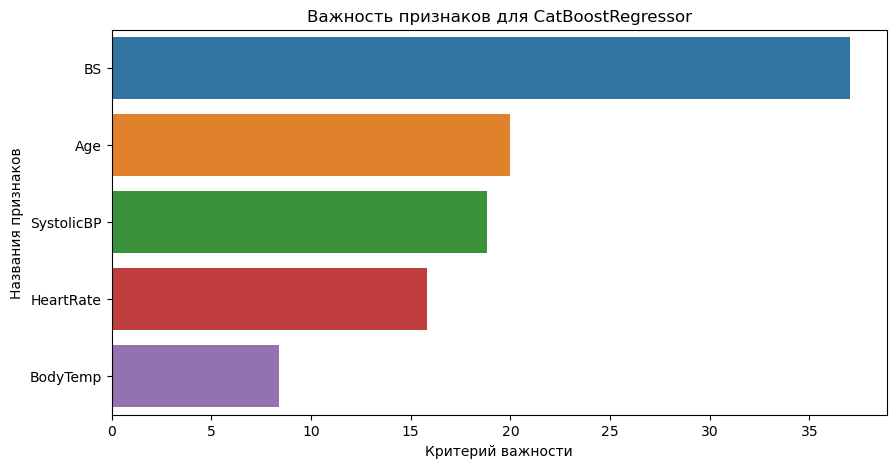

In [19]:
plot_data = {
    'features': features_test.columns,
    'feature_importance': cbc.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=plot_data['feature_importance'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Тут я применил график SHAP, чтобы понять как признаки различных величин влияют на итоговое предсказание

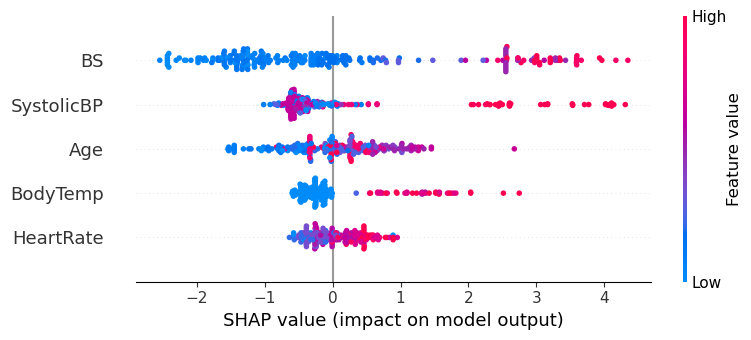

None

In [20]:
shap.initjs()
explainer = shap.TreeExplainer(cbc)
shap_values = explainer.shap_values(features_test)
shap_values_for_class = shap_values[0] 
display(shap.force_plot(explainer.expected_value[0], shap_values_for_class[0,:], features_test.iloc[0,:]))
display(shap.summary_plot(shap_values_for_class, features_test))

Как мы можем видеть из двух графиков выше - BS имеет наибольшую значимость для модели CatBoostRegression:

* Чем выше значение BS, тем лучше для предсказаний модели
* В свою очередь низкие значения SystolicBP ухудшают предсказания

### Вывод по тестированию и важности признаков

* На тестовой выборке модель CatBoostClassifier показала результат на метрике F1 равный 0,85 при следующих параметрах модели: depth=6, iterations=1000, l2_leaf_reg = 3, learning_rate=0.1, verbose=100
* Наиболее важным признаком является BS и, чем выше его значение, тем лучше для предсказаний модели

## Общий вывод

Я достиг результата в 85% точности на тестовой выборке, согласно метрике F1. Этот результат можно улучшить, если еще точнее настроить гиперпараметры для нашей модели, или добавить новых признаков.  

### Вывод требуемых метрик и матриц ошибок

F1_Score_train: 0.93



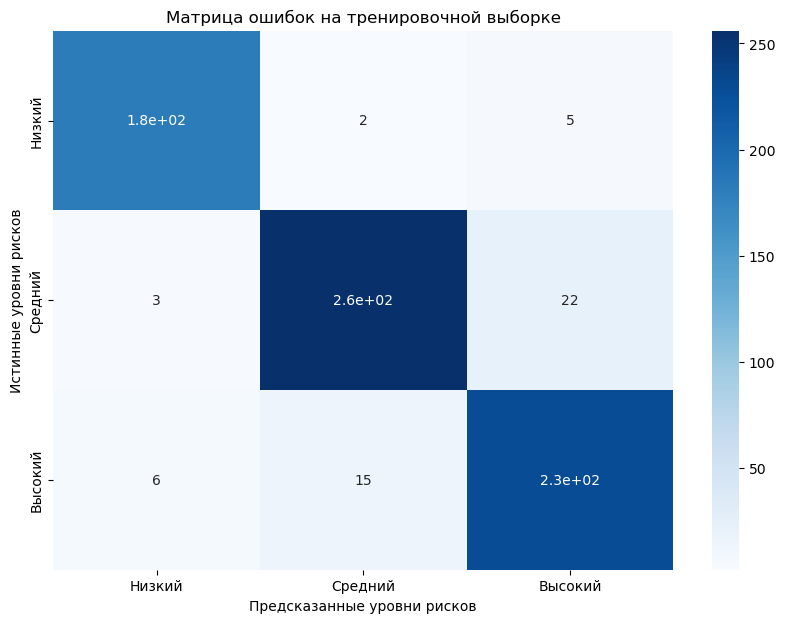

In [21]:
print(f"F1_Score_train: {f_train:.2f}")
print()
cm_train = confusion_matrix(target_train, train_predictions)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm_train, annot=True, cmap='Blues', ax=ax)
ax.set_title('Матрица ошибок на тренировочной выборке')
ax.set_xlabel("Предсказанные уровни рисков")
ax.set_ylabel("Истинные уровни рисков")
ax.set_xticklabels(["Низкий", "Средний", "Высокий"])
ax.set_yticklabels(["Низкий", "Средний", "Высокий"])
plt.show()

F1_Score_test: 0.85



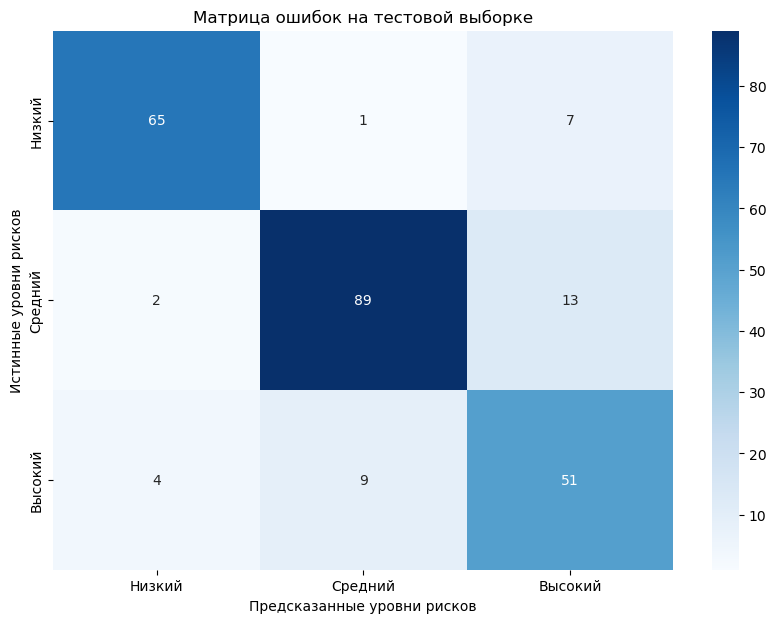

In [22]:
print(f"F1_Score_test: {f_test:.2f}")
print()
cm_test = confusion_matrix(target_test, test_predictions)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, cmap='Blues', ax=ax)
ax.set_title('Матрица ошибок на тестовой выборке')
ax.set_xlabel("Предсказанные уровни рисков")
ax.set_ylabel("Истинные уровни рисков")
ax.set_xticklabels(["Низкий", "Средний", "Высокий"])
ax.set_yticklabels(["Низкий", "Средний", "Высокий"])
plt.show()